## Final Model -- Facial Keypoint Prediction

In this notebook, we walk through a model from the tutorial referenced by the official Kaggle competition website. It was constructed by Daniel Nouri. We will use this model as the baseline of our final project.

### 0. Fire up Neural Nets Libraries

In [5]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from pandas import DataFrame
from sklearn.utils import shuffle

import theano
from nolearn.lasagne import NeuralNet, TrainSplit
# nerual net layers definition
from lasagne import layers
# common gradient descent method
from lasagne.updates import nesterov_momentum
# for transforming images stochastically per batch on the fly
from nolearn.lasagne import BatchIterator

# for evaluating training time
from time import time
from datetime import datetime
# for storing and loading the trained models
import pickle

# for plotting images
import matplotlib.pyplot as plt
# for evaluating MSE
from sklearn.metrics import mean_squared_error

# Increase Python's recursion limit because the neural net model is large enough
import sys
sys.setrecursionlimit(10000)

from collections import OrderedDict
from sklearn.base import clone

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer
    
np.random.seed(42)

import copy
import scipy.misc
import cv2


### 1. Data Path

We will further split the provided training data into our training set and development set in step 4.

In [21]:
FTRAIN = '~/data/training.csv'
FTEST = '~/data/test.csv'
FLOOKUP = '~/data/IdLookupTable.csv'

IDXTRAIN = 'train_indices.txt'
IDXDEV = 'dev_indices.txt'

### 2. View Raw Data

In [24]:
# Each row of our data refers to one face. 
# The first 30 columns refers to the labels of different facial keypoints. 
# A feature vector in the last column store pixel values of the facial image.

read_csv(FTRAIN).head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [25]:
# Testing data has no targets available
read_csv(FTEST).head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


### 3. Transforming Data

In [3]:
# Write function to load the data
# Normalize the target -- coordinates : current grid 96by96
# Normalize the features -- pixels : current range 255

def load(test = False, dev = False,cols = None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN. 
    Pass a list of *cols* if you're only interested in a subset of the target columns"""
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #Load pandas dataframe
    
    if (not test) and dev:
        load_idx = [int(line.rstrip('\n')) for line in open(IDXDEV)]
    elif (not test) and (not dev):    
        load_idx = [int(line.rstrip('\n')) for line in open(IDXTRAIN)]       
    
    if load_idx: df = df.loc[load_idx]
    
    # The Image column has pixel values separated by space
    # convert these values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if cols: # can selectively load some targets by specifying them in the cols argument
        df = df[list(cols) + ['Image']]
        
    print(df.count()) # prints the number of values for each column
    df = df.dropna()

    # drop all rows that have missing values in them. 
    # if argument cols in not specified, this reduce from 7049 partial to 2140 full examples
    # potentially a problem training a neural net with fewer examples
    # should consider data augmentation in upcoming models
    
    # make feature matrix X
    # first convert pixel values from pandas 1D series to numpy 2D array
    # normalize pixel valuaes
    X = np.vstack(df['Image'].values)/255. # scale pixel values to [0,1]
    X = X.astype(np.float32) # make sure numeric val are float32
    # X is numpy.ndarray, shape (2140, 9216) == 2140 examples, 96 grid * 96 grid
    
    # Loading the 30 labels(targets)(keypoints) y for each face into an array
    if not test: # only training examples have target columns
        
        y = df[df.columns[:-1]].values #last column is X, we want the y targets here
        # y is numpy.ndarray, shape(2140, 30) -- 7049 examples, 30 targets each
        
        y = (y - 48) / 48 # scale target coordinates to [-1.1] (currently 96 by 96)
        X, y = shuffle(X, y, random_state = 42) #shuffle training data
        y = y.astype(np.float32)
        
    else:
        y = None # development data has no targets available
        
    return X,y,df.index

In [4]:
# When using convolutional layers in Lasagne, we have to prepare the input data such 
# that each sample is no longer a flat vector of 9,216 pixel intensities, 
# but a three-dimensional matrix with shape (c, 0, 1), where c is the number of channels (colors), 
# and 0 and 1 correspond to the x and y dimensions of the input image. In our case, 
# the concrete shape will be (1, 96, 96), because we're dealing with a single (gray) color 
# channel only.

def load2d(test=False, dev=False, cols=None):
    X, y, idx = load(test=test, dev=dev, cols=cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y, idx

### 4. Splitting into training and development set

In [5]:
from sklearn import model_selection
# help(model_selection.train_test_split)
# keep random state = 0 -- we need the same development set to compare our Baseline with other models
X_train, X_dev, y_train, y_dev, train_idx, test_idx = model_selection.train_test_split(X, y, range(len(X)), test_size=200, shuffle=True, random_state=0)
(X_train.shape, X_dev.shape, y_train.shape, y_dev.shape)

# There are 1940 training examples and 200 development examples

((1940, 1, 96, 96), (200, 1, 96, 96), (1940, 30), (200, 30))

In [6]:
# double check if random state is producing the same split
train_idx[100] == 1410

True

### 5. Data Augmentation -- functions to flipping half of the image on the fly

In [5]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


In [6]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0] #number of examples
        indices = np.random.choice(bs, bs // 2, replace=False) #choose half of them randomly
        Xb[indices] = Xb[indices, :, :, ::-1] #flip these guys randomly

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

### 6. Adjust Variable -- function to update parameters such as learning rate and moment with epochs 

In [7]:
def float32(k):
    return np.cast['float32'](k)

In [10]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

### 7. Early Stopping -- doesn't have to run max epochs once validation loss stablizes 

In [11]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

### 8. Convolutional Neural Net Specification

In [12]:
net12 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=10000,
    verbose=1,
    )

### 9.1 Load the Pickle 
(if net is train already)

In [12]:
fname_pretrain = 'net12.pickle'
with open(fname_pretrain, 'rb') as f:  # !
    net_pretrain = pickle.load(f)

### 9.2 Create Specialists Dictionary

In [14]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

SPECIALIST_NAMES = ["eye_center", "nose_tip", "mouth_corner", "mouth_center", "eye_corner", "eyebrow"]
SPECIALIST_OUTPUTNODES = [4,2,6,2,8,8]

### 9.3 Train Specialists 

In [22]:
net_pretrain = None

# create dictionary to store specialists
specialists = OrderedDict()

i = 0
# loop through specialists one by one
for i in range(len(SPECIALIST_SETTINGS)):
    setting = SPECIALIST_SETTINGS[i]
    specialist_name = SPECIALIST_NAMES[i]
    cols = setting['columns']
    X_specialist, y_specialist, idx = load2d(cols=cols)
    print ("y output nodes:", y_specialist.shape[1])
    print ("-------------------------------------------------------")
    print ("Specialist:",i)
    print ("# examples used:", X_specialist.shape[0])
    # clone pretrained net
    model = clone(net12) 
    # adjust number of output nodes
    model.output_num_units = y_specialist.shape[1] 
    # adjust indices to flip
    model.batch_iterator_train.flip_indices = setting['flip_indices']
    # redefine max number to epochs to lower
    model.max_epochs = 3000   
    # model.max_epochs = int(4e6 / y_specialist.shape[0])
    
    if 'kwargs' in setting:
        # an option 'kwargs' in the settings list may be used to
        # set any other parameter of the net:
        vars(model).update(setting['kwargs'])

    if net_pretrain is not None:
        # if a pretrain model was given, use it to initialize the
        # weights of our new specialist model:
        model.load_params_from(net_pretrain)   

    print("Training model for columns {} for {} epochs".format(cols, model.max_epochs))
    model.fit(X_specialist, y_specialist)
    specialists[specialist_name] = model


left_eye_center_x     6839
left_eye_center_y     6839
right_eye_center_x    6836
right_eye_center_y    6836
Image                 6849
dtype: int64
y output nodes: 4
-------------------------------------------------------
Specialist: 0
# examples used: 6833
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 3000 epochs


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.01031   

     54     0.00340     0.00353    0.96444  6.61s
     54     0.00340     0.00353    0.96444  6.61s
     55     0.00338     0.00351    0.96174  6.60s
     55     0.00338     0.00351    0.96174  6.60s
     56     0.00334     0.00350    0.95445  6.60s
     56     0.00334     0.00350    0.95445  6.60s
     57     0.00334     0.00350    0.95399  6.60s
     57     0.00334     0.00350    0.95399  6.60s
     58     0.00334     0.00348    0.96239  6.60s
     58     0.00334     0.00348    0.96239  6.60s
     59     0.00331     0.00349    0.95037  6.60s
     59     0.00331     0.00349    0.95037  6.60s
     60     0.00331     0.00348    0.95149  6.58s
     60     0.00331     0.00348    0.95149  6.58s
     61     0.00330     0.00345    0.95699  6.59s
     61     0.00330     0.00345    0.95699  6.59s
     62     0.00330     0.00344    0.95999  6.60s
     62     0.00330     0.00344    0.95999  6.60s
     63     0.00329     0.00345    0.95322  6.62s
     63     0.00329     0.00345    0.95322  6.62s


    123     0.00293     0.00310    0.94598  6.59s
    124     0.00295     0.00306    0.96360  6.60s
    124     0.00295     0.00306    0.96360  6.60s
    125     0.00294     0.00310    0.94552  6.61s
    125     0.00294     0.00310    0.94552  6.61s
    126     0.00292     0.00303    0.96136  6.60s
    126     0.00292     0.00303    0.96136  6.60s
    127     0.00294     0.00305    0.96328  6.60s
    127     0.00294     0.00305    0.96328  6.60s
    128     0.00294     0.00303    0.97030  6.60s
    128     0.00294     0.00303    0.97030  6.60s
    129     0.00292     0.00304    0.95811  6.60s
    129     0.00292     0.00304    0.95811  6.60s
    130     0.00290     0.00302    0.96022  6.60s
    130     0.00290     0.00302    0.96022  6.60s
    131     0.00293     0.00304    0.96475  6.60s
    131     0.00293     0.00304    0.96475  6.60s
    132     0.00292     0.00304    0.96189  6.60s
    132     0.00292     0.00304    0.96189  6.60s
    133     0.00290     0.00302    0.96047  6.59s


    196     0.00266     0.00280    0.94749  6.60s
    197     0.00268     0.00278    0.96346  6.60s
    197     0.00268     0.00278    0.96346  6.60s
    198     0.00269     0.00281    0.95628  6.60s
    198     0.00269     0.00281    0.95628  6.60s
    199     0.00266     0.00284    0.93568  6.60s
    199     0.00266     0.00284    0.93568  6.60s
    200     0.00266     0.00279    0.95209  6.60s
    200     0.00266     0.00279    0.95209  6.60s
    201     0.00266     0.00280    0.94758  6.61s
    201     0.00266     0.00280    0.94758  6.61s
    202     0.00267     0.00278    0.95930  6.60s
    202     0.00267     0.00278    0.95930  6.60s
    203     0.00266     0.00276    0.96362  6.61s
    203     0.00266     0.00276    0.96362  6.61s
    204     0.00265     0.00277    0.95700  6.61s
    204     0.00265     0.00277    0.95700  6.61s
    205     0.00263     0.00275    0.95659  6.61s
    205     0.00263     0.00275    0.95659  6.61s
    206     0.00265     0.00275    0.96376  6.61s


    270     0.00246     0.00256    0.96211  6.61s
    271     0.00244     0.00258    0.94554  6.61s
    271     0.00244     0.00258    0.94554  6.61s
    272     0.00244     0.00254    0.96320  6.61s
    272     0.00244     0.00254    0.96320  6.61s
    273     0.00244     0.00256    0.95217  6.60s
    273     0.00244     0.00256    0.95217  6.60s
    274     0.00244     0.00254    0.96014  6.61s
    274     0.00244     0.00254    0.96014  6.61s
    275     0.00244     0.00255    0.95500  6.60s
    275     0.00244     0.00255    0.95500  6.60s
    276     0.00244     0.00254    0.95826  6.61s
    276     0.00244     0.00254    0.95826  6.61s
    277     0.00246     0.00254    0.97035  6.61s
    277     0.00246     0.00254    0.97035  6.61s
    278     0.00243     0.00254    0.95668  6.61s
    278     0.00243     0.00254    0.95668  6.61s
    279     0.00243     0.00253    0.95887  6.61s
    279     0.00243     0.00253    0.95887  6.61s
    280     0.00238     0.00251    0.94779  6.61s


    347     0.00222     0.00237    0.93554  6.62s
    347     0.00222     0.00237    0.93554  6.62s
    348     0.00219     0.00237    0.92226  6.61s
    348     0.00219     0.00237    0.92226  6.61s
    349     0.00221     0.00235    0.94085  6.61s
    349     0.00221     0.00235    0.94085  6.61s
    350     0.00219     0.00237    0.92686  6.61s
    350     0.00219     0.00237    0.92686  6.61s
    351     0.00221     0.00236    0.93686  6.61s
    351     0.00221     0.00236    0.93686  6.61s
    352     0.00219     0.00236    0.92967  6.61s
    352     0.00219     0.00236    0.92967  6.61s
    353     0.00218     0.00235    0.92702  6.61s
    353     0.00218     0.00235    0.92702  6.61s
    354     0.00217     0.00235    0.92360  6.61s
    354     0.00217     0.00235    0.92360  6.61s
    355     0.00215     0.00236    0.91170  6.62s
    355     0.00215     0.00236    0.91170  6.62s
    356     0.00219     0.00235    0.93323  6.62s
    356     0.00219     0.00235    0.93323  6.62s


    423     0.00202     0.00226    0.89377  6.61s
    423     0.00202     0.00226    0.89377  6.61s
    424     0.00199     0.00222    0.89311  6.60s
    424     0.00199     0.00222    0.89311  6.60s
    425     0.00200     0.00227    0.88115  6.61s
    425     0.00200     0.00227    0.88115  6.61s
    426     0.00199     0.00224    0.88776  6.59s
    426     0.00199     0.00224    0.88776  6.59s
    427     0.00201     0.00223    0.90202  6.60s
    427     0.00201     0.00223    0.90202  6.60s
    428     0.00200     0.00225    0.88857  6.61s
    428     0.00200     0.00225    0.88857  6.61s
    429     0.00202     0.00225    0.89959  6.62s
    429     0.00202     0.00225    0.89959  6.62s
    430     0.00196     0.00222    0.88013  6.61s
    430     0.00196     0.00222    0.88013  6.61s
    431     0.00198     0.00223    0.88922  6.60s
    431     0.00198     0.00223    0.88922  6.60s
    432     0.00200     0.00224    0.89345  6.61s
    432     0.00200     0.00224    0.89345  6.61s


    501     0.00189     0.00219    0.86165  6.61s
    502     0.00190     0.00220    0.86289  6.61s
    502     0.00190     0.00220    0.86289  6.61s
    503     0.00184     0.00219    0.83631  6.61s
    503     0.00184     0.00219    0.83631  6.61s
    504     0.00190     0.00221    0.85747  6.60s
    504     0.00190     0.00221    0.85747  6.60s
    505     0.00186     0.00220    0.84573  6.62s
    505     0.00186     0.00220    0.84573  6.62s
    506     0.00186     0.00219    0.85062  6.60s
    506     0.00186     0.00219    0.85062  6.60s
    507     0.00183     0.00220    0.83166  6.62s
    507     0.00183     0.00220    0.83166  6.62s
    508     0.00181     0.00220    0.82254  6.63s
    508     0.00181     0.00220    0.82254  6.63s
    509     0.00184     0.00222    0.83236  6.61s
    509     0.00184     0.00222    0.83236  6.61s
    510     0.00184     0.00220    0.83686  6.62s
    510     0.00184     0.00220    0.83686  6.62s
    511     0.00184     0.00219    0.84049  6.60s


    580     0.00172     0.00213    0.80550  6.61s
    580     0.00172     0.00213    0.80550  6.61s
    581     0.00171     0.00214    0.79807  6.62s
    581     0.00171     0.00214    0.79807  6.62s
    582     0.00166     0.00215    0.77360  6.61s
    582     0.00166     0.00215    0.77360  6.61s
    583     0.00173     0.00214    0.80806  6.60s
    583     0.00173     0.00214    0.80806  6.60s
    584     0.00169     0.00217    0.78150  6.61s
    584     0.00169     0.00217    0.78150  6.61s
    585     0.00175     0.00214    0.81406  6.61s
    585     0.00175     0.00214    0.81406  6.61s
    586     0.00169     0.00214    0.78604  6.61s
    586     0.00169     0.00214    0.78604  6.61s
    587     0.00166     0.00215    0.77436  6.61s
    587     0.00166     0.00215    0.77436  6.61s
    588     0.00168     0.00219    0.76560  6.62s
    588     0.00168     0.00219    0.76560  6.62s
    589     0.00167     0.00216    0.77056  6.62s
    589     0.00167     0.00216    0.77056  6.62s


    658     0.00159     0.00216    0.73922  6.61s
    659     0.00155     0.00212    0.73216  6.61s
    659     0.00155     0.00212    0.73216  6.61s
    660     0.00160     0.00210    0.76040  6.61s
    660     0.00160     0.00210    0.76040  6.61s
    661     0.00160     0.00212    0.75325  6.60s
    661     0.00160     0.00212    0.75325  6.60s
    662     0.00159     0.00212    0.75064  6.61s
    662     0.00159     0.00212    0.75064  6.61s
    663     0.00161     0.00213    0.75542  6.61s
    663     0.00161     0.00213    0.75542  6.61s
    664     0.00160     0.00211    0.75901  6.60s
    664     0.00160     0.00211    0.75901  6.60s
    665     0.00157     0.00213    0.73798  6.61s
    665     0.00157     0.00213    0.73798  6.61s
    666     0.00158     0.00211    0.75111  6.61s
    666     0.00158     0.00211    0.75111  6.61s
    667     0.00159     0.00214    0.74425  6.61s
    667     0.00159     0.00214    0.74425  6.61s
    668     0.00156     0.00210    0.74234  6.62s


    738     0.00147     0.00207    0.71076  6.63s
    738     0.00147     0.00207    0.71076  6.63s
    739     0.00148     0.00207    0.71421  6.61s
    739     0.00148     0.00207    0.71421  6.61s
    740     0.00151     0.00209    0.72064  6.61s
    740     0.00151     0.00209    0.72064  6.61s
    741     0.00149     0.00209    0.71448  6.61s
    741     0.00149     0.00209    0.71448  6.61s
    742     0.00150     0.00208    0.72224  6.61s
    742     0.00150     0.00208    0.72224  6.61s
    743     0.00148     0.00211    0.70041  6.61s
    743     0.00148     0.00211    0.70041  6.61s
    744     0.00147     0.00207    0.70972  6.61s
    744     0.00147     0.00207    0.70972  6.61s
    745     0.00150     0.00210    0.71337  6.61s
    745     0.00150     0.00210    0.71337  6.61s
    746     0.00153     0.00206    0.74432  6.64s
    746     0.00153     0.00206    0.74432  6.64s
    747     0.00148     0.00208    0.70919  6.66s
    747     0.00148     0.00208    0.70919  6.66s


    818     0.00137     0.00208    0.65838  6.61s
    818     0.00137     0.00208    0.65838  6.61s
    819     0.00144     0.00205    0.70060  6.60s
    819     0.00144     0.00205    0.70060  6.60s
    820     0.00144     0.00205    0.70334  6.61s
    820     0.00144     0.00205    0.70334  6.61s
    821     0.00139     0.00207    0.67221  6.60s
    821     0.00139     0.00207    0.67221  6.60s
    822     0.00141     0.00204    0.69112  6.60s
    822     0.00141     0.00204    0.69112  6.60s
    823     0.00140     0.00206    0.68220  6.61s
    823     0.00140     0.00206    0.68220  6.61s
    824     0.00137     0.00204    0.67062  6.61s
    824     0.00137     0.00204    0.67062  6.61s
    825     0.00143     0.00204    0.69977  6.61s
    825     0.00143     0.00204    0.69977  6.61s
    826     0.00142     0.00206    0.69267  6.60s
    826     0.00142     0.00206    0.69267  6.60s
    827     0.00136     0.00205    0.66621  6.60s
    827     0.00136     0.00205    0.66621  6.60s


    897     0.00129     0.00202    0.63848  6.61s
    898     0.00134     0.00201    0.66720  6.62s
    898     0.00134     0.00201    0.66720  6.62s
    899     0.00135     0.00200    0.67473  6.60s
    899     0.00135     0.00200    0.67473  6.60s
    900     0.00138     0.00203    0.67647  6.61s
    900     0.00138     0.00203    0.67647  6.61s
    901     0.00135     0.00203    0.66184  6.62s
    901     0.00135     0.00203    0.66184  6.62s
    902     0.00138     0.00202    0.68502  6.61s
    902     0.00138     0.00202    0.68502  6.61s
    903     0.00136     0.00202    0.67203  6.62s
    903     0.00136     0.00202    0.67203  6.62s
    904     0.00129     0.00203    0.63514  6.62s
    904     0.00129     0.00203    0.63514  6.62s
    905     0.00133     0.00201    0.66092  6.62s
    905     0.00133     0.00201    0.66092  6.62s
    906     0.00134     0.00202    0.66594  6.61s
    906     0.00134     0.00202    0.66594  6.61s
    907     0.00132     0.00202    0.65072  6.61s


    978     0.00128     0.00202    0.63602  6.60s
    978     0.00128     0.00202    0.63602  6.60s
    979     0.00127     0.00202    0.63113  6.62s
    979     0.00127     0.00202    0.63113  6.62s
    980     0.00127     0.00199    0.63760  6.62s
    980     0.00127     0.00199    0.63760  6.62s
    981     0.00135     0.00200    0.67484  6.61s
    981     0.00135     0.00200    0.67484  6.61s
    982     0.00125     0.00198    0.63031  6.61s
    982     0.00125     0.00198    0.63031  6.61s
    983     0.00125     0.00197    0.63548  6.62s
    983     0.00125     0.00197    0.63548  6.62s
    984     0.00126     0.00201    0.62670  6.61s
    984     0.00126     0.00201    0.62670  6.61s
    985     0.00126     0.00199    0.63211  6.62s
    985     0.00126     0.00199    0.63211  6.62s
    986     0.00124     0.00202    0.61431  6.61s
    986     0.00124     0.00202    0.61431  6.61s
    987     0.00124     0.00199    0.62187  6.62s
    987     0.00124     0.00199    0.62187  6.62s


   1058     0.00119     0.00198    0.60064  6.61s
   1058     0.00119     0.00198    0.60064  6.61s
   1059     0.00119     0.00202    0.58751  6.62s
   1059     0.00119     0.00202    0.58751  6.62s
   1060     0.00124     0.00201    0.61810  6.62s
   1060     0.00124     0.00201    0.61810  6.62s
   1061     0.00123     0.00200    0.61459  6.61s
   1061     0.00123     0.00200    0.61459  6.61s
   1062     0.00121     0.00197    0.61548  6.61s
   1062     0.00121     0.00197    0.61548  6.61s
   1063     0.00125     0.00199    0.62791  6.62s
   1063     0.00125     0.00199    0.62791  6.62s
   1064     0.00120     0.00197    0.61066  6.61s
   1064     0.00120     0.00197    0.61066  6.61s
   1065     0.00122     0.00197    0.61952  6.61s
   1065     0.00122     0.00197    0.61952  6.61s
   1066     0.00124     0.00197    0.62801  6.61s
   1066     0.00124     0.00197    0.62801  6.61s
   1067     0.00119     0.00198    0.60354  6.61s
   1067     0.00119     0.00198    0.60354  6.61s


   1139     0.00120     0.00195    0.61748  6.61s
   1139     0.00120     0.00195    0.61748  6.61s
   1140     0.00120     0.00196    0.60903  6.61s
   1140     0.00120     0.00196    0.60903  6.61s
   1141     0.00124     0.00195    0.63441  6.61s
   1141     0.00124     0.00195    0.63441  6.61s
   1142     0.00119     0.00196    0.60471  6.61s
   1142     0.00119     0.00196    0.60471  6.61s
   1143     0.00117     0.00199    0.58643  6.62s
   1143     0.00117     0.00199    0.58643  6.62s
   1144     0.00120     0.00197    0.61097  6.61s
   1144     0.00120     0.00197    0.61097  6.61s
   1145     0.00119     0.00201    0.59192  6.61s
   1145     0.00119     0.00201    0.59192  6.61s
   1146     0.00117     0.00198    0.58890  6.61s
   1146     0.00117     0.00198    0.58890  6.61s
   1147     0.00117     0.00198    0.59071  6.61s
   1147     0.00117     0.00198    0.59071  6.61s
   1148     0.00116     0.00196    0.59141  6.61s
   1148     0.00116     0.00196    0.59141  6.61s


   1219     0.00117     0.00194    0.60444  6.61s
   1220     0.00114     0.00195    0.58511  6.61s
   1220     0.00114     0.00195    0.58511  6.61s
   1221     0.00118     0.00196    0.60294  6.61s
   1221     0.00118     0.00196    0.60294  6.61s
   1222     0.00114     0.00196    0.58179  6.61s
   1222     0.00114     0.00196    0.58179  6.61s
   1223     0.00113     0.00194    0.58346  6.60s
   1223     0.00113     0.00194    0.58346  6.60s
   1224     0.00111     0.00195    0.57000  6.61s
   1224     0.00111     0.00195    0.57000  6.61s
   1225     0.00112     0.00194    0.57866  6.61s
   1225     0.00112     0.00194    0.57866  6.61s
   1226     0.00117     0.00195    0.60066  6.61s
   1226     0.00117     0.00195    0.60066  6.61s
   1227     0.00115     0.00195    0.58865  6.61s
   1227     0.00115     0.00195    0.58865  6.61s
   1228     0.00112     0.00194    0.58054  6.61s
   1228     0.00112     0.00194    0.58054  6.61s
   1229     0.00116     0.00194    0.59881  6.61s


   1301     0.00113     0.00197    0.57531  6.62s
   1301     0.00113     0.00197    0.57531  6.62s
   1302     0.00112     0.00193    0.58071  6.62s
   1302     0.00112     0.00193    0.58071  6.62s
   1303     0.00112     0.00194    0.57936  6.61s
   1303     0.00112     0.00194    0.57936  6.61s
   1304     0.00109     0.00195    0.55918  6.61s
   1304     0.00109     0.00195    0.55918  6.61s
   1305     0.00110     0.00193    0.57081  6.61s
   1305     0.00110     0.00193    0.57081  6.61s
   1306     0.00113     0.00195    0.58095  6.60s
   1306     0.00113     0.00195    0.58095  6.60s
   1307     0.00112     0.00193    0.58082  6.61s
   1307     0.00112     0.00193    0.58082  6.61s
   1308     0.00113     0.00193    0.58508  6.61s
   1308     0.00113     0.00193    0.58508  6.61s
   1309     0.00113     0.00195    0.57835  6.61s
   1309     0.00113     0.00195    0.57835  6.61s
   1310     0.00114     0.00194    0.58749  6.61s
   1310     0.00114     0.00194    0.58749  6.61s


   1381     0.00106     0.00192    0.55182  6.61s
   1382     0.00106     0.00193    0.54702  6.61s
   1382     0.00106     0.00193    0.54702  6.61s
   1383     0.00109     0.00194    0.56481  6.62s
   1383     0.00109     0.00194    0.56481  6.62s
   1384     0.00109     0.00192    0.56581  6.62s
   1384     0.00109     0.00192    0.56581  6.62s
   1385     0.00107     0.00191    0.55641  6.61s
   1385     0.00107     0.00191    0.55641  6.61s
   1386     0.00110     0.00193    0.56937  6.61s
   1386     0.00110     0.00193    0.56937  6.61s
   1387     0.00108     0.00192    0.56167  6.61s
   1387     0.00108     0.00192    0.56167  6.61s
   1388     0.00106     0.00191    0.55511  6.61s
   1388     0.00106     0.00191    0.55511  6.61s
   1389     0.00105     0.00192    0.54647  6.62s
   1389     0.00105     0.00192    0.54647  6.62s
   1390     0.00108     0.00194    0.55462  6.61s
   1390     0.00108     0.00194    0.55462  6.61s
   1391     0.00106     0.00193    0.55041  6.61s


   1463     0.00103     0.00193    0.53428  6.61s
   1463     0.00103     0.00193    0.53428  6.61s
   1464     0.00111     0.00191    0.58003  6.62s
   1464     0.00111     0.00191    0.58003  6.62s
   1465     0.00106     0.00194    0.54710  6.62s
   1465     0.00106     0.00194    0.54710  6.62s
   1466     0.00107     0.00191    0.56035  6.62s
   1466     0.00107     0.00191    0.56035  6.62s
   1467     0.00107     0.00191    0.55969  6.61s
   1467     0.00107     0.00191    0.55969  6.61s
   1468     0.00104     0.00190    0.54626  6.61s
   1468     0.00104     0.00190    0.54626  6.61s
   1469     0.00110     0.00190    0.57888  6.60s
   1469     0.00110     0.00190    0.57888  6.60s
   1470     0.00103     0.00193    0.53396  6.61s
   1470     0.00103     0.00193    0.53396  6.61s
   1471     0.00109     0.00192    0.56724  6.61s
   1471     0.00109     0.00192    0.56724  6.61s
   1472     0.00105     0.00193    0.54296  6.61s
   1472     0.00105     0.00193    0.54296  6.61s


   1545     0.00103     0.00193    0.53483  6.61s
   1545     0.00103     0.00193    0.53483  6.61s
   1546     0.00100     0.00189    0.52954  6.61s
   1546     0.00100     0.00189    0.52954  6.61s
   1547     0.00103     0.00190    0.54067  6.61s
   1547     0.00103     0.00190    0.54067  6.61s
   1548     0.00109     0.00192    0.56643  6.61s
   1548     0.00109     0.00192    0.56643  6.61s
   1549     0.00102     0.00192    0.53421  6.62s
   1549     0.00102     0.00192    0.53421  6.62s
   1550     0.00101     0.00191    0.52507  6.62s
   1550     0.00101     0.00191    0.52507  6.62s
   1551     0.00105     0.00191    0.54903  6.62s
   1551     0.00105     0.00191    0.54903  6.62s
   1552     0.00103     0.00189    0.54721  6.61s
   1552     0.00103     0.00189    0.54721  6.61s
   1553     0.00101     0.00191    0.52757  6.61s
   1553     0.00101     0.00191    0.52757  6.61s
   1554     0.00102     0.00193    0.52697  6.61s
   1554     0.00102     0.00193    0.52697  6.61s


   1626     0.00101     0.00188    0.53617  6.61s
   1627     0.00098     0.00190    0.51723  6.61s
   1627     0.00098     0.00190    0.51723  6.61s
   1628     0.00100     0.00190    0.52284  6.61s
   1628     0.00100     0.00190    0.52284  6.61s
   1629     0.00099     0.00189    0.52362  6.61s
   1629     0.00099     0.00189    0.52362  6.61s
   1630     0.00100     0.00188    0.53395  6.61s
   1630     0.00100     0.00188    0.53395  6.61s
   1631     0.00106     0.00188    0.56190  6.62s
   1631     0.00106     0.00188    0.56190  6.62s
   1632     0.00099     0.00188    0.52682  6.61s
   1632     0.00099     0.00188    0.52682  6.61s
   1633     0.00101     0.00190    0.53075  6.61s
   1633     0.00101     0.00190    0.53075  6.61s
   1634     0.00102     0.00188    0.54067  6.61s
   1634     0.00102     0.00188    0.54067  6.61s
   1635     0.00104     0.00189    0.55020  6.61s
   1635     0.00104     0.00189    0.55020  6.61s
   1636     0.00100     0.00189    0.52785  6.61s


   1708     0.00099     0.00189    0.52584  6.62s
   1708     0.00099     0.00189    0.52584  6.62s
   1709     0.00098     0.00188    0.52111  6.62s
   1709     0.00098     0.00188    0.52111  6.62s
   1710     0.00100     0.00189    0.52734  6.61s
   1710     0.00100     0.00189    0.52734  6.61s
   1711     0.00098     0.00189    0.51732  6.62s
   1711     0.00098     0.00189    0.51732  6.62s
   1712     0.00100     0.00189    0.52664  6.61s
   1712     0.00100     0.00189    0.52664  6.61s
   1713     0.00096     0.00188    0.51206  6.61s
   1713     0.00096     0.00188    0.51206  6.61s
   1714     0.00096     0.00188    0.51032  6.61s
   1714     0.00096     0.00188    0.51032  6.61s
   1715     0.00098     0.00187    0.52276  6.61s
   1715     0.00098     0.00187    0.52276  6.61s
   1716     0.00100     0.00189    0.52751  6.60s
   1716     0.00100     0.00189    0.52751  6.60s
   1717     0.00099     0.00187    0.52828  6.62s
   1717     0.00099     0.00187    0.52828  6.62s


   1788     0.00098     0.00189    0.51569  6.61s
   1789     0.00096     0.00187    0.51726  6.62s
   1789     0.00096     0.00187    0.51726  6.62s
   1790     0.00096     0.00187    0.51340  6.61s
   1790     0.00096     0.00187    0.51340  6.61s
   1791     0.00097     0.00186    0.52250  6.61s
   1791     0.00097     0.00186    0.52250  6.61s
   1792     0.00096     0.00189    0.50880  6.61s
   1792     0.00096     0.00189    0.50880  6.61s
   1793     0.00094     0.00188    0.50157  6.61s
   1793     0.00094     0.00188    0.50157  6.61s
   1794     0.00095     0.00188    0.50291  6.61s
   1794     0.00095     0.00188    0.50291  6.61s
   1795     0.00099     0.00187    0.52761  6.63s
   1795     0.00099     0.00187    0.52761  6.63s
   1796     0.00095     0.00188    0.50672  6.62s
   1796     0.00095     0.00188    0.50672  6.62s
   1797     0.00099     0.00187    0.53168  6.62s
   1797     0.00099     0.00187    0.53168  6.62s
   1798     0.00103     0.00187    0.55135  6.62s


   1870     0.00094     0.00186    0.50563  6.61s
   1870     0.00094     0.00186    0.50563  6.61s
   1871     0.00093     0.00187    0.49877  6.61s
   1871     0.00093     0.00187    0.49877  6.61s
   1872     0.00091     0.00185    0.49310  6.62s
   1872     0.00091     0.00185    0.49310  6.62s
   1873     0.00095     0.00186    0.50824  6.61s
   1873     0.00095     0.00186    0.50824  6.61s
   1874     0.00092     0.00185    0.49685  6.62s
   1874     0.00092     0.00185    0.49685  6.62s
   1875     0.00093     0.00186    0.49907  6.62s
   1875     0.00093     0.00186    0.49907  6.62s
   1876     0.00095     0.00186    0.50885  6.62s
   1876     0.00095     0.00186    0.50885  6.62s
   1877     0.00094     0.00185    0.50936  6.61s
   1877     0.00094     0.00185    0.50936  6.61s
   1878     0.00096     0.00186    0.51756  6.61s
   1878     0.00096     0.00186    0.51756  6.61s
   1879     0.00094     0.00187    0.50305  6.61s
   1879     0.00094     0.00187    0.50305  6.61s


   1950     0.00093     0.00186    0.50013  6.62s
   1951     0.00093     0.00187    0.49643  6.62s
   1951     0.00093     0.00187    0.49643  6.62s
   1952     0.00093     0.00184    0.50575  6.61s
   1952     0.00093     0.00184    0.50575  6.61s
   1953     0.00094     0.00184    0.51306  6.61s
   1953     0.00094     0.00184    0.51306  6.61s
   1954     0.00092     0.00185    0.49611  6.61s
   1954     0.00092     0.00185    0.49611  6.61s
   1955     0.00093     0.00184    0.50343  6.61s
   1955     0.00093     0.00184    0.50343  6.61s
   1956     0.00094     0.00186    0.50185  6.61s
   1956     0.00094     0.00186    0.50185  6.61s
   1957     0.00094     0.00187    0.50526  6.61s
   1957     0.00094     0.00187    0.50526  6.61s
   1958     0.00092     0.00186    0.49382  6.61s
   1958     0.00092     0.00186    0.49382  6.61s
   1959     0.00093     0.00186    0.49960  6.61s
   1959     0.00093     0.00186    0.49960  6.61s
   1960     0.00094     0.00188    0.49605  6.62s


   2032     0.00091     0.00186    0.48886  6.61s
   2032     0.00091     0.00186    0.48886  6.61s
   2033     0.00089     0.00187    0.47278  6.61s
   2033     0.00089     0.00187    0.47278  6.61s
   2034     0.00091     0.00186    0.49052  6.61s
   2034     0.00091     0.00186    0.49052  6.61s
   2035     0.00089     0.00187    0.47599  6.61s
   2035     0.00089     0.00187    0.47599  6.61s
   2036     0.00091     0.00188    0.48317  6.60s
   2036     0.00091     0.00188    0.48317  6.60s
   2037     0.00093     0.00185    0.50107  6.62s
   2037     0.00093     0.00185    0.50107  6.62s
   2038     0.00094     0.00187    0.50140  6.62s
   2038     0.00094     0.00187    0.50140  6.62s
   2039     0.00090     0.00188    0.48053  6.61s
   2039     0.00090     0.00188    0.48053  6.61s
   2040     0.00090     0.00188    0.48060  6.61s
   2040     0.00090     0.00188    0.48060  6.61s
   2041     0.00089     0.00188    0.47539  6.62s
   2041     0.00089     0.00188    0.47539  6.62s


   2113     0.00095     0.00186    0.50920  6.62s
   2113     0.00095     0.00186    0.50920  6.62s
   2114     0.00088     0.00184    0.47965  6.61s
   2114     0.00088     0.00184    0.47965  6.61s
   2115     0.00087     0.00185    0.47290  6.61s
   2115     0.00087     0.00185    0.47290  6.61s
   2116     0.00089     0.00183    0.48791  6.61s
   2116     0.00089     0.00183    0.48791  6.61s
   2117     0.00087     0.00185    0.47131  6.62s
   2117     0.00087     0.00185    0.47131  6.62s
   2118     0.00094     0.00186    0.50776  6.62s
   2118     0.00094     0.00186    0.50776  6.62s
   2119     0.00088     0.00185    0.47571  6.61s
   2119     0.00088     0.00185    0.47571  6.61s
   2120     0.00089     0.00185    0.48441  6.60s
   2120     0.00089     0.00185    0.48441  6.60s
   2121     0.00088     0.00185    0.47662  6.62s
   2121     0.00088     0.00185    0.47662  6.62s
   2122     0.00092     0.00185    0.49623  6.62s
   2122     0.00092     0.00185    0.49623  6.62s


   2195     0.00089     0.00184    0.48455  6.61s
   2195     0.00089     0.00184    0.48455  6.61s
   2196     0.00092     0.00186    0.49494  6.61s
   2196     0.00092     0.00186    0.49494  6.61s
   2197     0.00091     0.00185    0.49571  6.61s
   2197     0.00091     0.00185    0.49571  6.61s
   2198     0.00090     0.00184    0.48681  6.60s
   2198     0.00090     0.00184    0.48681  6.60s
   2199     0.00087     0.00183    0.47516  6.61s
   2199     0.00087     0.00183    0.47516  6.61s
   2200     0.00088     0.00183    0.47921  6.62s
   2200     0.00088     0.00183    0.47921  6.62s
   2201     0.00089     0.00183    0.48695  6.62s
   2201     0.00089     0.00183    0.48695  6.62s
   2202     0.00088     0.00184    0.47912  6.62s
   2202     0.00088     0.00184    0.47912  6.62s
   2203     0.00090     0.00187    0.48172  6.62s
   2203     0.00090     0.00187    0.48172  6.62s
   2204     0.00087     0.00184    0.47140  6.61s
   2204     0.00087     0.00184    0.47140  6.61s


   2276     0.00085     0.00184    0.46262  6.61s
   2277     0.00089     0.00182    0.49201  6.62s
   2277     0.00089     0.00182    0.49201  6.62s
   2278     0.00091     0.00184    0.49546  6.61s
   2278     0.00091     0.00184    0.49546  6.61s
   2279     0.00085     0.00184    0.46340  6.61s
   2279     0.00085     0.00184    0.46340  6.61s
   2280     0.00087     0.00183    0.47572  6.61s
   2280     0.00087     0.00183    0.47572  6.61s
   2281     0.00086     0.00182    0.47447  6.60s
   2281     0.00086     0.00182    0.47447  6.60s
   2282     0.00085     0.00181    0.47011  6.62s
   2282     0.00085     0.00181    0.47011  6.62s
   2283     0.00091     0.00181    0.50263  6.62s
   2283     0.00091     0.00181    0.50263  6.62s
   2284     0.00086     0.00184    0.46976  6.61s
   2284     0.00086     0.00184    0.46976  6.61s
   2285     0.00088     0.00182    0.48664  6.61s
   2285     0.00088     0.00182    0.48664  6.61s
   2286     0.00089     0.00182    0.48837  6.61s


   2358     0.00086     0.00184    0.46921  6.62s
   2358     0.00086     0.00184    0.46921  6.62s
   2359     0.00089     0.00186    0.47882  6.61s
   2359     0.00089     0.00186    0.47882  6.61s
   2360     0.00085     0.00183    0.46708  6.61s
   2360     0.00085     0.00183    0.46708  6.61s
   2361     0.00085     0.00181    0.47066  6.61s
   2361     0.00085     0.00181    0.47066  6.61s
   2362     0.00087     0.00182    0.48002  6.61s
   2362     0.00087     0.00182    0.48002  6.61s
   2363     0.00085     0.00184    0.46020  6.61s
   2363     0.00085     0.00184    0.46020  6.61s
   2364     0.00087     0.00183    0.47525  6.61s
   2364     0.00087     0.00183    0.47525  6.61s
   2365     0.00083     0.00181    0.45578  6.62s
   2365     0.00083     0.00181    0.45578  6.62s
   2366     0.00085     0.00181    0.46907  6.62s
   2366     0.00085     0.00181    0.46907  6.62s
   2367     0.00088     0.00182    0.48145  6.62s
   2367     0.00088     0.00182    0.48145  6.62s


   2439     0.00086     0.00182    0.46880  6.62s
   2439     0.00086     0.00182    0.46880  6.62s
   2440     0.00086     0.00182    0.47196  6.62s
   2440     0.00086     0.00182    0.47196  6.62s
   2441     0.00083     0.00181    0.45958  6.62s
   2441     0.00083     0.00181    0.45958  6.62s
   2442     0.00085     0.00182    0.46640  6.62s
   2442     0.00085     0.00182    0.46640  6.62s
   2443     0.00087     0.00182    0.47658  6.62s
   2443     0.00087     0.00182    0.47658  6.62s
   2444     0.00085     0.00182    0.46427  6.61s
   2444     0.00085     0.00182    0.46427  6.61s
   2445     0.00091     0.00182    0.49885  6.62s
   2445     0.00091     0.00182    0.49885  6.62s
   2446     0.00087     0.00183    0.47673  6.61s
   2446     0.00087     0.00183    0.47673  6.61s
   2447     0.00085     0.00184    0.46191  6.60s
   2447     0.00085     0.00184    0.46191  6.60s
   2448     0.00085     0.00182    0.46825  6.61s
   2448     0.00085     0.00182    0.46825  6.61s


   2520     0.00084     0.00182    0.46495  6.60s
   2521     0.00082     0.00183    0.44744  6.58s
   2521     0.00082     0.00183    0.44744  6.58s
   2522     0.00082     0.00181    0.45510  6.57s
   2522     0.00082     0.00181    0.45510  6.57s
   2523     0.00081     0.00181    0.44759  6.58s
   2523     0.00081     0.00181    0.44759  6.58s
   2524     0.00081     0.00181    0.44723  6.60s
   2524     0.00081     0.00181    0.44723  6.60s
   2525     0.00083     0.00181    0.45799  6.61s
   2525     0.00083     0.00181    0.45799  6.61s
   2526     0.00079     0.00181    0.43579  6.60s
   2526     0.00079     0.00181    0.43579  6.60s
   2527     0.00083     0.00181    0.46190  6.59s
   2527     0.00083     0.00181    0.46190  6.59s
   2528     0.00086     0.00180    0.47503  6.56s
   2528     0.00086     0.00180    0.47503  6.56s
   2529     0.00083     0.00181    0.46056  6.56s
   2529     0.00083     0.00181    0.46056  6.56s
   2530     0.00087     0.00182    0.47507  6.56s


   2602     0.00085     0.00181    0.47134  6.62s
   2603     0.00082     0.00182    0.44984  6.60s
   2603     0.00082     0.00182    0.44984  6.60s
   2604     0.00082     0.00181    0.45357  6.59s
   2604     0.00082     0.00181    0.45357  6.59s
   2605     0.00083     0.00180    0.46423  6.59s
   2605     0.00083     0.00180    0.46423  6.59s
   2606     0.00084     0.00181    0.46508  6.60s
   2606     0.00084     0.00181    0.46508  6.60s
   2607     0.00084     0.00182    0.45952  6.60s
   2607     0.00084     0.00182    0.45952  6.60s
   2608     0.00085     0.00181    0.47057  6.61s
   2608     0.00085     0.00181    0.47057  6.61s
   2609     0.00081     0.00182    0.44556  6.59s
   2609     0.00081     0.00182    0.44556  6.59s
   2610     0.00081     0.00182    0.44667  6.61s
   2610     0.00081     0.00182    0.44667  6.61s
   2611     0.00082     0.00180    0.45938  6.62s
   2611     0.00082     0.00180    0.45938  6.62s
   2612     0.00082     0.00181    0.45047  6.62s


   2684     0.00080     0.00178    0.44800  6.59s
   2684     0.00080     0.00178    0.44800  6.59s
   2685     0.00085     0.00182    0.46378  6.59s
   2685     0.00085     0.00182    0.46378  6.59s
   2686     0.00081     0.00180    0.45144  6.59s
   2686     0.00081     0.00180    0.45144  6.59s
   2687     0.00081     0.00180    0.45191  6.59s
   2687     0.00081     0.00180    0.45191  6.59s
   2688     0.00082     0.00181    0.45099  6.59s
   2688     0.00082     0.00181    0.45099  6.59s
   2689     0.00081     0.00180    0.44721  6.59s
   2689     0.00081     0.00180    0.44721  6.59s
   2690     0.00081     0.00179    0.45563  6.59s
   2690     0.00081     0.00179    0.45563  6.59s
   2691     0.00078     0.00181    0.43112  6.60s
   2691     0.00078     0.00181    0.43112  6.60s
   2692     0.00083     0.00181    0.45674  6.57s
   2692     0.00083     0.00181    0.45674  6.57s
   2693     0.00079     0.00178    0.44306  6.59s
   2693     0.00079     0.00178    0.44306  6.59s


   2765     0.00080     0.00180    0.44415  6.59s
   2765     0.00080     0.00180    0.44415  6.59s
   2766     0.00081     0.00180    0.45099  6.59s
   2766     0.00081     0.00180    0.45099  6.59s
   2767     0.00079     0.00179    0.44215  6.58s
   2767     0.00079     0.00179    0.44215  6.58s
   2768     0.00079     0.00180    0.44042  6.57s
   2768     0.00079     0.00180    0.44042  6.57s
   2769     0.00080     0.00179    0.44560  6.58s
   2769     0.00080     0.00179    0.44560  6.58s
   2770     0.00083     0.00177    0.46892  6.58s
   2770     0.00083     0.00177    0.46892  6.58s
   2771     0.00081     0.00179    0.45497  6.58s
   2771     0.00081     0.00179    0.45497  6.58s
   2772     0.00081     0.00179    0.45337  6.58s
   2772     0.00081     0.00179    0.45337  6.58s
   2773     0.00080     0.00178    0.45123  6.58s
   2773     0.00080     0.00178    0.45123  6.58s
   2774     0.00079     0.00181    0.43718  6.58s
   2774     0.00079     0.00181    0.43718  6.58s


   2847     0.00082     0.00178    0.46255  6.57s
   2847     0.00082     0.00178    0.46255  6.57s
   2848     0.00076     0.00178    0.42913  6.57s
   2848     0.00076     0.00178    0.42913  6.57s
   2849     0.00081     0.00180    0.44740  6.58s
   2849     0.00081     0.00180    0.44740  6.58s
   2850     0.00079     0.00177    0.44497  6.56s
   2850     0.00079     0.00177    0.44497  6.56s
   2851     0.00080     0.00182    0.43874  6.57s
   2851     0.00080     0.00182    0.43874  6.57s
   2852     0.00079     0.00178    0.44540  6.57s
   2852     0.00079     0.00178    0.44540  6.57s
   2853     0.00076     0.00179    0.42553  6.57s
   2853     0.00076     0.00179    0.42553  6.57s
   2854     0.00080     0.00179    0.44756  6.57s
   2854     0.00080     0.00179    0.44756  6.57s
   2855     0.00078     0.00179    0.43427  6.57s
   2855     0.00078     0.00179    0.43427  6.57s
   2856     0.00079     0.00180    0.44094  6.57s
   2856     0.00079     0.00180    0.44094  6.57s


nose_tip_x    6849
nose_tip_y    6849
Image         6849
dtype: int64
y output nodes: 2
-------------------------------------------------------
Specialist: 1
# examples used: 6849
Training model for columns ('nose_tip_x', 'nose_tip_y') for 3000 epochs


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.01392   

     55     0.00597     0.00627    0.95107  6.57s
     55     0.00597     0.00627    0.95107  6.57s
     56     0.00596     0.00626    0.95108  6.57s
     56     0.00596     0.00626    0.95108  6.57s
     57     0.00592     0.00636    0.93071  6.57s
     57     0.00592     0.00636    0.93071  6.57s
     58     0.00590     0.00618    0.95479  6.57s
     58     0.00590     0.00618    0.95479  6.57s
     59     0.00587     0.00629    0.93332  6.57s
     59     0.00587     0.00629    0.93332  6.57s
     60     0.00584     0.00614    0.94987  6.58s
     60     0.00584     0.00614    0.94987  6.58s
     61     0.00585     0.00605    0.96724  6.58s
     61     0.00585     0.00605    0.96724  6.58s
     62     0.00577     0.00620    0.93113  6.58s
     62     0.00577     0.00620    0.93113  6.58s
     63     0.00570     0.00603    0.94507  6.59s
     63     0.00570     0.00603    0.94507  6.59s
     64     0.00581     0.00588    0.98815  6.57s
     64     0.00581     0.00588    0.98815  6.57s


    125     0.00469     0.00500    0.93868  6.57s
    126     0.00464     0.00482    0.96138  6.58s
    126     0.00464     0.00482    0.96138  6.58s
    127     0.00464     0.00491    0.94564  6.58s
    127     0.00464     0.00491    0.94564  6.58s
    128     0.00462     0.00498    0.92686  6.57s
    128     0.00462     0.00498    0.92686  6.57s
    129     0.00460     0.00494    0.93012  6.57s
    129     0.00460     0.00494    0.93012  6.57s
    130     0.00458     0.00493    0.93013  6.57s
    130     0.00458     0.00493    0.93013  6.57s
    131     0.00453     0.00500    0.90569  6.57s
    131     0.00453     0.00500    0.90569  6.57s
    132     0.00464     0.00477    0.97299  6.57s
    132     0.00464     0.00477    0.97299  6.57s
    133     0.00457     0.00494    0.92456  6.57s
    133     0.00457     0.00494    0.92456  6.57s
    134     0.00460     0.00482    0.95447  6.57s
    134     0.00460     0.00482    0.95447  6.57s
    135     0.00458     0.00472    0.96960  6.58s


    200     0.00384     0.00435    0.88315  6.58s
    201     0.00382     0.00432    0.88329  6.58s
    201     0.00382     0.00432    0.88329  6.58s
    202     0.00388     0.00431    0.89959  6.58s
    202     0.00388     0.00431    0.89959  6.58s
    203     0.00384     0.00428    0.89841  6.58s
    203     0.00384     0.00428    0.89841  6.58s
    204     0.00375     0.00427    0.87812  6.58s
    204     0.00375     0.00427    0.87812  6.58s
    205     0.00382     0.00424    0.90138  6.58s
    205     0.00382     0.00424    0.90138  6.58s
    206     0.00387     0.00432    0.89492  6.59s
    206     0.00387     0.00432    0.89492  6.59s
    207     0.00385     0.00430    0.89489  6.59s
    207     0.00385     0.00430    0.89489  6.59s
    208     0.00373     0.00432    0.86359  6.59s
    208     0.00373     0.00432    0.86359  6.59s
    209     0.00383     0.00427    0.89700  6.59s
    209     0.00383     0.00427    0.89700  6.59s
    210     0.00375     0.00434    0.86461  6.58s


    277     0.00327     0.00399    0.82148  6.58s
    277     0.00327     0.00399    0.82148  6.58s
    278     0.00329     0.00403    0.81786  6.58s
    278     0.00329     0.00403    0.81786  6.58s
    279     0.00331     0.00407    0.81388  6.58s
    279     0.00331     0.00407    0.81388  6.58s
    280     0.00332     0.00404    0.82358  6.57s
    280     0.00332     0.00404    0.82358  6.57s
    281     0.00330     0.00400    0.82415  6.57s
    281     0.00330     0.00400    0.82415  6.57s
    282     0.00338     0.00403    0.83884  6.57s
    282     0.00338     0.00403    0.83884  6.57s
    283     0.00326     0.00398    0.81739  6.57s
    283     0.00326     0.00398    0.81739  6.57s
    284     0.00331     0.00405    0.81818  6.58s
    284     0.00331     0.00405    0.81818  6.58s
    285     0.00327     0.00400    0.81619  6.58s
    285     0.00327     0.00400    0.81619  6.58s
    286     0.00334     0.00409    0.81689  6.58s
    286     0.00334     0.00409    0.81689  6.58s


    355     0.00294     0.00382    0.76824  6.57s
    355     0.00294     0.00382    0.76824  6.57s
    356     0.00288     0.00378    0.76256  6.57s
    356     0.00288     0.00378    0.76256  6.57s
    357     0.00290     0.00379    0.76373  6.57s
    357     0.00290     0.00379    0.76373  6.57s
    358     0.00283     0.00391    0.72257  6.58s
    358     0.00283     0.00391    0.72257  6.58s
    359     0.00291     0.00381    0.76261  6.57s
    359     0.00291     0.00381    0.76261  6.57s
    360     0.00288     0.00383    0.75079  6.57s
    360     0.00288     0.00383    0.75079  6.57s
    361     0.00290     0.00385    0.75379  6.57s
    361     0.00290     0.00385    0.75379  6.57s
    362     0.00289     0.00381    0.75841  6.58s
    362     0.00289     0.00381    0.75841  6.58s
    363     0.00288     0.00384    0.75045  6.58s
    363     0.00288     0.00384    0.75045  6.58s
    364     0.00287     0.00382    0.75080  6.57s
    364     0.00287     0.00382    0.75080  6.57s


    433     0.00262     0.00364    0.71930  6.58s
    433     0.00262     0.00364    0.71930  6.58s
    434     0.00260     0.00364    0.71328  6.58s
    434     0.00260     0.00364    0.71328  6.58s
    435     0.00263     0.00372    0.70735  6.57s
    435     0.00263     0.00372    0.70735  6.57s
    436     0.00263     0.00362    0.72589  6.58s
    436     0.00263     0.00362    0.72589  6.58s
    437     0.00257     0.00358    0.71805  6.58s
    437     0.00257     0.00358    0.71805  6.58s
    438     0.00256     0.00358    0.71523  6.58s
    438     0.00256     0.00358    0.71523  6.58s
    439     0.00253     0.00367    0.68982  6.59s
    439     0.00253     0.00367    0.68982  6.59s
    440     0.00261     0.00373    0.70134  6.58s
    440     0.00261     0.00373    0.70134  6.58s
    441     0.00258     0.00364    0.71094  6.58s
    441     0.00258     0.00364    0.71094  6.58s
    442     0.00260     0.00369    0.70416  6.58s
    442     0.00260     0.00369    0.70416  6.58s


    511     0.00246     0.00358    0.68679  6.58s
    512     0.00238     0.00364    0.65434  6.58s
    512     0.00238     0.00364    0.65434  6.58s
    513     0.00244     0.00363    0.67159  6.58s
    513     0.00244     0.00363    0.67159  6.58s
    514     0.00236     0.00356    0.66136  6.58s
    514     0.00236     0.00356    0.66136  6.58s
    515     0.00237     0.00358    0.66243  6.58s
    515     0.00237     0.00358    0.66243  6.58s
    516     0.00238     0.00360    0.66336  6.57s
    516     0.00238     0.00360    0.66336  6.57s
    517     0.00241     0.00360    0.67009  6.58s
    517     0.00241     0.00360    0.67009  6.58s
    518     0.00233     0.00360    0.64722  6.59s
    518     0.00233     0.00360    0.64722  6.59s
    519     0.00238     0.00355    0.67193  6.57s
    519     0.00238     0.00355    0.67193  6.57s
    520     0.00233     0.00357    0.65364  6.57s
    520     0.00233     0.00357    0.65364  6.57s
    521     0.00235     0.00364    0.64608  6.57s


    591     0.00220     0.00344    0.63885  6.57s
    591     0.00220     0.00344    0.63885  6.57s
    592     0.00217     0.00341    0.63641  6.58s
    592     0.00217     0.00341    0.63641  6.58s
    593     0.00215     0.00347    0.62034  6.56s
    593     0.00215     0.00347    0.62034  6.56s
    594     0.00219     0.00346    0.63234  6.59s
    594     0.00219     0.00346    0.63234  6.59s
    595     0.00214     0.00344    0.62014  6.59s
    595     0.00214     0.00344    0.62014  6.59s
    596     0.00221     0.00352    0.62955  6.59s
    596     0.00221     0.00352    0.62955  6.59s
    597     0.00216     0.00347    0.62091  6.58s
    597     0.00216     0.00347    0.62091  6.58s
    598     0.00217     0.00342    0.63382  6.58s
    598     0.00217     0.00342    0.63382  6.58s
    599     0.00220     0.00342    0.64377  6.58s
    599     0.00220     0.00342    0.64377  6.58s
    600     0.00218     0.00341    0.63816  6.58s
    600     0.00218     0.00341    0.63816  6.58s


    670     0.00207     0.00342    0.60510  6.58s
    671     0.00201     0.00340    0.58933  6.58s
    671     0.00201     0.00340    0.58933  6.58s
    672     0.00211     0.00344    0.61286  6.59s
    672     0.00211     0.00344    0.61286  6.59s
    673     0.00200     0.00345    0.58049  6.58s
    673     0.00200     0.00345    0.58049  6.58s
    674     0.00204     0.00345    0.59177  6.57s
    674     0.00204     0.00345    0.59177  6.57s
    675     0.00199     0.00351    0.56509  6.57s
    675     0.00199     0.00351    0.56509  6.57s
    676     0.00202     0.00345    0.58685  6.57s
    676     0.00202     0.00345    0.58685  6.57s
    677     0.00202     0.00340    0.59409  6.57s
    677     0.00202     0.00340    0.59409  6.57s
    678     0.00196     0.00351    0.55875  6.58s
    678     0.00196     0.00351    0.55875  6.58s
    679     0.00201     0.00341    0.58836  6.59s
    679     0.00201     0.00341    0.58836  6.59s
    680     0.00208     0.00341    0.61007  6.59s


    750     0.00189     0.00343    0.55070  6.59s
    751     0.00189     0.00336    0.56170  6.59s
    751     0.00189     0.00336    0.56170  6.59s
    752     0.00187     0.00334    0.55923  6.58s
    752     0.00187     0.00334    0.55923  6.58s
    753     0.00189     0.00334    0.56528  6.57s
    753     0.00189     0.00334    0.56528  6.57s
    754     0.00193     0.00337    0.57147  6.58s
    754     0.00193     0.00337    0.57147  6.58s
    755     0.00189     0.00332    0.56730  6.58s
    755     0.00189     0.00332    0.56730  6.58s
    756     0.00190     0.00344    0.55208  6.58s
    756     0.00190     0.00344    0.55208  6.58s
    757     0.00192     0.00334    0.57409  6.58s
    757     0.00192     0.00334    0.57409  6.58s
    758     0.00189     0.00335    0.56349  6.57s
    758     0.00189     0.00335    0.56349  6.57s
    759     0.00190     0.00338    0.56313  6.57s
    759     0.00190     0.00338    0.56313  6.57s
    760     0.00187     0.00340    0.55169  6.57s


    831     0.00179     0.00340    0.52550  6.57s
    831     0.00179     0.00340    0.52550  6.57s
    832     0.00178     0.00331    0.53962  6.57s
    832     0.00178     0.00331    0.53962  6.57s
    833     0.00177     0.00330    0.53460  6.58s
    833     0.00177     0.00330    0.53460  6.58s
    834     0.00181     0.00327    0.55315  6.57s
    834     0.00181     0.00327    0.55315  6.57s
    835     0.00181     0.00331    0.54666  6.57s
    835     0.00181     0.00331    0.54666  6.57s
    836     0.00177     0.00333    0.53262  6.57s
    836     0.00177     0.00333    0.53262  6.57s
    837     0.00180     0.00333    0.53939  6.56s
    837     0.00180     0.00333    0.53939  6.56s
    838     0.00184     0.00331    0.55611  6.57s
    838     0.00184     0.00331    0.55611  6.57s
    839     0.00183     0.00328    0.55741  6.57s
    839     0.00183     0.00328    0.55741  6.57s
    840     0.00184     0.00330    0.55937  6.57s
    840     0.00184     0.00330    0.55937  6.57s


    910     0.00168     0.00324    0.52017  6.58s
    911     0.00173     0.00324    0.53303  6.57s
    911     0.00173     0.00324    0.53303  6.57s
    912     0.00174     0.00332    0.52401  6.57s
    912     0.00174     0.00332    0.52401  6.57s
    913     0.00168     0.00329    0.51228  6.59s
    913     0.00168     0.00329    0.51228  6.59s
    914     0.00170     0.00328    0.51907  6.59s
    914     0.00170     0.00328    0.51907  6.59s
    915     0.00169     0.00328    0.51632  6.57s
    915     0.00169     0.00328    0.51632  6.57s
    916     0.00173     0.00322    0.53563  6.57s
    916     0.00173     0.00322    0.53563  6.57s
    917     0.00172     0.00323    0.53279  6.57s
    917     0.00172     0.00323    0.53279  6.57s
    918     0.00174     0.00326    0.53473  6.57s
    918     0.00174     0.00326    0.53473  6.57s
    919     0.00167     0.00324    0.51654  6.57s
    919     0.00167     0.00324    0.51654  6.57s
    920     0.00170     0.00331    0.51355  6.56s


    991     0.00163     0.00323    0.50359  6.57s
    992     0.00165     0.00324    0.50770  6.57s
    992     0.00165     0.00324    0.50770  6.57s
    993     0.00163     0.00319    0.51020  6.58s
    993     0.00163     0.00319    0.51020  6.58s
    994     0.00159     0.00324    0.49137  6.57s
    994     0.00159     0.00324    0.49137  6.57s
    995     0.00166     0.00328    0.50715  6.57s
    995     0.00166     0.00328    0.50715  6.57s
    996     0.00161     0.00325    0.49609  6.58s
    996     0.00161     0.00325    0.49609  6.58s
    997     0.00163     0.00322    0.50614  6.58s
    997     0.00163     0.00322    0.50614  6.58s
    998     0.00157     0.00316    0.49738  6.58s
    998     0.00157     0.00316    0.49738  6.58s
    999     0.00163     0.00323    0.50413  6.57s
    999     0.00163     0.00323    0.50413  6.57s
   1000     0.00164     0.00331    0.49497  6.58s
   1000     0.00164     0.00331    0.49497  6.58s
   1001     0.00165     0.00314    0.52515  6.58s


   1072     0.00155     0.00322    0.48174  6.57s
   1073     0.00153     0.00317    0.48460  6.56s
   1073     0.00153     0.00317    0.48460  6.56s
   1074     0.00161     0.00316    0.51019  6.58s
   1074     0.00161     0.00316    0.51019  6.58s
   1075     0.00158     0.00317    0.49838  6.57s
   1075     0.00158     0.00317    0.49838  6.57s
   1076     0.00156     0.00320    0.48600  6.57s
   1076     0.00156     0.00320    0.48600  6.57s
   1077     0.00153     0.00321    0.47608  6.57s
   1077     0.00153     0.00321    0.47608  6.57s
   1078     0.00156     0.00316    0.49496  6.57s
   1078     0.00156     0.00316    0.49496  6.57s
   1079     0.00156     0.00316    0.49241  6.57s
   1079     0.00156     0.00316    0.49241  6.57s
   1080     0.00159     0.00323    0.49020  6.57s
   1080     0.00159     0.00323    0.49020  6.57s
   1081     0.00156     0.00321    0.48814  6.58s
   1081     0.00156     0.00321    0.48814  6.58s
   1082     0.00154     0.00317    0.48745  6.58s


   1153     0.00152     0.00316    0.48024  6.58s
   1154     0.00151     0.00312    0.48463  6.58s
   1154     0.00151     0.00312    0.48463  6.58s
   1155     0.00148     0.00316    0.47003  6.58s
   1155     0.00148     0.00316    0.47003  6.58s
   1156     0.00154     0.00312    0.49240  6.58s
   1156     0.00154     0.00312    0.49240  6.58s
   1157     0.00146     0.00319    0.45613  6.59s
   1157     0.00146     0.00319    0.45613  6.59s
   1158     0.00150     0.00316    0.47486  6.58s
   1158     0.00150     0.00316    0.47486  6.58s
   1159     0.00150     0.00319    0.47061  6.58s
   1159     0.00150     0.00319    0.47061  6.58s
   1160     0.00152     0.00314    0.48318  6.59s
   1160     0.00152     0.00314    0.48318  6.59s
   1161     0.00148     0.00319    0.46356  6.58s
   1161     0.00148     0.00319    0.46356  6.58s
   1162     0.00147     0.00322    0.45654  6.58s
   1162     0.00147     0.00322    0.45654  6.58s
   1163     0.00147     0.00318    0.46227  6.59s


   1234     0.00142     0.00311    0.45737  6.57s
   1234     0.00142     0.00311    0.45737  6.57s
   1235     0.00147     0.00312    0.47108  6.58s
   1235     0.00147     0.00312    0.47108  6.58s
   1236     0.00142     0.00314    0.45353  6.59s
   1236     0.00142     0.00314    0.45353  6.59s
   1237     0.00143     0.00313    0.45731  6.58s
   1237     0.00143     0.00313    0.45731  6.58s
   1238     0.00145     0.00313    0.46239  6.57s
   1238     0.00145     0.00313    0.46239  6.57s
   1239     0.00141     0.00323    0.43668  6.58s
   1239     0.00141     0.00323    0.43668  6.58s
   1240     0.00142     0.00313    0.45231  6.57s
   1240     0.00142     0.00313    0.45231  6.57s
   1241     0.00143     0.00318    0.45087  6.61s
   1241     0.00143     0.00318    0.45087  6.61s
   1242     0.00144     0.00312    0.46216  6.57s
   1242     0.00144     0.00312    0.46216  6.57s
   1243     0.00142     0.00319    0.44529  6.57s
   1243     0.00142     0.00319    0.44529  6.57s


   1314     0.00138     0.00311    0.44362  6.57s
   1314     0.00138     0.00311    0.44362  6.57s
   1315     0.00141     0.00313    0.44993  6.57s
   1315     0.00141     0.00313    0.44993  6.57s
   1316     0.00133     0.00312    0.42485  6.57s
   1316     0.00133     0.00312    0.42485  6.57s
   1317     0.00137     0.00308    0.44670  6.58s
   1317     0.00137     0.00308    0.44670  6.58s
   1318     0.00139     0.00308    0.45186  6.58s
   1318     0.00139     0.00308    0.45186  6.58s
   1319     0.00134     0.00313    0.42880  6.57s
   1319     0.00134     0.00313    0.42880  6.57s
   1320     0.00137     0.00310    0.44287  6.58s
   1320     0.00137     0.00310    0.44287  6.58s
   1321     0.00138     0.00308    0.44765  6.58s
   1321     0.00138     0.00308    0.44765  6.58s
   1322     0.00140     0.00305    0.45915  6.57s
   1322     0.00140     0.00305    0.45915  6.57s
   1323     0.00142     0.00310    0.45720  6.57s
   1323     0.00142     0.00310    0.45720  6.57s


   1395     0.00130     0.00297    0.43824  6.57s
   1395     0.00130     0.00297    0.43824  6.57s
   1396     0.00133     0.00304    0.43586  6.58s
   1396     0.00133     0.00304    0.43586  6.58s
   1397     0.00132     0.00302    0.43862  6.58s
   1397     0.00132     0.00302    0.43862  6.58s
   1398     0.00133     0.00306    0.43418  6.58s
   1398     0.00133     0.00306    0.43418  6.58s
   1399     0.00137     0.00306    0.44674  6.57s
   1399     0.00137     0.00306    0.44674  6.57s
   1400     0.00130     0.00306    0.42712  6.57s
   1400     0.00130     0.00306    0.42712  6.57s
   1401     0.00137     0.00304    0.44968  6.59s
   1401     0.00137     0.00304    0.44968  6.59s
   1402     0.00134     0.00306    0.43797  6.57s
   1402     0.00134     0.00306    0.43797  6.57s
   1403     0.00137     0.00308    0.44601  6.57s
   1403     0.00137     0.00308    0.44601  6.57s
   1404     0.00133     0.00305    0.43813  6.57s
   1404     0.00133     0.00305    0.43813  6.57s


   1476     0.00127     0.00299    0.42382  6.57s
   1477     0.00128     0.00305    0.41994  6.57s
   1477     0.00128     0.00305    0.41994  6.57s
   1478     0.00129     0.00301    0.42719  6.57s
   1478     0.00129     0.00301    0.42719  6.57s
   1479     0.00133     0.00299    0.44314  6.57s
   1479     0.00133     0.00299    0.44314  6.57s
   1480     0.00129     0.00298    0.43398  6.57s
   1480     0.00129     0.00298    0.43398  6.57s
   1481     0.00129     0.00302    0.42740  6.57s
   1481     0.00129     0.00302    0.42740  6.57s
   1482     0.00133     0.00306    0.43442  6.57s
   1482     0.00133     0.00306    0.43442  6.57s
   1483     0.00129     0.00304    0.42257  6.56s
   1483     0.00129     0.00304    0.42257  6.56s
   1484     0.00129     0.00299    0.42974  6.57s
   1484     0.00129     0.00299    0.42974  6.57s
   1485     0.00127     0.00311    0.40893  6.56s
   1485     0.00127     0.00311    0.40893  6.56s
   1486     0.00130     0.00308    0.42322  6.56s


   1557     0.00124     0.00303    0.40947  6.57s
   1557     0.00124     0.00303    0.40947  6.57s
   1558     0.00127     0.00301    0.42193  6.57s
   1558     0.00127     0.00301    0.42193  6.57s
   1559     0.00122     0.00296    0.41296  6.57s
   1559     0.00122     0.00296    0.41296  6.57s
   1560     0.00127     0.00296    0.43056  6.57s
   1560     0.00127     0.00296    0.43056  6.57s
   1561     0.00125     0.00296    0.42205  6.56s
   1561     0.00125     0.00296    0.42205  6.56s
   1562     0.00123     0.00301    0.40732  6.57s
   1562     0.00123     0.00301    0.40732  6.57s
   1563     0.00129     0.00300    0.42895  6.57s
   1563     0.00129     0.00300    0.42895  6.57s
   1564     0.00128     0.00300    0.42685  6.57s
   1564     0.00128     0.00300    0.42685  6.57s
   1565     0.00124     0.00303    0.40996  6.57s
   1565     0.00124     0.00303    0.40996  6.57s
   1566     0.00123     0.00294    0.41612  6.57s
   1566     0.00123     0.00294    0.41612  6.57s


   1637     0.00121     0.00302    0.40040  6.58s
   1638     0.00123     0.00301    0.40724  6.57s
   1638     0.00123     0.00301    0.40724  6.57s
   1639     0.00123     0.00296    0.41498  6.57s
   1639     0.00123     0.00296    0.41498  6.57s
   1640     0.00117     0.00298    0.39261  6.57s
   1640     0.00117     0.00298    0.39261  6.57s
   1641     0.00123     0.00298    0.41192  6.57s
   1641     0.00123     0.00298    0.41192  6.57s
   1642     0.00124     0.00300    0.41279  6.57s
   1642     0.00124     0.00300    0.41279  6.57s
   1643     0.00120     0.00294    0.40866  6.57s
   1643     0.00120     0.00294    0.40866  6.57s
   1644     0.00121     0.00298    0.40657  6.57s
   1644     0.00121     0.00298    0.40657  6.57s
   1645     0.00120     0.00295    0.40592  6.56s
   1645     0.00120     0.00295    0.40592  6.56s
   1646     0.00121     0.00299    0.40387  6.57s
   1646     0.00121     0.00299    0.40387  6.57s
   1647     0.00119     0.00295    0.40541  6.57s


   1718     0.00118     0.00299    0.39432  6.57s
   1719     0.00117     0.00297    0.39251  6.57s
   1719     0.00117     0.00297    0.39251  6.57s
   1720     0.00119     0.00300    0.39619  6.57s
   1720     0.00119     0.00300    0.39619  6.57s
   1721     0.00120     0.00296    0.40661  6.57s
   1721     0.00120     0.00296    0.40661  6.57s
   1722     0.00118     0.00297    0.39805  6.58s
   1722     0.00118     0.00297    0.39805  6.58s
   1723     0.00116     0.00297    0.39233  6.57s
   1723     0.00116     0.00297    0.39233  6.57s
   1724     0.00116     0.00299    0.38785  6.58s
   1724     0.00116     0.00299    0.38785  6.58s
   1725     0.00114     0.00297    0.38377  6.58s
   1725     0.00114     0.00297    0.38377  6.58s
   1726     0.00119     0.00300    0.39724  6.57s
   1726     0.00119     0.00300    0.39724  6.57s
   1727     0.00120     0.00301    0.39798  6.57s
   1727     0.00120     0.00301    0.39798  6.57s
   1728     0.00121     0.00298    0.40640  6.57s


   1800     0.00118     0.00299    0.39373  6.58s
   1800     0.00118     0.00299    0.39373  6.58s
   1801     0.00117     0.00293    0.39926  6.58s
   1801     0.00117     0.00293    0.39926  6.58s
   1802     0.00116     0.00301    0.38521  6.61s
   1802     0.00116     0.00301    0.38521  6.61s
   1803     0.00113     0.00296    0.38377  6.58s
   1803     0.00113     0.00296    0.38377  6.58s
   1804     0.00117     0.00297    0.39558  6.57s
   1804     0.00117     0.00297    0.39558  6.57s
   1805     0.00114     0.00299    0.38326  6.58s
   1805     0.00114     0.00299    0.38326  6.58s
   1806     0.00113     0.00297    0.37900  6.59s
   1806     0.00113     0.00297    0.37900  6.59s
   1807     0.00117     0.00299    0.39239  6.57s
   1807     0.00117     0.00299    0.39239  6.57s
   1808     0.00113     0.00301    0.37645  6.57s
   1808     0.00113     0.00301    0.37645  6.57s
   1809     0.00115     0.00297    0.38668  6.57s
   1809     0.00115     0.00297    0.38668  6.57s


   1881     0.00118     0.00294    0.39993  6.57s
   1882     0.00115     0.00294    0.39097  6.57s
   1882     0.00115     0.00294    0.39097  6.57s
   1883     0.00115     0.00298    0.38548  6.58s
   1883     0.00115     0.00298    0.38548  6.58s
   1884     0.00109     0.00294    0.37170  6.57s
   1884     0.00109     0.00294    0.37170  6.57s
   1885     0.00116     0.00298    0.38816  6.57s
   1885     0.00116     0.00298    0.38816  6.57s
   1886     0.00112     0.00295    0.37982  6.57s
   1886     0.00112     0.00295    0.37982  6.57s
   1887     0.00115     0.00293    0.39141  6.57s
   1887     0.00115     0.00293    0.39141  6.57s
   1888     0.00110     0.00295    0.37351  6.57s
   1888     0.00110     0.00295    0.37351  6.57s
   1889     0.00115     0.00299    0.38306  6.56s
   1889     0.00115     0.00299    0.38306  6.56s
   1890     0.00113     0.00298    0.38043  6.57s
   1890     0.00113     0.00298    0.38043  6.57s
   1891     0.00113     0.00293    0.38485  6.57s


   1963     0.00110     0.00294    0.37504  6.56s
   1963     0.00110     0.00294    0.37504  6.56s
   1964     0.00110     0.00295    0.37458  6.57s
   1964     0.00110     0.00295    0.37458  6.57s
   1965     0.00108     0.00293    0.36908  6.58s
   1965     0.00108     0.00293    0.36908  6.58s
   1966     0.00112     0.00292    0.38390  6.57s
   1966     0.00112     0.00292    0.38390  6.57s
   1967     0.00109     0.00296    0.36860  6.57s
   1967     0.00109     0.00296    0.36860  6.57s
   1968     0.00111     0.00294    0.37733  6.58s
   1968     0.00111     0.00294    0.37733  6.58s
   1969     0.00109     0.00293    0.37089  6.57s
   1969     0.00109     0.00293    0.37089  6.57s
   1970     0.00110     0.00289    0.38102  6.58s
   1970     0.00110     0.00289    0.38102  6.58s
   1971     0.00111     0.00297    0.37316  6.58s
   1971     0.00111     0.00297    0.37316  6.58s
   1972     0.00111     0.00293    0.37747  6.58s
   1972     0.00111     0.00293    0.37747  6.58s


   2044     0.00106     0.00295    0.35806  6.59s
   2044     0.00106     0.00295    0.35806  6.59s
   2045     0.00108     0.00291    0.37181  6.58s
   2045     0.00108     0.00291    0.37181  6.58s
   2046     0.00110     0.00291    0.38010  6.57s
   2046     0.00110     0.00291    0.38010  6.57s
   2047     0.00108     0.00298    0.36419  6.57s
   2047     0.00108     0.00298    0.36419  6.57s
   2048     0.00111     0.00296    0.37604  6.57s
   2048     0.00111     0.00296    0.37604  6.57s
   2049     0.00110     0.00295    0.37182  6.58s
   2049     0.00110     0.00295    0.37182  6.58s
   2050     0.00107     0.00294    0.36594  6.59s
   2050     0.00107     0.00294    0.36594  6.59s
   2051     0.00107     0.00293    0.36555  6.58s
   2051     0.00107     0.00293    0.36555  6.58s
   2052     0.00106     0.00294    0.36230  6.58s
   2052     0.00106     0.00294    0.36230  6.58s
   2053     0.00106     0.00298    0.35444  6.58s
   2053     0.00106     0.00298    0.35444  6.58s


   2124     0.00110     0.00294    0.37362  6.57s
   2125     0.00107     0.00290    0.37071  6.58s
   2125     0.00107     0.00290    0.37071  6.58s
   2126     0.00105     0.00291    0.36012  6.58s
   2126     0.00105     0.00291    0.36012  6.58s
   2127     0.00107     0.00290    0.36976  6.57s
   2127     0.00107     0.00290    0.36976  6.57s
   2128     0.00109     0.00292    0.37423  6.58s
   2128     0.00109     0.00292    0.37423  6.58s
   2129     0.00107     0.00293    0.36480  6.59s
   2129     0.00107     0.00293    0.36480  6.59s
   2130     0.00107     0.00297    0.36161  6.60s
   2130     0.00107     0.00297    0.36161  6.60s
   2131     0.00104     0.00289    0.35819  6.58s
   2131     0.00104     0.00289    0.35819  6.58s
   2132     0.00108     0.00295    0.36540  6.57s
   2132     0.00108     0.00295    0.36540  6.57s
   2133     0.00101     0.00290    0.34970  6.57s
   2133     0.00101     0.00290    0.34970  6.57s
   2134     0.00109     0.00293    0.37132  6.58s


   2206     0.00105     0.00293    0.35752  6.59s
   2207     0.00104     0.00291    0.35623  6.58s
   2207     0.00104     0.00291    0.35623  6.58s
   2208     0.00102     0.00289    0.35341  6.58s
   2208     0.00102     0.00289    0.35341  6.58s
   2209     0.00106     0.00294    0.36124  6.57s
   2209     0.00106     0.00294    0.36124  6.57s
   2210     0.00102     0.00294    0.34789  6.57s
   2210     0.00102     0.00294    0.34789  6.57s
   2211     0.00105     0.00289    0.36211  6.58s
   2211     0.00105     0.00289    0.36211  6.58s
   2212     0.00102     0.00293    0.34819  6.58s
   2212     0.00102     0.00293    0.34819  6.58s
   2213     0.00101     0.00291    0.34876  6.57s
   2213     0.00101     0.00291    0.34876  6.57s
   2214     0.00102     0.00290    0.35134  6.58s
   2214     0.00102     0.00290    0.35134  6.58s
   2215     0.00104     0.00293    0.35419  6.58s
   2215     0.00104     0.00293    0.35419  6.58s
   2216     0.00103     0.00290    0.35542  6.58s


   2288     0.00099     0.00290    0.33973  6.57s
   2289     0.00104     0.00292    0.35499  6.57s
   2289     0.00104     0.00292    0.35499  6.57s
   2290     0.00100     0.00295    0.33787  6.57s
   2290     0.00100     0.00295    0.33787  6.57s
   2291     0.00102     0.00288    0.35528  6.56s
   2291     0.00102     0.00288    0.35528  6.56s
   2292     0.00107     0.00292    0.36768  6.57s
   2292     0.00107     0.00292    0.36768  6.57s
   2293     0.00104     0.00293    0.35584  6.57s
   2293     0.00104     0.00293    0.35584  6.57s
   2294     0.00103     0.00290    0.35482  6.56s
   2294     0.00103     0.00290    0.35482  6.56s
   2295     0.00100     0.00293    0.34069  6.57s
   2295     0.00100     0.00293    0.34069  6.57s
   2296     0.00103     0.00289    0.35559  6.57s
   2296     0.00103     0.00289    0.35559  6.57s
   2297     0.00103     0.00293    0.35094  6.57s
   2297     0.00103     0.00293    0.35094  6.57s
   2298     0.00102     0.00295    0.34626  6.58s


   2369     0.00099     0.00287    0.34586  6.57s
   2370     0.00100     0.00290    0.34651  6.57s
   2370     0.00100     0.00290    0.34651  6.57s
   2371     0.00103     0.00291    0.35360  6.57s
   2371     0.00103     0.00291    0.35360  6.57s
   2372     0.00100     0.00289    0.34624  6.57s
   2372     0.00100     0.00289    0.34624  6.57s
   2373     0.00098     0.00291    0.33662  6.56s
   2373     0.00098     0.00291    0.33662  6.56s
   2374     0.00103     0.00289    0.35567  6.56s
   2374     0.00103     0.00289    0.35567  6.56s
   2375     0.00101     0.00288    0.35015  6.58s
   2375     0.00101     0.00288    0.35015  6.58s
   2376     0.00100     0.00287    0.34992  6.56s
   2376     0.00100     0.00287    0.34992  6.56s
   2377     0.00102     0.00288    0.35466  6.57s
   2377     0.00102     0.00288    0.35466  6.57s
   2378     0.00097     0.00289    0.33548  6.57s
   2378     0.00097     0.00289    0.33548  6.57s
   2379     0.00099     0.00287    0.34646  6.56s


   2451     0.00098     0.00287    0.34299  6.57s
   2451     0.00098     0.00287    0.34299  6.57s
   2452     0.00101     0.00289    0.34874  6.58s
   2452     0.00101     0.00289    0.34874  6.58s
   2453     0.00098     0.00289    0.34057  6.57s
   2453     0.00098     0.00289    0.34057  6.57s
   2454     0.00104     0.00285    0.36515  6.57s
   2454     0.00104     0.00285    0.36515  6.57s
   2455     0.00102     0.00288    0.35524  6.57s
   2455     0.00102     0.00288    0.35524  6.57s
   2456     0.00098     0.00288    0.34023  6.59s
   2456     0.00098     0.00288    0.34023  6.59s
   2457     0.00098     0.00290    0.33678  6.59s
   2457     0.00098     0.00290    0.33678  6.59s
   2458     0.00097     0.00287    0.33744  6.57s
   2458     0.00097     0.00287    0.33744  6.57s
   2459     0.00099     0.00288    0.34480  6.56s
   2459     0.00099     0.00288    0.34480  6.56s
   2460     0.00096     0.00287    0.33459  6.57s
   2460     0.00096     0.00287    0.33459  6.57s


   2532     0.00099     0.00285    0.34648  6.58s
   2533     0.00102     0.00284    0.35942  6.57s
   2533     0.00102     0.00284    0.35942  6.57s
   2534     0.00105     0.00284    0.37117  6.57s
   2534     0.00105     0.00284    0.37117  6.57s
   2535     0.00100     0.00282    0.35497  6.57s
   2535     0.00100     0.00282    0.35497  6.57s
   2536     0.00097     0.00284    0.34059  6.57s
   2536     0.00097     0.00284    0.34059  6.57s
   2537     0.00097     0.00284    0.34066  6.57s
   2537     0.00097     0.00284    0.34066  6.57s
   2538     0.00101     0.00284    0.35706  6.57s
   2538     0.00101     0.00284    0.35706  6.57s
   2539     0.00097     0.00286    0.34007  6.57s
   2539     0.00097     0.00286    0.34007  6.57s
   2540     0.00099     0.00287    0.34411  6.57s
   2540     0.00099     0.00287    0.34411  6.57s
   2541     0.00094     0.00287    0.32666  6.57s
   2541     0.00094     0.00287    0.32666  6.57s
   2542     0.00097     0.00289    0.33639  6.57s


   2614     0.00093     0.00290    0.32122  6.58s
   2614     0.00093     0.00290    0.32122  6.58s
   2615     0.00099     0.00288    0.34191  6.60s
   2615     0.00099     0.00288    0.34191  6.60s
   2616     0.00094     0.00289    0.32630  6.59s
   2616     0.00094     0.00289    0.32630  6.59s
   2617     0.00093     0.00288    0.32365  6.59s
   2617     0.00093     0.00288    0.32365  6.59s
   2618     0.00096     0.00287    0.33443  6.58s
   2618     0.00096     0.00287    0.33443  6.58s
   2619     0.00094     0.00288    0.32717  6.58s
   2619     0.00094     0.00288    0.32717  6.58s
   2620     0.00096     0.00287    0.33348  6.59s
   2620     0.00096     0.00287    0.33348  6.59s
   2621     0.00096     0.00289    0.33047  6.58s
   2621     0.00096     0.00289    0.33047  6.58s
   2622     0.00098     0.00292    0.33512  6.59s
   2622     0.00098     0.00292    0.33512  6.59s
   2623     0.00096     0.00289    0.33181  6.59s
   2623     0.00096     0.00289    0.33181  6.59s


   2696     0.00094     0.00288    0.32713  6.58s
   2696     0.00094     0.00288    0.32713  6.58s
   2697     0.00096     0.00287    0.33474  6.57s
   2697     0.00096     0.00287    0.33474  6.57s
   2698     0.00095     0.00287    0.33108  6.58s
   2698     0.00095     0.00287    0.33108  6.58s
   2699     0.00091     0.00292    0.31343  6.57s
   2699     0.00091     0.00292    0.31343  6.57s
   2700     0.00093     0.00290    0.31935  6.57s
   2700     0.00093     0.00290    0.31935  6.57s
   2701     0.00093     0.00287    0.32323  6.58s
   2701     0.00093     0.00287    0.32323  6.58s
   2702     0.00092     0.00290    0.31619  6.57s
   2702     0.00092     0.00290    0.31619  6.57s
   2703     0.00096     0.00290    0.32906  6.58s
   2703     0.00096     0.00290    0.32906  6.58s
   2704     0.00092     0.00287    0.32080  6.57s
   2704     0.00092     0.00287    0.32080  6.57s
   2705     0.00094     0.00287    0.32625  6.57s
   2705     0.00094     0.00287    0.32625  6.57s


   2778     0.00093     0.00286    0.32358  6.57s
   2778     0.00093     0.00286    0.32358  6.57s
   2779     0.00090     0.00287    0.31334  6.58s
   2779     0.00090     0.00287    0.31334  6.58s
   2780     0.00090     0.00289    0.31288  6.57s
   2780     0.00090     0.00289    0.31288  6.57s
   2781     0.00089     0.00288    0.30769  6.57s
   2781     0.00089     0.00288    0.30769  6.57s
   2782     0.00093     0.00288    0.32263  6.57s
   2782     0.00093     0.00288    0.32263  6.57s
   2783     0.00092     0.00290    0.31736  6.58s
   2783     0.00092     0.00290    0.31736  6.58s
   2784     0.00094     0.00292    0.32204  6.60s
   2784     0.00094     0.00292    0.32204  6.60s
   2785     0.00092     0.00287    0.32173  6.57s
   2785     0.00092     0.00287    0.32173  6.57s
   2786     0.00092     0.00290    0.31682  6.57s
   2786     0.00092     0.00290    0.31682  6.57s
   2787     0.00091     0.00290    0.31310  6.58s
   2787     0.00091     0.00290    0.31310  6.58s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04424   

     56     0.00662     0.00849    0.77876  1.98s
     56     0.00662     0.00849    0.77876  1.98s
     57     0.00660     0.00840    0.78568  1.98s
     57     0.00660     0.00840    0.78568  1.98s
     58     0.00657     0.00833    0.78908  1.98s
     58     0.00657     0.00833    0.78908  1.98s
     59     0.00652     0.00828    0.78805  1.98s
     59     0.00652     0.00828    0.78805  1.98s
     60     0.00647     0.00828    0.78128  1.99s
     60     0.00647     0.00828    0.78128  1.99s
     61     0.00638     0.00826    0.77222  1.99s
     61     0.00638     0.00826    0.77222  1.99s
     62     0.00646     0.00821    0.78755  1.99s
     62     0.00646     0.00821    0.78755  1.99s
     63     0.00643     0.00815    0.78864  1.98s
     63     0.00643     0.00815    0.78864  1.98s
     64     0.00637     0.00813    0.78332  1.98s
     64     0.00637     0.00813    0.78332  1.98s
     65     0.00629     0.00808    0.77872  1.98s
     65     0.00629     0.00808    0.77872  1.98s


    120     0.00447     0.00508    0.87877  1.98s
    120     0.00447     0.00508    0.87877  1.98s
    121     0.00440     0.00499    0.88198  1.99s
    121     0.00440     0.00499    0.88198  1.99s
    122     0.00440     0.00497    0.88444  1.99s
    122     0.00440     0.00497    0.88444  1.99s
    123     0.00437     0.00499    0.87615  1.98s
    123     0.00437     0.00499    0.87615  1.98s
    124     0.00439     0.00493    0.89151  1.98s
    124     0.00439     0.00493    0.89151  1.98s
    125     0.00432     0.00488    0.88565  1.99s
    125     0.00432     0.00488    0.88565  1.99s
    126     0.00435     0.00485    0.89771  1.99s
    126     0.00435     0.00485    0.89771  1.99s
    127     0.00438     0.00483    0.90667  1.99s
    127     0.00438     0.00483    0.90667  1.99s
    128     0.00428     0.00481    0.88999  1.99s
    128     0.00428     0.00481    0.88999  1.99s
    129     0.00433     0.00479    0.90267  1.99s
    129     0.00433     0.00479    0.90267  1.99s


    187     0.00342     0.00392    0.87195  1.98s
    188     0.00342     0.00391    0.87333  1.98s
    188     0.00342     0.00391    0.87333  1.98s
    189     0.00345     0.00393    0.87839  1.99s
    189     0.00345     0.00393    0.87839  1.99s
    190     0.00347     0.00390    0.88921  1.98s
    190     0.00347     0.00390    0.88921  1.98s
    191     0.00337     0.00388    0.86888  1.98s
    191     0.00337     0.00388    0.86888  1.98s
    192     0.00343     0.00389    0.88049  1.99s
    192     0.00343     0.00389    0.88049  1.99s
    193     0.00336     0.00387    0.86869  1.98s
    193     0.00336     0.00387    0.86869  1.98s
    194     0.00334     0.00388    0.86198  1.99s
    194     0.00334     0.00388    0.86198  1.99s
    195     0.00336     0.00388    0.86472  2.00s
    195     0.00336     0.00388    0.86472  2.00s
    196     0.00337     0.00385    0.87418  1.99s
    196     0.00337     0.00385    0.87418  1.99s
    197     0.00337     0.00383    0.87963  1.99s


    259     0.00302     0.00349    0.86602  1.99s
    260     0.00295     0.00348    0.84940  1.98s
    260     0.00295     0.00348    0.84940  1.98s
    261     0.00298     0.00347    0.85926  1.99s
    261     0.00298     0.00347    0.85926  1.99s
    262     0.00293     0.00345    0.85040  1.99s
    262     0.00293     0.00345    0.85040  1.99s
    263     0.00290     0.00345    0.83948  1.99s
    263     0.00290     0.00345    0.83948  1.99s
    264     0.00289     0.00344    0.84018  1.98s
    264     0.00289     0.00344    0.84018  1.98s
    265     0.00291     0.00344    0.84415  1.98s
    265     0.00291     0.00344    0.84415  1.98s
    266     0.00288     0.00343    0.84091  1.98s
    266     0.00288     0.00343    0.84091  1.98s
    267     0.00282     0.00341    0.82893  1.98s
    267     0.00282     0.00341    0.82893  1.98s
    268     0.00288     0.00342    0.84163  1.98s
    268     0.00288     0.00342    0.84163  1.98s
    269     0.00290     0.00343    0.84751  1.98s


    331     0.00258     0.00317    0.81306  1.99s
    331     0.00258     0.00317    0.81306  1.99s
    332     0.00260     0.00319    0.81436  1.99s
    332     0.00260     0.00319    0.81436  1.99s
    333     0.00259     0.00319    0.81259  1.99s
    333     0.00259     0.00319    0.81259  1.99s
    334     0.00254     0.00316    0.80252  1.98s
    334     0.00254     0.00316    0.80252  1.98s
    335     0.00258     0.00318    0.81319  1.98s
    335     0.00258     0.00318    0.81319  1.98s
    336     0.00258     0.00317    0.81648  1.99s
    336     0.00258     0.00317    0.81648  1.99s
    337     0.00257     0.00317    0.80862  1.98s
    337     0.00257     0.00317    0.80862  1.98s
    338     0.00269     0.00317    0.84888  1.99s
    338     0.00269     0.00317    0.84888  1.99s
    339     0.00255     0.00316    0.80822  1.99s
    339     0.00255     0.00316    0.80822  1.99s
    340     0.00256     0.00316    0.81096  1.98s
    340     0.00256     0.00316    0.81096  1.98s


    405     0.00235     0.00301    0.78172  2.00s
    406     0.00230     0.00298    0.77376  2.00s
    406     0.00230     0.00298    0.77376  2.00s
    407     0.00235     0.00296    0.79497  2.00s
    407     0.00235     0.00296    0.79497  2.00s
    408     0.00233     0.00297    0.78366  2.00s
    408     0.00233     0.00297    0.78366  2.00s
    409     0.00236     0.00297    0.79493  2.00s
    409     0.00236     0.00297    0.79493  2.00s
    410     0.00235     0.00298    0.78784  2.00s
    410     0.00235     0.00298    0.78784  2.00s
    411     0.00231     0.00298    0.77583  2.00s
    411     0.00231     0.00298    0.77583  2.00s
    412     0.00233     0.00296    0.78695  2.00s
    412     0.00233     0.00296    0.78695  2.00s
    413     0.00233     0.00299    0.77908  2.00s
    413     0.00233     0.00299    0.77908  2.00s
    414     0.00234     0.00296    0.78884  2.00s
    414     0.00234     0.00296    0.78884  2.00s
    415     0.00229     0.00296    0.77524  2.00s


    482     0.00220     0.00284    0.77388  2.00s
    482     0.00220     0.00284    0.77388  2.00s
    483     0.00215     0.00284    0.75890  2.00s
    483     0.00215     0.00284    0.75890  2.00s
    484     0.00213     0.00282    0.75348  2.00s
    484     0.00213     0.00282    0.75348  2.00s
    485     0.00214     0.00283    0.75707  2.00s
    485     0.00214     0.00283    0.75707  2.00s
    486     0.00208     0.00283    0.73560  1.99s
    486     0.00208     0.00283    0.73560  1.99s
    487     0.00213     0.00282    0.75331  1.99s
    487     0.00213     0.00282    0.75331  1.99s
    488     0.00212     0.00284    0.74679  2.00s
    488     0.00212     0.00284    0.74679  2.00s
    489     0.00211     0.00280    0.75269  2.00s
    489     0.00211     0.00280    0.75269  2.00s
    490     0.00215     0.00284    0.75781  2.00s
    490     0.00215     0.00284    0.75781  2.00s
    491     0.00210     0.00281    0.74790  2.00s
    491     0.00210     0.00281    0.74790  2.00s


    559     0.00199     0.00273    0.73027  1.99s
    560     0.00203     0.00275    0.73586  1.99s
    560     0.00203     0.00275    0.73586  1.99s
    561     0.00200     0.00275    0.73011  1.99s
    561     0.00200     0.00275    0.73011  1.99s
    562     0.00197     0.00274    0.71883  1.99s
    562     0.00197     0.00274    0.71883  1.99s
    563     0.00200     0.00274    0.72945  2.00s
    563     0.00200     0.00274    0.72945  2.00s
    564     0.00200     0.00274    0.72987  1.99s
    564     0.00200     0.00274    0.72987  1.99s
    565     0.00204     0.00274    0.74255  1.99s
    565     0.00204     0.00274    0.74255  1.99s
    566     0.00198     0.00274    0.72043  1.99s
    566     0.00198     0.00274    0.72043  1.99s
    567     0.00198     0.00275    0.72199  1.99s
    567     0.00198     0.00275    0.72199  1.99s
    568     0.00195     0.00274    0.71053  1.99s
    568     0.00195     0.00274    0.71053  1.99s
    569     0.00202     0.00274    0.73515  1.99s


    638     0.00187     0.00267    0.70222  1.99s
    639     0.00187     0.00266    0.70202  1.99s
    639     0.00187     0.00266    0.70202  1.99s
    640     0.00187     0.00268    0.69935  2.00s
    640     0.00187     0.00268    0.69935  2.00s
    641     0.00184     0.00266    0.69243  2.00s
    641     0.00184     0.00266    0.69243  2.00s
    642     0.00191     0.00266    0.71589  2.00s
    642     0.00191     0.00266    0.71589  2.00s
    643     0.00192     0.00267    0.72021  1.99s
    643     0.00192     0.00267    0.72021  1.99s
    644     0.00191     0.00266    0.71664  1.99s
    644     0.00191     0.00266    0.71664  1.99s
    645     0.00185     0.00265    0.69950  2.00s
    645     0.00185     0.00265    0.69950  2.00s
    646     0.00188     0.00265    0.70784  2.01s
    646     0.00188     0.00265    0.70784  2.01s
    647     0.00181     0.00266    0.68184  2.00s
    647     0.00181     0.00266    0.68184  2.00s
    648     0.00183     0.00265    0.69113  1.99s


    718     0.00179     0.00258    0.69586  2.00s
    718     0.00179     0.00258    0.69586  2.00s
    719     0.00178     0.00259    0.68824  2.00s
    719     0.00178     0.00259    0.68824  2.00s
    720     0.00177     0.00259    0.68336  2.00s
    720     0.00177     0.00259    0.68336  2.00s
    721     0.00174     0.00259    0.67407  2.00s
    721     0.00174     0.00259    0.67407  2.00s
    722     0.00176     0.00261    0.67516  2.00s
    722     0.00176     0.00261    0.67516  2.00s
    723     0.00173     0.00260    0.66632  2.00s
    723     0.00173     0.00260    0.66632  2.00s
    724     0.00173     0.00260    0.66628  2.00s
    724     0.00173     0.00260    0.66628  2.00s
    725     0.00178     0.00262    0.67806  2.00s
    725     0.00178     0.00262    0.67806  2.00s
    726     0.00172     0.00261    0.66128  2.00s
    726     0.00172     0.00261    0.66128  2.00s
    727     0.00172     0.00259    0.66474  1.99s
    727     0.00172     0.00259    0.66474  1.99s


    797     0.00172     0.00256    0.67168  2.00s
    798     0.00169     0.00256    0.65995  2.00s
    798     0.00169     0.00256    0.65995  2.00s
    799     0.00166     0.00255    0.65091  2.00s
    799     0.00166     0.00255    0.65091  2.00s
    800     0.00168     0.00255    0.65979  2.00s
    800     0.00168     0.00255    0.65979  2.00s
    801     0.00162     0.00255    0.63554  2.00s
    801     0.00162     0.00255    0.63554  2.00s
    802     0.00167     0.00257    0.65040  2.00s
    802     0.00167     0.00257    0.65040  2.00s
    803     0.00163     0.00253    0.64632  2.00s
    803     0.00163     0.00253    0.64632  2.00s
    804     0.00171     0.00255    0.67344  2.00s
    804     0.00171     0.00255    0.67344  2.00s
    805     0.00165     0.00255    0.64780  2.00s
    805     0.00165     0.00255    0.64780  2.00s
    806     0.00163     0.00257    0.63704  2.00s
    806     0.00163     0.00257    0.63704  2.00s
    807     0.00168     0.00254    0.66109  2.01s


    877     0.00161     0.00250    0.64524  2.00s
    878     0.00157     0.00252    0.62386  2.00s
    878     0.00157     0.00252    0.62386  2.00s
    879     0.00158     0.00251    0.63047  2.00s
    879     0.00158     0.00251    0.63047  2.00s
    880     0.00154     0.00253    0.60997  2.00s
    880     0.00154     0.00253    0.60997  2.00s
    881     0.00155     0.00250    0.61929  1.99s
    881     0.00155     0.00250    0.61929  1.99s
    882     0.00158     0.00250    0.62943  2.01s
    882     0.00158     0.00250    0.62943  2.01s
    883     0.00156     0.00251    0.62206  2.00s
    883     0.00156     0.00251    0.62206  2.00s
    884     0.00158     0.00251    0.62982  2.00s
    884     0.00158     0.00251    0.62982  2.00s
    885     0.00158     0.00253    0.62517  2.00s
    885     0.00158     0.00253    0.62517  2.00s
    886     0.00155     0.00249    0.62043  2.00s
    886     0.00155     0.00249    0.62043  2.00s
    887     0.00153     0.00251    0.60739  2.00s


    957     0.00147     0.00248    0.59204  2.00s
    958     0.00153     0.00248    0.61886  2.00s
    958     0.00153     0.00248    0.61886  2.00s
    959     0.00147     0.00246    0.59836  2.00s
    959     0.00147     0.00246    0.59836  2.00s
    960     0.00151     0.00249    0.60465  1.99s
    960     0.00151     0.00249    0.60465  1.99s
    961     0.00149     0.00246    0.60598  1.99s
    961     0.00149     0.00246    0.60598  1.99s
    962     0.00150     0.00247    0.60732  1.98s
    962     0.00150     0.00247    0.60732  1.98s
    963     0.00149     0.00246    0.60320  1.99s
    963     0.00149     0.00246    0.60320  1.99s
    964     0.00154     0.00246    0.62565  1.99s
    964     0.00154     0.00246    0.62565  1.99s
    965     0.00153     0.00246    0.62099  1.99s
    965     0.00153     0.00246    0.62099  1.99s
    966     0.00152     0.00248    0.61330  1.99s
    966     0.00152     0.00248    0.61330  1.99s
    967     0.00151     0.00248    0.60731  1.99s


   1036     0.00143     0.00244    0.58596  2.01s
   1036     0.00143     0.00244    0.58596  2.01s
   1037     0.00145     0.00243    0.59510  2.00s
   1037     0.00145     0.00243    0.59510  2.00s
   1038     0.00141     0.00243    0.58123  2.00s
   1038     0.00141     0.00243    0.58123  2.00s
   1039     0.00144     0.00242    0.59566  2.00s
   1039     0.00144     0.00242    0.59566  2.00s
   1040     0.00145     0.00242    0.59790  2.00s
   1040     0.00145     0.00242    0.59790  2.00s
   1041     0.00145     0.00244    0.59479  2.00s
   1041     0.00145     0.00244    0.59479  2.00s
   1042     0.00147     0.00243    0.60325  2.00s
   1042     0.00147     0.00243    0.60325  2.00s
   1043     0.00148     0.00246    0.59900  2.00s
   1043     0.00148     0.00246    0.59900  2.00s
   1044     0.00145     0.00243    0.59824  2.00s
   1044     0.00145     0.00243    0.59824  2.00s
   1045     0.00143     0.00243    0.58825  2.00s
   1045     0.00143     0.00243    0.58825  2.00s


   1115     0.00138     0.00239    0.57906  2.00s
   1116     0.00137     0.00241    0.56964  2.00s
   1116     0.00137     0.00241    0.56964  2.00s
   1117     0.00134     0.00239    0.55919  2.00s
   1117     0.00134     0.00239    0.55919  2.00s
   1118     0.00133     0.00241    0.55439  2.00s
   1118     0.00133     0.00241    0.55439  2.00s
   1119     0.00140     0.00240    0.58390  2.00s
   1119     0.00140     0.00240    0.58390  2.00s
   1120     0.00140     0.00239    0.58318  2.00s
   1120     0.00140     0.00239    0.58318  2.00s
   1121     0.00136     0.00240    0.56815  2.00s
   1121     0.00136     0.00240    0.56815  2.00s
   1122     0.00140     0.00241    0.58079  2.00s
   1122     0.00140     0.00241    0.58079  2.00s
   1123     0.00144     0.00239    0.60110  2.00s
   1123     0.00144     0.00239    0.60110  2.00s
   1124     0.00141     0.00241    0.58624  2.00s
   1124     0.00141     0.00241    0.58624  2.00s
   1125     0.00133     0.00239    0.55867  2.00s


   1195     0.00129     0.00236    0.54622  2.00s
   1196     0.00139     0.00237    0.58416  2.00s
   1196     0.00139     0.00237    0.58416  2.00s
   1197     0.00132     0.00238    0.55615  2.00s
   1197     0.00132     0.00238    0.55615  2.00s
   1198     0.00136     0.00237    0.57384  2.00s
   1198     0.00136     0.00237    0.57384  2.00s
   1199     0.00132     0.00237    0.55651  2.00s
   1199     0.00132     0.00237    0.55651  2.00s
   1200     0.00135     0.00239    0.56309  2.00s
   1200     0.00135     0.00239    0.56309  2.00s
   1201     0.00134     0.00239    0.56004  2.00s
   1201     0.00134     0.00239    0.56004  2.00s
   1202     0.00133     0.00236    0.56350  1.99s
   1202     0.00133     0.00236    0.56350  1.99s
   1203     0.00134     0.00238    0.56428  2.00s
   1203     0.00134     0.00238    0.56428  2.00s
   1204     0.00131     0.00237    0.55413  2.00s
   1204     0.00131     0.00237    0.55413  2.00s
   1205     0.00132     0.00236    0.55934  2.00s


   1276     0.00134     0.00235    0.57014  2.01s
   1277     0.00128     0.00233    0.54827  2.00s
   1277     0.00128     0.00233    0.54827  2.00s
   1278     0.00134     0.00234    0.57136  2.00s
   1278     0.00134     0.00234    0.57136  2.00s
   1279     0.00130     0.00235    0.55306  2.00s
   1279     0.00130     0.00235    0.55306  2.00s
   1280     0.00131     0.00236    0.55605  1.99s
   1280     0.00131     0.00236    0.55605  1.99s
   1281     0.00126     0.00233    0.53974  2.00s
   1281     0.00126     0.00233    0.53974  2.00s
   1282     0.00126     0.00235    0.53809  1.99s
   1282     0.00126     0.00235    0.53809  1.99s
   1283     0.00131     0.00234    0.56150  1.99s
   1283     0.00131     0.00234    0.56150  1.99s
   1284     0.00127     0.00233    0.54680  2.00s
   1284     0.00127     0.00233    0.54680  2.00s
   1285     0.00129     0.00234    0.55225  2.00s
   1285     0.00129     0.00234    0.55225  2.00s
   1286     0.00125     0.00234    0.53540  2.00s


   1356     0.00121     0.00232    0.52286  2.00s
   1356     0.00121     0.00232    0.52286  2.00s
   1357     0.00122     0.00230    0.53110  2.00s
   1357     0.00122     0.00230    0.53110  2.00s
   1358     0.00125     0.00231    0.54051  2.00s
   1358     0.00125     0.00231    0.54051  2.00s
   1359     0.00125     0.00232    0.53904  2.00s
   1359     0.00125     0.00232    0.53904  2.00s
   1360     0.00128     0.00232    0.55422  2.00s
   1360     0.00128     0.00232    0.55422  2.00s
   1361     0.00123     0.00233    0.52737  2.00s
   1361     0.00123     0.00233    0.52737  2.00s
   1362     0.00126     0.00230    0.54510  2.00s
   1362     0.00126     0.00230    0.54510  2.00s
   1363     0.00127     0.00232    0.54655  2.00s
   1363     0.00127     0.00232    0.54655  2.00s
   1364     0.00124     0.00231    0.53719  2.00s
   1364     0.00124     0.00231    0.53719  2.00s
   1365     0.00130     0.00231    0.56344  2.00s
   1365     0.00130     0.00231    0.56344  2.00s


   1437     0.00123     0.00230    0.53723  2.00s
   1437     0.00123     0.00230    0.53723  2.00s
   1438     0.00123     0.00228    0.53977  2.00s
   1438     0.00123     0.00228    0.53977  2.00s
   1439     0.00119     0.00230    0.51870  2.00s
   1439     0.00119     0.00230    0.51870  2.00s
   1440     0.00123     0.00230    0.53752  2.00s
   1440     0.00123     0.00230    0.53752  2.00s
   1441     0.00124     0.00228    0.54401  2.00s
   1441     0.00124     0.00228    0.54401  2.00s
   1442     0.00125     0.00230    0.54115  2.00s
   1442     0.00125     0.00230    0.54115  2.00s
   1443     0.00121     0.00229    0.52883  2.00s
   1443     0.00121     0.00229    0.52883  2.00s
   1444     0.00121     0.00228    0.53083  2.00s
   1444     0.00121     0.00228    0.53083  2.00s
   1445     0.00119     0.00227    0.52156  2.00s
   1445     0.00119     0.00227    0.52156  2.00s
   1446     0.00121     0.00230    0.52684  2.00s
   1446     0.00121     0.00230    0.52684  2.00s


   1517     0.00112     0.00227    0.49513  2.00s
   1517     0.00112     0.00227    0.49513  2.00s
   1518     0.00119     0.00228    0.52144  2.00s
   1518     0.00119     0.00228    0.52144  2.00s
   1519     0.00116     0.00228    0.50998  2.00s
   1519     0.00116     0.00228    0.50998  2.00s
   1520     0.00114     0.00227    0.50161  2.00s
   1520     0.00114     0.00227    0.50161  2.00s
   1521     0.00117     0.00227    0.51654  2.00s
   1521     0.00117     0.00227    0.51654  2.00s
   1522     0.00118     0.00226    0.52162  2.00s
   1522     0.00118     0.00226    0.52162  2.00s
   1523     0.00120     0.00227    0.53144  2.00s
   1523     0.00120     0.00227    0.53144  2.00s
   1524     0.00117     0.00228    0.51054  2.00s
   1524     0.00117     0.00228    0.51054  2.00s
   1525     0.00113     0.00225    0.50003  2.00s
   1525     0.00113     0.00225    0.50003  2.00s
   1526     0.00118     0.00229    0.51546  2.00s
   1526     0.00118     0.00229    0.51546  2.00s


   1597     0.00114     0.00225    0.50792  1.99s
   1598     0.00115     0.00225    0.51091  2.00s
   1598     0.00115     0.00225    0.51091  2.00s
   1599     0.00113     0.00226    0.50197  2.00s
   1599     0.00113     0.00226    0.50197  2.00s
   1600     0.00115     0.00226    0.50679  2.00s
   1600     0.00115     0.00226    0.50679  2.00s
   1601     0.00114     0.00225    0.50796  2.00s
   1601     0.00114     0.00225    0.50796  2.00s
   1602     0.00113     0.00225    0.50055  2.00s
   1602     0.00113     0.00225    0.50055  2.00s
   1603     0.00117     0.00226    0.51801  2.00s
   1603     0.00117     0.00226    0.51801  2.00s
   1604     0.00115     0.00225    0.51025  2.00s
   1604     0.00115     0.00225    0.51025  2.00s
   1605     0.00115     0.00226    0.50918  2.00s
   1605     0.00115     0.00226    0.50918  2.00s
   1606     0.00113     0.00226    0.50128  2.00s
   1606     0.00113     0.00226    0.50128  2.00s
   1607     0.00115     0.00225    0.51132  2.00s


   1677     0.00112     0.00224    0.49976  2.00s
   1678     0.00114     0.00224    0.51077  2.00s
   1678     0.00114     0.00224    0.51077  2.00s
   1679     0.00111     0.00222    0.49980  2.00s
   1679     0.00111     0.00222    0.49980  2.00s
   1680     0.00111     0.00222    0.50181  2.00s
   1680     0.00111     0.00222    0.50181  2.00s
   1681     0.00110     0.00222    0.49640  2.00s
   1681     0.00110     0.00222    0.49640  2.00s
   1682     0.00109     0.00223    0.48798  2.00s
   1682     0.00109     0.00223    0.48798  2.00s
   1683     0.00111     0.00222    0.50196  2.00s
   1683     0.00111     0.00222    0.50196  2.00s
   1684     0.00112     0.00221    0.50371  2.00s
   1684     0.00112     0.00221    0.50371  2.00s
   1685     0.00109     0.00223    0.48799  2.00s
   1685     0.00109     0.00223    0.48799  2.00s
   1686     0.00113     0.00222    0.50852  2.00s
   1686     0.00113     0.00222    0.50852  2.00s
   1687     0.00105     0.00223    0.47250  2.00s


   1758     0.00110     0.00221    0.49504  2.00s
   1758     0.00110     0.00221    0.49504  2.00s
   1759     0.00108     0.00222    0.48789  2.00s
   1759     0.00108     0.00222    0.48789  2.00s
   1760     0.00108     0.00221    0.48827  2.00s
   1760     0.00108     0.00221    0.48827  2.00s
   1761     0.00109     0.00221    0.49256  2.00s
   1761     0.00109     0.00221    0.49256  2.00s
   1762     0.00111     0.00221    0.50345  2.00s
   1762     0.00111     0.00221    0.50345  2.00s
   1763     0.00110     0.00221    0.49619  1.99s
   1763     0.00110     0.00221    0.49619  1.99s
   1764     0.00112     0.00220    0.50929  2.00s
   1764     0.00112     0.00220    0.50929  2.00s
   1765     0.00109     0.00220    0.49629  2.00s
   1765     0.00109     0.00220    0.49629  2.00s
   1766     0.00110     0.00220    0.49853  2.00s
   1766     0.00110     0.00220    0.49853  2.00s
   1767     0.00107     0.00220    0.48633  2.00s
   1767     0.00107     0.00220    0.48633  2.00s


   1838     0.00104     0.00222    0.46911  2.00s
   1839     0.00104     0.00220    0.47218  2.00s
   1839     0.00104     0.00220    0.47218  2.00s
   1840     0.00108     0.00219    0.49391  2.00s
   1840     0.00108     0.00219    0.49391  2.00s
   1841     0.00108     0.00220    0.48961  2.00s
   1841     0.00108     0.00220    0.48961  2.00s
   1842     0.00108     0.00221    0.48919  2.00s
   1842     0.00108     0.00221    0.48919  2.00s
   1843     0.00107     0.00220    0.48939  2.00s
   1843     0.00107     0.00220    0.48939  2.00s
   1844     0.00106     0.00221    0.48245  2.00s
   1844     0.00106     0.00221    0.48245  2.00s
   1845     0.00107     0.00221    0.48403  2.00s
   1845     0.00107     0.00221    0.48403  2.00s
   1846     0.00105     0.00219    0.47763  2.00s
   1846     0.00105     0.00219    0.47763  2.00s
   1847     0.00103     0.00219    0.46996  2.00s
   1847     0.00103     0.00219    0.46996  2.00s
   1848     0.00103     0.00222    0.46500  2.00s


   1919     0.00104     0.00218    0.47721  2.00s
   1919     0.00104     0.00218    0.47721  2.00s
   1920     0.00102     0.00218    0.46799  2.00s
   1920     0.00102     0.00218    0.46799  2.00s
   1921     0.00101     0.00219    0.46150  2.00s
   1921     0.00101     0.00219    0.46150  2.00s
   1922     0.00102     0.00219    0.46576  2.00s
   1922     0.00102     0.00219    0.46576  2.00s
   1923     0.00103     0.00218    0.47206  2.00s
   1923     0.00103     0.00218    0.47206  2.00s
   1924     0.00105     0.00217    0.48280  2.00s
   1924     0.00105     0.00217    0.48280  2.00s
   1925     0.00104     0.00218    0.47639  2.00s
   1925     0.00104     0.00218    0.47639  2.00s
   1926     0.00103     0.00218    0.47253  2.00s
   1926     0.00103     0.00218    0.47253  2.00s
   1927     0.00103     0.00219    0.47049  2.00s
   1927     0.00103     0.00219    0.47049  2.00s
   1928     0.00100     0.00218    0.45808  2.00s
   1928     0.00100     0.00218    0.45808  2.00s


   2000     0.00100     0.00218    0.45740  2.00s
   2001     0.00101     0.00217    0.46281  2.00s
   2001     0.00101     0.00217    0.46281  2.00s
   2002     0.00101     0.00216    0.46675  2.00s
   2002     0.00101     0.00216    0.46675  2.00s
   2003     0.00099     0.00217    0.45805  2.00s
   2003     0.00099     0.00217    0.45805  2.00s
   2004     0.00102     0.00218    0.46675  2.00s
   2004     0.00102     0.00218    0.46675  2.00s
   2005     0.00100     0.00216    0.46331  2.00s
   2005     0.00100     0.00216    0.46331  2.00s
   2006     0.00101     0.00216    0.46910  2.00s
   2006     0.00101     0.00216    0.46910  2.00s
   2007     0.00099     0.00217    0.45751  2.00s
   2007     0.00099     0.00217    0.45751  2.00s
   2008     0.00100     0.00217    0.46092  2.00s
   2008     0.00100     0.00217    0.46092  2.00s
   2009     0.00099     0.00216    0.45957  2.00s
   2009     0.00099     0.00216    0.45957  2.00s
   2010     0.00101     0.00216    0.46756  2.00s


   2081     0.00095     0.00215    0.43957  2.00s
   2081     0.00095     0.00215    0.43957  2.00s
   2082     0.00097     0.00215    0.45109  2.01s
   2082     0.00097     0.00215    0.45109  2.01s
   2083     0.00096     0.00215    0.44816  2.00s
   2083     0.00096     0.00215    0.44816  2.00s
   2084     0.00097     0.00215    0.45206  2.00s
   2084     0.00097     0.00215    0.45206  2.00s
   2085     0.00101     0.00216    0.46909  2.01s
   2085     0.00101     0.00216    0.46909  2.01s
   2086     0.00100     0.00216    0.46429  2.01s
   2086     0.00100     0.00216    0.46429  2.01s
   2087     0.00097     0.00215    0.44845  2.00s
   2087     0.00097     0.00215    0.44845  2.00s
   2088     0.00099     0.00215    0.45895  2.00s
   2088     0.00099     0.00215    0.45895  2.00s
   2089     0.00100     0.00215    0.46452  2.00s
   2089     0.00100     0.00215    0.46452  2.00s
   2090     0.00096     0.00215    0.44736  2.00s
   2090     0.00096     0.00215    0.44736  2.00s


   2161     0.00100     0.00215    0.46477  2.00s
   2162     0.00099     0.00215    0.45915  2.00s
   2162     0.00099     0.00215    0.45915  2.00s
   2163     0.00098     0.00213    0.46071  2.00s
   2163     0.00098     0.00213    0.46071  2.00s
   2164     0.00098     0.00214    0.45831  2.00s
   2164     0.00098     0.00214    0.45831  2.00s
   2165     0.00097     0.00216    0.44800  2.00s
   2165     0.00097     0.00216    0.44800  2.00s
   2166     0.00095     0.00215    0.44221  1.99s
   2166     0.00095     0.00215    0.44221  1.99s
   2167     0.00098     0.00214    0.45509  1.99s
   2167     0.00098     0.00214    0.45509  1.99s
   2168     0.00095     0.00215    0.44220  2.00s
   2168     0.00095     0.00215    0.44220  2.00s
   2169     0.00096     0.00215    0.44646  1.99s
   2169     0.00096     0.00215    0.44646  1.99s
   2170     0.00099     0.00213    0.46288  2.00s
   2170     0.00099     0.00213    0.46288  2.00s
   2171     0.00098     0.00213    0.46073  1.99s


   2242     0.00099     0.00214    0.46460  2.01s
   2243     0.00093     0.00213    0.43496  2.00s
   2243     0.00093     0.00213    0.43496  2.00s
   2244     0.00096     0.00213    0.45088  2.00s
   2244     0.00096     0.00213    0.45088  2.00s
   2245     0.00097     0.00213    0.45401  2.00s
   2245     0.00097     0.00213    0.45401  2.00s
   2246     0.00094     0.00213    0.43856  2.00s
   2246     0.00094     0.00213    0.43856  2.00s
   2247     0.00095     0.00213    0.44562  2.00s
   2247     0.00095     0.00213    0.44562  2.00s
   2248     0.00096     0.00213    0.45019  2.00s
   2248     0.00096     0.00213    0.45019  2.00s
   2249     0.00095     0.00213    0.44675  2.00s
   2249     0.00095     0.00213    0.44675  2.00s
   2250     0.00098     0.00214    0.45725  2.00s
   2250     0.00098     0.00214    0.45725  2.00s
   2251     0.00093     0.00213    0.43805  2.00s
   2251     0.00093     0.00213    0.43805  2.00s
   2252     0.00096     0.00213    0.45038  2.00s


   2322     0.00093     0.00211    0.44057  1.99s
   2323     0.00097     0.00212    0.45873  2.00s
   2323     0.00097     0.00212    0.45873  2.00s
   2324     0.00093     0.00212    0.44109  2.00s
   2324     0.00093     0.00212    0.44109  2.00s
   2325     0.00091     0.00211    0.43365  2.00s
   2325     0.00091     0.00211    0.43365  2.00s
   2326     0.00091     0.00211    0.43328  2.00s
   2326     0.00091     0.00211    0.43328  2.00s
   2327     0.00092     0.00211    0.43704  2.00s
   2327     0.00092     0.00211    0.43704  2.00s
   2328     0.00096     0.00212    0.45460  2.00s
   2328     0.00096     0.00212    0.45460  2.00s
   2329     0.00095     0.00211    0.45233  2.00s
   2329     0.00095     0.00211    0.45233  2.00s
   2330     0.00091     0.00210    0.43331  2.00s
   2330     0.00091     0.00210    0.43331  2.00s
   2331     0.00092     0.00211    0.43619  2.00s
   2331     0.00092     0.00211    0.43619  2.00s
   2332     0.00092     0.00212    0.43346  2.00s


   2403     0.00095     0.00211    0.44837  2.00s
   2404     0.00091     0.00210    0.43018  2.00s
   2404     0.00091     0.00210    0.43018  2.00s
   2405     0.00091     0.00210    0.43398  2.00s
   2405     0.00091     0.00210    0.43398  2.00s
   2406     0.00091     0.00210    0.43161  2.00s
   2406     0.00091     0.00210    0.43161  2.00s
   2407     0.00091     0.00211    0.43409  2.00s
   2407     0.00091     0.00211    0.43409  2.00s
   2408     0.00093     0.00211    0.44058  2.00s
   2408     0.00093     0.00211    0.44058  2.00s
   2409     0.00090     0.00210    0.42571  2.00s
   2409     0.00090     0.00210    0.42571  2.00s
   2410     0.00096     0.00210    0.45646  2.00s
   2410     0.00096     0.00210    0.45646  2.00s
   2411     0.00091     0.00210    0.43656  2.00s
   2411     0.00091     0.00210    0.43656  2.00s
   2412     0.00093     0.00210    0.44229  2.00s
   2412     0.00093     0.00210    0.44229  2.00s
   2413     0.00090     0.00210    0.42784  2.00s


   2485     0.00091     0.00209    0.43396  2.00s
   2485     0.00091     0.00209    0.43396  2.00s
   2486     0.00091     0.00209    0.43509  2.00s
   2486     0.00091     0.00209    0.43509  2.00s
   2487     0.00093     0.00210    0.44395  1.99s
   2487     0.00093     0.00210    0.44395  1.99s
   2488     0.00092     0.00210    0.43560  2.00s
   2488     0.00092     0.00210    0.43560  2.00s
   2489     0.00093     0.00210    0.44165  2.00s
   2489     0.00093     0.00210    0.44165  2.00s
   2490     0.00095     0.00210    0.45028  2.00s
   2490     0.00095     0.00210    0.45028  2.00s
   2491     0.00094     0.00210    0.44778  2.00s
   2491     0.00094     0.00210    0.44778  2.00s
   2492     0.00089     0.00211    0.42074  2.00s
   2492     0.00089     0.00211    0.42074  2.00s
   2493     0.00089     0.00210    0.42545  2.00s
   2493     0.00089     0.00210    0.42545  2.00s
   2494     0.00089     0.00209    0.42521  2.00s
   2494     0.00089     0.00209    0.42521  2.00s


   2565     0.00089     0.00210    0.42517  1.99s
   2566     0.00086     0.00209    0.41286  2.00s
   2566     0.00086     0.00209    0.41286  2.00s
   2567     0.00091     0.00209    0.43567  2.00s
   2567     0.00091     0.00209    0.43567  2.00s
   2568     0.00087     0.00209    0.41413  2.00s
   2568     0.00087     0.00209    0.41413  2.00s
   2569     0.00088     0.00209    0.42189  2.00s
   2569     0.00088     0.00209    0.42189  2.00s
   2570     0.00087     0.00209    0.41741  2.00s
   2570     0.00087     0.00209    0.41741  2.00s
   2571     0.00087     0.00209    0.41664  2.00s
   2571     0.00087     0.00209    0.41664  2.00s
   2572     0.00090     0.00209    0.43216  2.00s
   2572     0.00090     0.00209    0.43216  2.00s
   2573     0.00086     0.00209    0.41334  2.00s
   2573     0.00086     0.00209    0.41334  2.00s
   2574     0.00087     0.00209    0.41638  2.00s
   2574     0.00087     0.00209    0.41638  2.00s
   2575     0.00088     0.00209    0.41919  2.00s


   2647     0.00089     0.00207    0.43104  2.00s
   2647     0.00089     0.00207    0.43104  2.00s
   2648     0.00086     0.00207    0.41580  2.00s
   2648     0.00086     0.00207    0.41580  2.00s
   2649     0.00086     0.00207    0.41521  2.00s
   2649     0.00086     0.00207    0.41521  2.00s
   2650     0.00090     0.00208    0.43118  2.00s
   2650     0.00090     0.00208    0.43118  2.00s
   2651     0.00088     0.00208    0.42288  2.01s
   2651     0.00088     0.00208    0.42288  2.01s
   2652     0.00088     0.00208    0.42466  2.00s
   2652     0.00088     0.00208    0.42466  2.00s
   2653     0.00088     0.00208    0.42093  2.00s
   2653     0.00088     0.00208    0.42093  2.00s
   2654     0.00086     0.00208    0.41355  2.00s
   2654     0.00086     0.00208    0.41355  2.00s
   2655     0.00087     0.00208    0.41788  2.01s
   2655     0.00087     0.00208    0.41788  2.01s
   2656     0.00087     0.00207    0.41981  2.00s
   2656     0.00087     0.00207    0.41981  2.00s


   2728     0.00088     0.00208    0.42412  2.00s
   2728     0.00088     0.00208    0.42412  2.00s
   2729     0.00089     0.00207    0.42930  2.00s
   2729     0.00089     0.00207    0.42930  2.00s
   2730     0.00087     0.00207    0.42246  2.00s
   2730     0.00087     0.00207    0.42246  2.00s
   2731     0.00085     0.00206    0.41117  2.00s
   2731     0.00085     0.00206    0.41117  2.00s
   2732     0.00086     0.00206    0.41475  2.00s
   2732     0.00086     0.00206    0.41475  2.00s
   2733     0.00087     0.00207    0.42271  2.00s
   2733     0.00087     0.00207    0.42271  2.00s
   2734     0.00086     0.00207    0.41672  2.00s
   2734     0.00086     0.00207    0.41672  2.00s
   2735     0.00086     0.00207    0.41575  2.00s
   2735     0.00086     0.00207    0.41575  2.00s
   2736     0.00087     0.00207    0.42229  2.01s
   2736     0.00087     0.00207    0.42229  2.01s
   2737     0.00087     0.00206    0.42262  2.00s
   2737     0.00087     0.00206    0.42262  2.00s


   2808     0.00084     0.00207    0.40578  2.00s
   2809     0.00084     0.00207    0.40660  2.00s
   2809     0.00084     0.00207    0.40660  2.00s
   2810     0.00085     0.00207    0.40890  2.00s
   2810     0.00085     0.00207    0.40890  2.00s
   2811     0.00088     0.00207    0.42526  2.00s
   2811     0.00088     0.00207    0.42526  2.00s
   2812     0.00085     0.00206    0.41251  2.00s
   2812     0.00085     0.00206    0.41251  2.00s
   2813     0.00086     0.00206    0.41519  2.00s
   2813     0.00086     0.00206    0.41519  2.00s
   2814     0.00086     0.00206    0.41442  2.00s
   2814     0.00086     0.00206    0.41442  2.00s
   2815     0.00087     0.00207    0.42047  2.00s
   2815     0.00087     0.00207    0.42047  2.00s
   2816     0.00086     0.00207    0.41756  2.00s
   2816     0.00086     0.00207    0.41756  2.00s
   2817     0.00085     0.00207    0.41079  2.00s
   2817     0.00085     0.00207    0.41079  2.00s
   2818     0.00085     0.00208    0.40931  2.00s


   2890     0.00084     0.00205    0.40780  2.00s
   2891     0.00085     0.00206    0.41092  2.00s
   2891     0.00085     0.00206    0.41092  2.00s
   2892     0.00084     0.00206    0.40615  2.00s
   2892     0.00084     0.00206    0.40615  2.00s
   2893     0.00082     0.00207    0.39717  2.00s
   2893     0.00082     0.00207    0.39717  2.00s
   2894     0.00085     0.00207    0.40934  2.00s
   2894     0.00085     0.00207    0.40934  2.00s
   2895     0.00084     0.00207    0.40580  2.00s
   2895     0.00084     0.00207    0.40580  2.00s
   2896     0.00085     0.00207    0.41235  2.00s
   2896     0.00085     0.00207    0.41235  2.00s
   2897     0.00082     0.00206    0.39563  2.00s
   2897     0.00082     0.00206    0.39563  2.00s
   2898     0.00081     0.00206    0.39470  2.00s
   2898     0.00081     0.00206    0.39470  2.00s
   2899     0.00083     0.00206    0.40469  2.00s
   2899     0.00083     0.00206    0.40469  2.00s
   2900     0.00083     0.00206    0.40264  2.01s


   2971     0.00083     0.00205    0.40622  2.00s
   2972     0.00082     0.00205    0.40129  2.00s
   2972     0.00082     0.00205    0.40129  2.00s
   2973     0.00084     0.00205    0.41206  2.00s
   2973     0.00084     0.00205    0.41206  2.00s
   2974     0.00082     0.00205    0.40244  2.00s
   2974     0.00082     0.00205    0.40244  2.00s
   2975     0.00080     0.00205    0.39320  2.00s
   2975     0.00080     0.00205    0.39320  2.00s
   2976     0.00089     0.00205    0.43411  2.00s
   2976     0.00089     0.00205    0.43411  2.00s
   2977     0.00082     0.00205    0.40063  2.00s
   2977     0.00082     0.00205    0.40063  2.00s
   2978     0.00083     0.00205    0.40323  2.00s
   2978     0.00083     0.00205    0.40323  2.00s
   2979     0.00084     0.00205    0.41016  2.00s
   2979     0.00084     0.00205    0.41016  2.00s
   2980     0.00081     0.00205    0.39482  2.00s
   2980     0.00081     0.00205    0.39482  2.00s
   2981     0.00078     0.00205    0.38205  1.99s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02099   

     54     0.00545     0.00435    1.25291  6.60s
     55     0.00542     0.00430    1.25958  6.60s
     55     0.00542     0.00430    1.25958  6.60s
     56     0.00529     0.00427    1.23893  6.59s
     56     0.00529     0.00427    1.23893  6.59s
     57     0.00529     0.00429    1.23409  6.60s
     57     0.00529     0.00429    1.23409  6.60s
     58     0.00528     0.00427    1.23753  6.59s
     58     0.00528     0.00427    1.23753  6.59s
     59     0.00531     0.00427    1.24452  6.60s
     59     0.00531     0.00427    1.24452  6.60s
     60     0.00530     0.00418    1.26711  6.57s
     60     0.00530     0.00418    1.26711  6.57s
     61     0.00518     0.00418    1.23997  6.58s
     61     0.00518     0.00418    1.23997  6.58s
     62     0.00519     0.00413    1.25548  6.56s
     62     0.00519     0.00413    1.25548  6.56s
     63     0.00520     0.00411    1.26452  6.56s
     63     0.00520     0.00411    1.26452  6.56s
     64     0.00508     0.00409    1.24135  6.60s


    123     0.00418     0.00350    1.19399  6.55s
    124     0.00417     0.00359    1.16240  6.54s
    124     0.00417     0.00359    1.16240  6.54s
    125     0.00420     0.00350    1.20056  6.54s
    125     0.00420     0.00350    1.20056  6.54s
    126     0.00412     0.00346    1.19074  6.54s
    126     0.00412     0.00346    1.19074  6.54s
    127     0.00406     0.00346    1.17341  6.56s
    127     0.00406     0.00346    1.17341  6.56s
    128     0.00413     0.00350    1.17948  6.56s
    128     0.00413     0.00350    1.17948  6.56s
    129     0.00409     0.00345    1.18409  6.55s
    129     0.00409     0.00345    1.18409  6.55s
    130     0.00408     0.00344    1.18364  6.55s
    130     0.00408     0.00344    1.18364  6.55s
    131     0.00406     0.00348    1.16613  6.55s
    131     0.00406     0.00348    1.16613  6.55s
    132     0.00406     0.00344    1.18008  6.55s
    132     0.00406     0.00344    1.18008  6.55s
    133     0.00409     0.00342    1.19545  6.54s


    195     0.00346     0.00314    1.10279  6.55s
    196     0.00346     0.00315    1.09876  6.55s
    196     0.00346     0.00315    1.09876  6.55s
    197     0.00348     0.00311    1.11993  6.55s
    197     0.00348     0.00311    1.11993  6.55s
    198     0.00348     0.00310    1.12127  6.55s
    198     0.00348     0.00310    1.12127  6.55s
    199     0.00346     0.00314    1.10126  6.55s
    199     0.00346     0.00314    1.10126  6.55s
    200     0.00345     0.00320    1.07879  6.56s
    200     0.00345     0.00320    1.07879  6.56s
    201     0.00342     0.00309    1.10580  6.56s
    201     0.00342     0.00309    1.10580  6.56s
    202     0.00345     0.00309    1.11454  6.56s
    202     0.00345     0.00309    1.11454  6.56s
    203     0.00348     0.00312    1.11606  6.56s
    203     0.00348     0.00312    1.11606  6.56s
    204     0.00343     0.00309    1.10732  6.55s
    204     0.00343     0.00309    1.10732  6.55s
    205     0.00344     0.00306    1.12357  6.55s


    270     0.00301     0.00292    1.03261  6.55s
    271     0.00302     0.00289    1.04639  6.55s
    271     0.00302     0.00289    1.04639  6.55s
    272     0.00306     0.00288    1.06215  6.55s
    272     0.00306     0.00288    1.06215  6.55s
    273     0.00293     0.00285    1.02878  6.56s
    273     0.00293     0.00285    1.02878  6.56s
    274     0.00301     0.00287    1.05164  6.55s
    274     0.00301     0.00287    1.05164  6.55s
    275     0.00303     0.00291    1.04049  6.55s
    275     0.00303     0.00291    1.04049  6.55s
    276     0.00301     0.00294    1.02581  6.55s
    276     0.00301     0.00294    1.02581  6.55s
    277     0.00302     0.00289    1.04710  6.55s
    277     0.00302     0.00289    1.04710  6.55s
    278     0.00301     0.00286    1.05202  6.56s
    278     0.00301     0.00286    1.05202  6.56s
    279     0.00287     0.00288    0.99505  6.59s
    279     0.00287     0.00288    0.99505  6.59s
    280     0.00293     0.00287    1.01975  6.55s


    347     0.00269     0.00280    0.95896  6.57s
    348     0.00264     0.00272    0.97104  6.57s
    348     0.00264     0.00272    0.97104  6.57s
    349     0.00268     0.00274    0.97735  6.55s
    349     0.00268     0.00274    0.97735  6.55s
    350     0.00267     0.00272    0.97989  6.55s
    350     0.00267     0.00272    0.97989  6.55s
    351     0.00270     0.00273    0.99036  6.55s
    351     0.00270     0.00273    0.99036  6.55s
    352     0.00265     0.00272    0.97619  6.55s
    352     0.00265     0.00272    0.97619  6.55s
    353     0.00267     0.00274    0.97586  6.55s
    353     0.00267     0.00274    0.97586  6.55s
    354     0.00265     0.00275    0.96461  6.55s
    354     0.00265     0.00275    0.96461  6.55s
    355     0.00266     0.00276    0.96284  6.57s
    355     0.00266     0.00276    0.96284  6.57s
    356     0.00267     0.00275    0.96924  6.56s
    356     0.00267     0.00275    0.96924  6.56s
    357     0.00269     0.00273    0.98622  6.56s


    424     0.00245     0.00260    0.94249  6.55s
    425     0.00244     0.00264    0.92322  6.56s
    425     0.00244     0.00264    0.92322  6.56s
    426     0.00240     0.00259    0.92519  6.56s
    426     0.00240     0.00259    0.92519  6.56s
    427     0.00235     0.00260    0.90402  6.55s
    427     0.00235     0.00260    0.90402  6.55s
    428     0.00237     0.00259    0.91670  6.55s
    428     0.00237     0.00259    0.91670  6.55s
    429     0.00238     0.00263    0.90508  6.56s
    429     0.00238     0.00263    0.90508  6.56s
    430     0.00237     0.00262    0.90753  6.55s
    430     0.00237     0.00262    0.90753  6.55s
    431     0.00238     0.00257    0.92642  6.54s
    431     0.00238     0.00257    0.92642  6.54s
    432     0.00236     0.00260    0.90705  6.55s
    432     0.00236     0.00260    0.90705  6.55s
    433     0.00241     0.00259    0.93169  6.56s
    433     0.00241     0.00259    0.93169  6.56s
    434     0.00239     0.00262    0.91104  6.56s


    503     0.00221     0.00253    0.87547  6.55s
    504     0.00216     0.00250    0.86186  6.55s
    504     0.00216     0.00250    0.86186  6.55s
    505     0.00226     0.00253    0.89198  6.55s
    505     0.00226     0.00253    0.89198  6.55s
    506     0.00216     0.00251    0.86214  6.55s
    506     0.00216     0.00251    0.86214  6.55s
    507     0.00221     0.00251    0.88171  6.56s
    507     0.00221     0.00251    0.88171  6.56s
    508     0.00216     0.00250    0.86451  6.55s
    508     0.00216     0.00250    0.86451  6.55s
    509     0.00219     0.00251    0.87225  6.55s
    509     0.00219     0.00251    0.87225  6.55s
    510     0.00215     0.00248    0.86731  6.55s
    510     0.00215     0.00248    0.86731  6.55s
    511     0.00220     0.00253    0.86904  6.55s
    511     0.00220     0.00253    0.86904  6.55s
    512     0.00220     0.00250    0.88219  6.55s
    512     0.00220     0.00250    0.88219  6.55s
    513     0.00221     0.00251    0.88023  6.59s


    582     0.00214     0.00241    0.88842  6.55s
    583     0.00205     0.00243    0.84503  6.56s
    583     0.00205     0.00243    0.84503  6.56s
    584     0.00209     0.00243    0.85968  6.56s
    584     0.00209     0.00243    0.85968  6.56s
    585     0.00211     0.00243    0.86822  6.56s
    585     0.00211     0.00243    0.86822  6.56s
    586     0.00209     0.00245    0.85504  6.55s
    586     0.00209     0.00245    0.85504  6.55s
    587     0.00207     0.00248    0.83301  6.55s
    587     0.00207     0.00248    0.83301  6.55s
    588     0.00210     0.00247    0.84667  6.56s
    588     0.00210     0.00247    0.84667  6.56s
    589     0.00207     0.00242    0.85777  6.56s
    589     0.00207     0.00242    0.85777  6.56s
    590     0.00206     0.00243    0.84887  6.55s
    590     0.00206     0.00243    0.84887  6.55s
    591     0.00206     0.00242    0.85254  6.55s
    591     0.00206     0.00242    0.85254  6.55s
    592     0.00206     0.00243    0.84841  6.55s


    662     0.00193     0.00238    0.81096  6.55s
    662     0.00193     0.00238    0.81096  6.55s
    663     0.00195     0.00239    0.81482  6.55s
    663     0.00195     0.00239    0.81482  6.55s
    664     0.00198     0.00239    0.82795  6.56s
    664     0.00198     0.00239    0.82795  6.56s
    665     0.00197     0.00236    0.83203  6.57s
    665     0.00197     0.00236    0.83203  6.57s
    666     0.00194     0.00237    0.81970  6.56s
    666     0.00194     0.00237    0.81970  6.56s
    667     0.00192     0.00240    0.79999  6.56s
    667     0.00192     0.00240    0.79999  6.56s
    668     0.00198     0.00239    0.82675  6.55s
    668     0.00198     0.00239    0.82675  6.55s
    669     0.00197     0.00236    0.83554  6.55s
    669     0.00197     0.00236    0.83554  6.55s
    670     0.00194     0.00239    0.81206  6.56s
    670     0.00194     0.00239    0.81206  6.56s
    671     0.00190     0.00239    0.79378  6.55s
    671     0.00190     0.00239    0.79378  6.55s


    741     0.00187     0.00233    0.80320  6.56s
    741     0.00187     0.00233    0.80320  6.56s
    742     0.00183     0.00233    0.78387  6.56s
    742     0.00183     0.00233    0.78387  6.56s
    743     0.00185     0.00230    0.80379  6.56s
    743     0.00185     0.00230    0.80379  6.56s
    744     0.00183     0.00232    0.78707  6.55s
    744     0.00183     0.00232    0.78707  6.55s
    745     0.00186     0.00235    0.78907  6.55s
    745     0.00186     0.00235    0.78907  6.55s
    746     0.00186     0.00231    0.80311  6.55s
    746     0.00186     0.00231    0.80311  6.55s
    747     0.00185     0.00232    0.79585  6.58s
    747     0.00185     0.00232    0.79585  6.58s
    748     0.00187     0.00230    0.81352  6.57s
    748     0.00187     0.00230    0.81352  6.57s
    749     0.00184     0.00232    0.79605  6.55s
    749     0.00184     0.00232    0.79605  6.55s
    750     0.00184     0.00236    0.77931  6.54s
    750     0.00184     0.00236    0.77931  6.54s


    820     0.00180     0.00232    0.77557  6.55s
    820     0.00180     0.00232    0.77557  6.55s
    821     0.00178     0.00230    0.77092  6.55s
    821     0.00178     0.00230    0.77092  6.55s
    822     0.00179     0.00230    0.77914  6.55s
    822     0.00179     0.00230    0.77914  6.55s
    823     0.00174     0.00229    0.76232  6.55s
    823     0.00174     0.00229    0.76232  6.55s
    824     0.00176     0.00230    0.76652  6.54s
    824     0.00176     0.00230    0.76652  6.54s
    825     0.00178     0.00231    0.76961  6.55s
    825     0.00178     0.00231    0.76961  6.55s
    826     0.00175     0.00230    0.76316  6.55s
    826     0.00175     0.00230    0.76316  6.55s
    827     0.00172     0.00229    0.75311  6.55s
    827     0.00172     0.00229    0.75311  6.55s
    828     0.00176     0.00231    0.76104  6.55s
    828     0.00176     0.00231    0.76104  6.55s
    829     0.00176     0.00229    0.77036  6.54s
    829     0.00176     0.00229    0.77036  6.54s


    900     0.00169     0.00229    0.73945  6.55s
    900     0.00169     0.00229    0.73945  6.55s
    901     0.00172     0.00227    0.75931  6.55s
    901     0.00172     0.00227    0.75931  6.55s
    902     0.00167     0.00226    0.73877  6.55s
    902     0.00167     0.00226    0.73877  6.55s
    903     0.00169     0.00231    0.72922  6.54s
    903     0.00169     0.00231    0.72922  6.54s
    904     0.00169     0.00226    0.74586  6.55s
    904     0.00169     0.00226    0.74586  6.55s
    905     0.00169     0.00228    0.74112  6.55s
    905     0.00169     0.00228    0.74112  6.55s
    906     0.00172     0.00227    0.75669  6.55s
    906     0.00172     0.00227    0.75669  6.55s
    907     0.00168     0.00227    0.73778  6.55s
    907     0.00168     0.00227    0.73778  6.55s
    908     0.00170     0.00229    0.74126  6.55s
    908     0.00170     0.00229    0.74126  6.55s
    909     0.00169     0.00229    0.73661  6.56s
    909     0.00169     0.00229    0.73661  6.56s


    981     0.00163     0.00220    0.74019  6.59s
    982     0.00162     0.00223    0.72736  6.65s
    982     0.00162     0.00223    0.72736  6.65s
    983     0.00162     0.00225    0.72196  6.62s
    983     0.00162     0.00225    0.72196  6.62s
    984     0.00164     0.00226    0.72575  6.62s
    984     0.00164     0.00226    0.72575  6.62s
    985     0.00163     0.00223    0.73001  6.61s
    985     0.00163     0.00223    0.73001  6.61s
    986     0.00162     0.00227    0.71243  6.60s
    986     0.00162     0.00227    0.71243  6.60s
    987     0.00161     0.00224    0.72028  6.61s
    987     0.00161     0.00224    0.72028  6.61s
    988     0.00161     0.00222    0.72591  6.61s
    988     0.00161     0.00222    0.72591  6.61s
    989     0.00160     0.00225    0.70977  6.61s
    989     0.00160     0.00225    0.70977  6.61s
    990     0.00162     0.00226    0.71979  6.61s
    990     0.00162     0.00226    0.71979  6.61s
    991     0.00163     0.00227    0.71670  6.61s


   1061     0.00155     0.00221    0.69816  6.59s
   1062     0.00157     0.00222    0.70992  6.61s
   1062     0.00157     0.00222    0.70992  6.61s
   1063     0.00157     0.00223    0.70474  6.61s
   1063     0.00157     0.00223    0.70474  6.61s
   1064     0.00154     0.00222    0.69375  6.59s
   1064     0.00154     0.00222    0.69375  6.59s
   1065     0.00156     0.00222    0.70303  6.59s
   1065     0.00156     0.00222    0.70303  6.59s
   1066     0.00156     0.00223    0.69849  6.57s
   1066     0.00156     0.00223    0.69849  6.57s
   1067     0.00154     0.00225    0.68732  6.57s
   1067     0.00154     0.00225    0.68732  6.57s
   1068     0.00155     0.00225    0.68835  6.60s
   1068     0.00155     0.00225    0.68835  6.60s
   1069     0.00158     0.00224    0.70445  6.59s
   1069     0.00158     0.00224    0.70445  6.59s
   1070     0.00156     0.00223    0.70098  6.60s
   1070     0.00156     0.00223    0.70098  6.60s
   1071     0.00162     0.00223    0.72527  6.57s


   1142     0.00152     0.00220    0.68959  6.60s
   1142     0.00152     0.00220    0.68959  6.60s
   1143     0.00154     0.00223    0.68996  6.59s
   1143     0.00154     0.00223    0.68996  6.59s
   1144     0.00150     0.00222    0.67756  6.58s
   1144     0.00150     0.00222    0.67756  6.58s
   1145     0.00154     0.00223    0.69278  6.55s
   1145     0.00154     0.00223    0.69278  6.55s
   1146     0.00155     0.00223    0.69565  6.60s
   1146     0.00155     0.00223    0.69565  6.60s
   1147     0.00154     0.00221    0.69869  6.59s
   1147     0.00154     0.00221    0.69869  6.59s
   1148     0.00143     0.00222    0.64362  6.60s
   1148     0.00143     0.00222    0.64362  6.60s
   1149     0.00155     0.00221    0.70048  6.60s
   1149     0.00155     0.00221    0.70048  6.60s
   1150     0.00150     0.00219    0.68652  6.60s
   1150     0.00150     0.00219    0.68652  6.60s
   1151     0.00148     0.00221    0.67065  6.61s
   1151     0.00148     0.00221    0.67065  6.61s


   1222     0.00148     0.00221    0.66790  6.54s
   1223     0.00148     0.00219    0.67550  6.55s
   1223     0.00148     0.00219    0.67550  6.55s
   1224     0.00145     0.00220    0.65799  6.55s
   1224     0.00145     0.00220    0.65799  6.55s
   1225     0.00146     0.00220    0.66584  6.55s
   1225     0.00146     0.00220    0.66584  6.55s
   1226     0.00146     0.00221    0.66388  6.55s
   1226     0.00146     0.00221    0.66388  6.55s
   1227     0.00148     0.00221    0.66949  6.54s
   1227     0.00148     0.00221    0.66949  6.54s
   1228     0.00151     0.00218    0.69148  6.55s
   1228     0.00151     0.00218    0.69148  6.55s
   1229     0.00148     0.00222    0.66682  6.55s
   1229     0.00148     0.00222    0.66682  6.55s
   1230     0.00148     0.00221    0.66967  6.56s
   1230     0.00148     0.00221    0.66967  6.56s
   1231     0.00147     0.00220    0.66598  6.54s
   1231     0.00147     0.00220    0.66598  6.54s
   1232     0.00147     0.00219    0.67233  6.55s


   1303     0.00144     0.00221    0.65160  6.55s
   1304     0.00139     0.00219    0.63347  6.56s
   1304     0.00139     0.00219    0.63347  6.56s
   1305     0.00141     0.00220    0.63986  6.56s
   1305     0.00141     0.00220    0.63986  6.56s
   1306     0.00143     0.00220    0.64998  6.55s
   1306     0.00143     0.00220    0.64998  6.55s
   1307     0.00138     0.00219    0.63099  6.56s
   1307     0.00138     0.00219    0.63099  6.56s
   1308     0.00140     0.00221    0.63131  6.56s
   1308     0.00140     0.00221    0.63131  6.56s
   1309     0.00143     0.00218    0.65541  6.61s
   1309     0.00143     0.00218    0.65541  6.61s
   1310     0.00148     0.00218    0.67633  6.55s
   1310     0.00148     0.00218    0.67633  6.55s
   1311     0.00142     0.00219    0.65028  6.56s
   1311     0.00142     0.00219    0.65028  6.56s
   1312     0.00141     0.00219    0.64374  6.55s
   1312     0.00141     0.00219    0.64374  6.55s
   1313     0.00140     0.00219    0.63758  6.55s


   1383     0.00139     0.00218    0.64079  6.55s
   1384     0.00137     0.00218    0.62863  6.55s
   1384     0.00137     0.00218    0.62863  6.55s
   1385     0.00137     0.00217    0.63119  6.55s
   1385     0.00137     0.00217    0.63119  6.55s
   1386     0.00138     0.00216    0.63694  6.55s
   1386     0.00138     0.00216    0.63694  6.55s
   1387     0.00139     0.00218    0.63535  6.55s
   1387     0.00139     0.00218    0.63535  6.55s
   1388     0.00135     0.00218    0.61999  6.55s
   1388     0.00135     0.00218    0.61999  6.55s
   1389     0.00139     0.00219    0.63633  6.56s
   1389     0.00139     0.00219    0.63633  6.56s
   1390     0.00134     0.00218    0.61424  6.56s
   1390     0.00134     0.00218    0.61424  6.56s
   1391     0.00135     0.00219    0.61745  6.56s
   1391     0.00135     0.00219    0.61745  6.56s
   1392     0.00139     0.00220    0.63160  6.55s
   1392     0.00139     0.00220    0.63160  6.55s
   1393     0.00134     0.00218    0.61410  6.55s


   1465     0.00136     0.00218    0.62139  6.55s
   1465     0.00136     0.00218    0.62139  6.55s
   1466     0.00133     0.00220    0.60298  6.54s
   1466     0.00133     0.00220    0.60298  6.54s
   1467     0.00136     0.00216    0.62729  6.55s
   1467     0.00136     0.00216    0.62729  6.55s
   1468     0.00131     0.00218    0.60043  6.54s
   1468     0.00131     0.00218    0.60043  6.54s
   1469     0.00136     0.00218    0.62048  6.55s
   1469     0.00136     0.00218    0.62048  6.55s
   1470     0.00136     0.00217    0.62582  6.55s
   1470     0.00136     0.00217    0.62582  6.55s
   1471     0.00134     0.00216    0.61914  6.55s
   1471     0.00134     0.00216    0.61914  6.55s
   1472     0.00130     0.00217    0.59878  6.55s
   1472     0.00130     0.00217    0.59878  6.55s
   1473     0.00134     0.00217    0.61688  6.55s
   1473     0.00134     0.00217    0.61688  6.55s
   1474     0.00135     0.00216    0.62326  6.55s
   1474     0.00135     0.00216    0.62326  6.55s


   1546     0.00129     0.00220    0.58736  6.55s
   1547     0.00130     0.00215    0.60589  6.55s
   1547     0.00130     0.00215    0.60589  6.55s
   1548     0.00133     0.00220    0.60540  6.55s
   1548     0.00133     0.00220    0.60540  6.55s
   1549     0.00129     0.00217    0.59322  6.56s
   1549     0.00129     0.00217    0.59322  6.56s
   1550     0.00133     0.00219    0.60766  6.55s
   1550     0.00133     0.00219    0.60766  6.55s
   1551     0.00134     0.00221    0.60661  6.55s
   1551     0.00134     0.00221    0.60661  6.55s
   1552     0.00131     0.00217    0.60281  6.56s
   1552     0.00131     0.00217    0.60281  6.56s
   1553     0.00130     0.00218    0.59700  6.56s
   1553     0.00130     0.00218    0.59700  6.56s
   1554     0.00129     0.00219    0.58701  6.56s
   1554     0.00129     0.00219    0.58701  6.56s
   1555     0.00129     0.00219    0.58678  6.55s
   1555     0.00129     0.00219    0.58678  6.55s
   1556     0.00127     0.00218    0.58267  6.56s


   1628     0.00126     0.00216    0.58281  6.57s
   1628     0.00126     0.00216    0.58281  6.57s
   1629     0.00128     0.00216    0.59259  6.57s
   1629     0.00128     0.00216    0.59259  6.57s
   1630     0.00127     0.00217    0.58370  6.56s
   1630     0.00127     0.00217    0.58370  6.56s
   1631     0.00131     0.00216    0.60604  6.56s
   1631     0.00131     0.00216    0.60604  6.56s
   1632     0.00130     0.00219    0.59542  6.57s
   1632     0.00130     0.00219    0.59542  6.57s
   1633     0.00128     0.00216    0.59220  6.55s
   1633     0.00128     0.00216    0.59220  6.55s
   1634     0.00127     0.00218    0.58178  6.55s
   1634     0.00127     0.00218    0.58178  6.55s
   1635     0.00126     0.00217    0.58172  6.55s
   1635     0.00126     0.00217    0.58172  6.55s
   1636     0.00129     0.00217    0.59481  6.58s
   1636     0.00129     0.00217    0.59481  6.58s
   1637     0.00124     0.00215    0.57785  6.60s
   1637     0.00124     0.00215    0.57785  6.60s


   1709     0.00126     0.00217    0.57925  6.55s
   1710     0.00125     0.00216    0.57962  6.55s
   1710     0.00125     0.00216    0.57962  6.55s
   1711     0.00124     0.00215    0.57629  6.54s
   1711     0.00124     0.00215    0.57629  6.54s
   1712     0.00127     0.00221    0.57485  6.55s
   1712     0.00127     0.00221    0.57485  6.55s
   1713     0.00124     0.00219    0.56360  6.55s
   1713     0.00124     0.00219    0.56360  6.55s
   1714     0.00126     0.00216    0.58306  6.55s
   1714     0.00126     0.00216    0.58306  6.55s
   1715     0.00124     0.00218    0.56767  6.55s
   1715     0.00124     0.00218    0.56767  6.55s
   1716     0.00124     0.00217    0.57012  6.56s
   1716     0.00124     0.00217    0.57012  6.56s
   1717     0.00126     0.00215    0.58432  6.56s
   1717     0.00126     0.00215    0.58432  6.56s
   1718     0.00124     0.00216    0.57336  6.55s
   1718     0.00124     0.00216    0.57336  6.55s
   1719     0.00125     0.00216    0.57707  6.55s


   1791     0.00120     0.00215    0.55762  6.55s
   1791     0.00120     0.00215    0.55762  6.55s
   1792     0.00123     0.00216    0.57024  6.55s
   1792     0.00123     0.00216    0.57024  6.55s
   1793     0.00122     0.00216    0.56571  6.55s
   1793     0.00122     0.00216    0.56571  6.55s
   1794     0.00125     0.00217    0.57587  6.56s
   1794     0.00125     0.00217    0.57587  6.56s
   1795     0.00121     0.00215    0.56095  6.55s
   1795     0.00121     0.00215    0.56095  6.55s
   1796     0.00120     0.00217    0.55254  6.56s
   1796     0.00120     0.00217    0.55254  6.56s
   1797     0.00122     0.00215    0.56954  6.56s
   1797     0.00122     0.00215    0.56954  6.56s
   1798     0.00118     0.00215    0.54767  6.54s
   1798     0.00118     0.00215    0.54767  6.54s
   1799     0.00123     0.00215    0.57276  6.55s
   1799     0.00123     0.00215    0.57276  6.55s
   1800     0.00121     0.00218    0.55462  6.55s
   1800     0.00121     0.00218    0.55462  6.55s


   1872     0.00119     0.00216    0.54899  6.57s
   1873     0.00119     0.00216    0.55280  6.56s
   1873     0.00119     0.00216    0.55280  6.56s
   1874     0.00115     0.00216    0.53338  6.55s
   1874     0.00115     0.00216    0.53338  6.55s
   1875     0.00119     0.00216    0.55192  6.55s
   1875     0.00119     0.00216    0.55192  6.55s
   1876     0.00121     0.00215    0.56052  6.55s
   1876     0.00121     0.00215    0.56052  6.55s
   1877     0.00118     0.00215    0.54866  6.55s
   1877     0.00118     0.00215    0.54866  6.55s
   1878     0.00118     0.00216    0.54577  6.55s
   1878     0.00118     0.00216    0.54577  6.55s
   1879     0.00119     0.00218    0.54585  6.55s
   1879     0.00119     0.00218    0.54585  6.55s
   1880     0.00118     0.00220    0.53580  6.55s
   1880     0.00118     0.00220    0.53580  6.55s
   1881     0.00121     0.00217    0.55578  6.56s
   1881     0.00121     0.00217    0.55578  6.56s
   1882     0.00117     0.00216    0.54177  6.55s


   1954     0.00115     0.00218    0.52710  6.54s
   1955     0.00115     0.00216    0.53183  6.56s
   1955     0.00115     0.00216    0.53183  6.56s
   1956     0.00118     0.00216    0.54577  6.55s
   1956     0.00118     0.00216    0.54577  6.55s
   1957     0.00118     0.00218    0.54134  6.55s
   1957     0.00118     0.00218    0.54134  6.55s
   1958     0.00118     0.00217    0.54219  6.55s
   1958     0.00118     0.00217    0.54219  6.55s
   1959     0.00117     0.00217    0.54075  6.55s
   1959     0.00117     0.00217    0.54075  6.55s
   1960     0.00115     0.00217    0.52891  6.56s
   1960     0.00115     0.00217    0.52891  6.56s
   1961     0.00119     0.00219    0.54515  6.55s
   1961     0.00119     0.00219    0.54515  6.55s
   1962     0.00118     0.00216    0.54638  6.55s
   1962     0.00118     0.00216    0.54638  6.55s
   1963     0.00117     0.00217    0.54107  6.55s
   1963     0.00117     0.00217    0.54107  6.55s
   1964     0.00116     0.00215    0.53786  6.55s


left_eye_inner_corner_x     2071
left_eye_inner_corner_y     2071
right_eye_inner_corner_x    2068
right_eye_inner_corner_y    2068
left_eye_outer_corner_x     2067
left_eye_outer_corner_y     2067
right_eye_outer_corner_x    2068
right_eye_outer_corner_y    2068
Image                       6849
dtype: int64
y output nodes: 8
-------------------------------------------------------
Specialist: 4
# examples used: 2047
Training model for columns ('left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y') for 3000 epochs


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02599   

     56     0.00287     0.00266    1.07979  1.98s
     56     0.00287     0.00266    1.07979  1.98s
     57     0.00289     0.00266    1.08522  1.97s
     57     0.00289     0.00266    1.08522  1.97s
     58     0.00287     0.00264    1.08545  1.99s
     58     0.00287     0.00264    1.08545  1.99s
     59     0.00287     0.00265    1.08419  1.98s
     59     0.00287     0.00265    1.08419  1.98s
     60     0.00286     0.00263    1.08888  1.97s
     60     0.00286     0.00263    1.08888  1.97s
     61     0.00287     0.00262    1.09388  1.97s
     61     0.00287     0.00262    1.09388  1.97s
     62     0.00285     0.00261    1.09141  1.98s
     62     0.00285     0.00261    1.09141  1.98s
     63     0.00283     0.00260    1.08891  1.99s
     63     0.00283     0.00260    1.08891  1.99s
     64     0.00283     0.00260    1.08988  1.99s
     64     0.00283     0.00260    1.08988  1.99s
     65     0.00284     0.00260    1.09434  1.99s
     65     0.00284     0.00260    1.09434  1.99s


    121     0.00246     0.00214    1.14857  1.99s
    122     0.00246     0.00213    1.15134  2.00s
    122     0.00246     0.00213    1.15134  2.00s
    123     0.00240     0.00212    1.13547  1.99s
    123     0.00240     0.00212    1.13547  1.99s
    124     0.00244     0.00211    1.15595  1.99s
    124     0.00244     0.00211    1.15595  1.99s
    125     0.00241     0.00210    1.14938  1.99s
    125     0.00241     0.00210    1.14938  1.99s
    126     0.00244     0.00210    1.16252  1.99s
    126     0.00244     0.00210    1.16252  1.99s
    127     0.00240     0.00210    1.14443  1.99s
    127     0.00240     0.00210    1.14443  1.99s
    128     0.00240     0.00208    1.15526  1.99s
    128     0.00240     0.00208    1.15526  1.99s
    129     0.00242     0.00207    1.16931  2.00s
    129     0.00242     0.00207    1.16931  2.00s
    130     0.00237     0.00207    1.14724  1.99s
    130     0.00237     0.00207    1.14724  1.99s
    131     0.00238     0.00205    1.16048  1.99s


    188     0.00207     0.00170    1.21647  1.99s
    188     0.00207     0.00170    1.21647  1.99s
    189     0.00205     0.00170    1.20906  2.00s
    189     0.00205     0.00170    1.20906  2.00s
    190     0.00207     0.00169    1.22262  1.99s
    190     0.00207     0.00169    1.22262  1.99s
    191     0.00206     0.00169    1.21767  1.99s
    191     0.00206     0.00169    1.21767  1.99s
    192     0.00206     0.00168    1.22790  1.99s
    192     0.00206     0.00168    1.22790  1.99s
    193     0.00204     0.00168    1.21462  1.99s
    193     0.00204     0.00168    1.21462  1.99s
    194     0.00203     0.00167    1.21331  1.99s
    194     0.00203     0.00167    1.21331  1.99s
    195     0.00206     0.00167    1.23163  1.99s
    195     0.00206     0.00167    1.23163  1.99s
    196     0.00203     0.00166    1.21963  1.99s
    196     0.00203     0.00166    1.21963  1.99s
    197     0.00201     0.00166    1.21159  1.99s
    197     0.00201     0.00166    1.21159  1.99s


    259     0.00186     0.00150    1.23458  1.99s
    260     0.00186     0.00150    1.23733  1.99s
    260     0.00186     0.00150    1.23733  1.99s
    261     0.00186     0.00150    1.23767  2.00s
    261     0.00186     0.00150    1.23767  2.00s
    262     0.00185     0.00150    1.23169  1.99s
    262     0.00185     0.00150    1.23169  1.99s
    263     0.00185     0.00150    1.22930  1.99s
    263     0.00185     0.00150    1.22930  1.99s
    264     0.00183     0.00150    1.21808  1.99s
    264     0.00183     0.00150    1.21808  1.99s
    265     0.00185     0.00150    1.23651  1.99s
    265     0.00185     0.00150    1.23651  1.99s
    266     0.00183     0.00151    1.21530  2.00s
    266     0.00183     0.00151    1.21530  2.00s
    267     0.00183     0.00150    1.22326  2.00s
    267     0.00183     0.00150    1.22326  2.00s
    268     0.00184     0.00150    1.22525  1.99s
    268     0.00184     0.00150    1.22525  1.99s
    269     0.00183     0.00149    1.22936  1.99s


    334     0.00174     0.00141    1.22800  2.00s
    334     0.00174     0.00141    1.22800  2.00s
    335     0.00173     0.00142    1.22017  1.99s
    335     0.00173     0.00142    1.22017  1.99s
    336     0.00173     0.00142    1.22242  1.99s
    336     0.00173     0.00142    1.22242  1.99s
    337     0.00172     0.00141    1.22038  1.99s
    337     0.00172     0.00141    1.22038  1.99s
    338     0.00175     0.00141    1.23636  2.00s
    338     0.00175     0.00141    1.23636  2.00s
    339     0.00174     0.00141    1.23291  1.99s
    339     0.00174     0.00141    1.23291  1.99s
    340     0.00172     0.00141    1.21688  1.99s
    340     0.00172     0.00141    1.21688  1.99s
    341     0.00173     0.00141    1.22751  1.99s
    341     0.00173     0.00141    1.22751  1.99s
    342     0.00172     0.00141    1.22026  1.99s
    342     0.00172     0.00141    1.22026  1.99s
    343     0.00172     0.00141    1.21475  1.99s
    343     0.00172     0.00141    1.21475  1.99s


    410     0.00165     0.00136    1.21562  1.99s
    410     0.00165     0.00136    1.21562  1.99s
    411     0.00168     0.00135    1.24335  2.00s
    411     0.00168     0.00135    1.24335  2.00s
    412     0.00162     0.00135    1.19843  1.99s
    412     0.00162     0.00135    1.19843  1.99s
    413     0.00164     0.00135    1.21450  1.99s
    413     0.00164     0.00135    1.21450  1.99s
    414     0.00163     0.00135    1.21457  1.99s
    414     0.00163     0.00135    1.21457  1.99s
    415     0.00164     0.00135    1.21504  2.00s
    415     0.00164     0.00135    1.21504  2.00s
    416     0.00165     0.00134    1.23001  2.00s
    416     0.00165     0.00134    1.23001  2.00s
    417     0.00164     0.00134    1.21891  2.00s
    417     0.00164     0.00134    1.21891  2.00s
    418     0.00163     0.00134    1.20911  1.99s
    418     0.00163     0.00134    1.20911  1.99s
    419     0.00163     0.00135    1.20889  1.99s
    419     0.00163     0.00135    1.20889  1.99s


    488     0.00154     0.00130    1.18855  1.99s
    488     0.00154     0.00130    1.18855  1.99s
    489     0.00156     0.00130    1.20534  1.99s
    489     0.00156     0.00130    1.20534  1.99s
    490     0.00155     0.00130    1.19665  1.99s
    490     0.00155     0.00130    1.19665  1.99s
    491     0.00154     0.00129    1.19442  1.99s
    491     0.00154     0.00129    1.19442  1.99s
    492     0.00153     0.00130    1.17996  2.00s
    492     0.00153     0.00130    1.17996  2.00s
    493     0.00155     0.00130    1.18894  1.99s
    493     0.00155     0.00130    1.18894  1.99s
    494     0.00159     0.00129    1.23364  2.00s
    494     0.00159     0.00129    1.23364  2.00s
    495     0.00155     0.00129    1.20365  2.00s
    495     0.00155     0.00129    1.20365  2.00s
    496     0.00156     0.00129    1.20910  1.99s
    496     0.00156     0.00129    1.20910  1.99s
    497     0.00155     0.00129    1.19864  1.99s
    497     0.00155     0.00129    1.19864  1.99s


    565     0.00149     0.00125    1.19020  1.98s
    566     0.00148     0.00125    1.18253  1.98s
    566     0.00148     0.00125    1.18253  1.98s
    567     0.00148     0.00125    1.18110  1.98s
    567     0.00148     0.00125    1.18110  1.98s
    568     0.00149     0.00125    1.19510  1.98s
    568     0.00149     0.00125    1.19510  1.98s
    569     0.00149     0.00124    1.19827  1.98s
    569     0.00149     0.00124    1.19827  1.98s
    570     0.00149     0.00125    1.18723  1.99s
    570     0.00149     0.00125    1.18723  1.99s
    571     0.00148     0.00125    1.18507  1.99s
    571     0.00148     0.00125    1.18507  1.99s
    572     0.00151     0.00124    1.21857  2.00s
    572     0.00151     0.00124    1.21857  2.00s
    573     0.00149     0.00125    1.19450  1.99s
    573     0.00149     0.00125    1.19450  1.99s
    574     0.00148     0.00124    1.18926  1.99s
    574     0.00148     0.00124    1.18926  1.99s
    575     0.00147     0.00124    1.18592  2.00s


    641     0.00142     0.00122    1.16692  2.00s
    642     0.00147     0.00121    1.21005  2.00s
    642     0.00147     0.00121    1.21005  2.00s
    643     0.00145     0.00122    1.19005  1.99s
    643     0.00145     0.00122    1.19005  1.99s
    644     0.00140     0.00121    1.15873  2.00s
    644     0.00140     0.00121    1.15873  2.00s
    645     0.00143     0.00121    1.17720  2.00s
    645     0.00143     0.00121    1.17720  2.00s
    646     0.00140     0.00121    1.15503  2.00s
    646     0.00140     0.00121    1.15503  2.00s
    647     0.00144     0.00122    1.18200  2.00s
    647     0.00144     0.00122    1.18200  2.00s
    648     0.00143     0.00120    1.19048  2.00s
    648     0.00143     0.00120    1.19048  2.00s
    649     0.00144     0.00121    1.19339  2.00s
    649     0.00144     0.00121    1.19339  2.00s
    650     0.00144     0.00121    1.18968  1.99s
    650     0.00144     0.00121    1.18968  1.99s
    651     0.00142     0.00121    1.17195  1.99s


    719     0.00136     0.00117    1.16470  1.99s
    720     0.00136     0.00118    1.15566  1.99s
    720     0.00136     0.00118    1.15566  1.99s
    721     0.00140     0.00118    1.18833  1.99s
    721     0.00140     0.00118    1.18833  1.99s
    722     0.00136     0.00117    1.15927  1.99s
    722     0.00136     0.00117    1.15927  1.99s
    723     0.00135     0.00117    1.14996  1.99s
    723     0.00135     0.00117    1.14996  1.99s
    724     0.00137     0.00117    1.16304  1.99s
    724     0.00137     0.00117    1.16304  1.99s
    725     0.00136     0.00117    1.16138  2.00s
    725     0.00136     0.00117    1.16138  2.00s
    726     0.00138     0.00118    1.17733  1.99s
    726     0.00138     0.00118    1.17733  1.99s
    727     0.00134     0.00118    1.13619  1.99s
    727     0.00134     0.00118    1.13619  1.99s
    728     0.00134     0.00118    1.13378  1.99s
    728     0.00134     0.00118    1.13378  1.99s
    729     0.00137     0.00118    1.16506  1.99s


    796     0.00132     0.00115    1.14818  1.99s
    797     0.00136     0.00115    1.17859  1.99s
    797     0.00136     0.00115    1.17859  1.99s
    798     0.00133     0.00115    1.15203  1.98s
    798     0.00133     0.00115    1.15203  1.98s
    799     0.00136     0.00115    1.18190  1.99s
    799     0.00136     0.00115    1.18190  1.99s
    800     0.00132     0.00115    1.15305  1.99s
    800     0.00132     0.00115    1.15305  1.99s
    801     0.00131     0.00115    1.14060  1.98s
    801     0.00131     0.00115    1.14060  1.98s
    802     0.00132     0.00115    1.14963  1.98s
    802     0.00132     0.00115    1.14963  1.98s
    803     0.00133     0.00115    1.15937  1.98s
    803     0.00133     0.00115    1.15937  1.98s
    804     0.00131     0.00115    1.14561  1.98s
    804     0.00131     0.00115    1.14561  1.98s
    805     0.00134     0.00114    1.16819  1.98s
    805     0.00134     0.00114    1.16819  1.98s
    806     0.00135     0.00114    1.17769  1.98s


    875     0.00127     0.00112    1.13060  2.00s
    875     0.00127     0.00112    1.13060  2.00s
    876     0.00125     0.00112    1.11531  2.00s
    876     0.00125     0.00112    1.11531  2.00s
    877     0.00127     0.00112    1.13753  2.00s
    877     0.00127     0.00112    1.13753  2.00s
    878     0.00130     0.00112    1.16215  1.99s
    878     0.00130     0.00112    1.16215  1.99s
    879     0.00130     0.00112    1.16183  1.99s
    879     0.00130     0.00112    1.16183  1.99s
    880     0.00125     0.00112    1.11491  2.00s
    880     0.00125     0.00112    1.11491  2.00s
    881     0.00126     0.00112    1.12193  2.00s
    881     0.00126     0.00112    1.12193  2.00s
    882     0.00125     0.00112    1.11744  2.00s
    882     0.00125     0.00112    1.11744  2.00s
    883     0.00129     0.00112    1.15148  1.99s
    883     0.00129     0.00112    1.15148  1.99s
    884     0.00125     0.00112    1.11458  1.99s
    884     0.00125     0.00112    1.11458  1.99s


    953     0.00124     0.00110    1.13035  1.99s
    953     0.00124     0.00110    1.13035  1.99s
    954     0.00124     0.00110    1.12674  1.99s
    954     0.00124     0.00110    1.12674  1.99s
    955     0.00120     0.00109    1.09976  2.00s
    955     0.00120     0.00109    1.09976  2.00s
    956     0.00123     0.00110    1.11685  1.99s
    956     0.00123     0.00110    1.11685  1.99s
    957     0.00124     0.00110    1.12832  2.00s
    957     0.00124     0.00110    1.12832  2.00s
    958     0.00123     0.00109    1.13170  1.99s
    958     0.00123     0.00109    1.13170  1.99s
    959     0.00122     0.00110    1.11004  1.99s
    959     0.00122     0.00110    1.11004  1.99s
    960     0.00124     0.00110    1.12812  1.99s
    960     0.00124     0.00110    1.12812  1.99s
    961     0.00121     0.00109    1.10232  1.99s
    961     0.00121     0.00109    1.10232  1.99s
    962     0.00123     0.00110    1.11548  1.99s
    962     0.00123     0.00110    1.11548  1.99s


   1033     0.00116     0.00109    1.06596  1.99s
   1033     0.00116     0.00109    1.06596  1.99s
   1034     0.00119     0.00108    1.09941  1.99s
   1034     0.00119     0.00108    1.09941  1.99s
   1035     0.00121     0.00108    1.12179  1.99s
   1035     0.00121     0.00108    1.12179  1.99s
   1036     0.00116     0.00108    1.06843  1.99s
   1036     0.00116     0.00108    1.06843  1.99s
   1037     0.00121     0.00108    1.12013  2.00s
   1037     0.00121     0.00108    1.12013  2.00s
   1038     0.00119     0.00109    1.09719  1.99s
   1038     0.00119     0.00109    1.09719  1.99s
   1039     0.00117     0.00109    1.07691  1.99s
   1039     0.00117     0.00109    1.07691  1.99s
   1040     0.00117     0.00108    1.07997  1.99s
   1040     0.00117     0.00108    1.07997  1.99s
   1041     0.00118     0.00109    1.07972  1.99s
   1041     0.00118     0.00109    1.07972  1.99s
   1042     0.00117     0.00108    1.08030  1.99s
   1042     0.00117     0.00108    1.08030  1.99s


   1112     0.00111     0.00107    1.04202  2.00s
   1112     0.00111     0.00107    1.04202  2.00s
   1113     0.00111     0.00106    1.04253  1.99s
   1113     0.00111     0.00106    1.04253  1.99s
   1114     0.00114     0.00107    1.06879  1.99s
   1114     0.00114     0.00107    1.06879  1.99s
   1115     0.00113     0.00106    1.06339  2.00s
   1115     0.00113     0.00106    1.06339  2.00s
   1116     0.00115     0.00106    1.08312  1.99s
   1116     0.00115     0.00106    1.08312  1.99s
   1117     0.00113     0.00107    1.06048  1.99s
   1117     0.00113     0.00107    1.06048  1.99s
   1118     0.00113     0.00106    1.06648  1.99s
   1118     0.00113     0.00106    1.06648  1.99s
   1119     0.00115     0.00106    1.08406  1.99s
   1119     0.00115     0.00106    1.08406  1.99s
   1120     0.00116     0.00107    1.08484  2.00s
   1120     0.00116     0.00107    1.08484  2.00s
   1121     0.00116     0.00107    1.09068  2.00s
   1121     0.00116     0.00107    1.09068  2.00s


   1192     0.00109     0.00106    1.02910  2.00s
   1192     0.00109     0.00106    1.02910  2.00s
   1193     0.00108     0.00105    1.02473  1.99s
   1193     0.00108     0.00105    1.02473  1.99s
   1194     0.00109     0.00104    1.04290  1.99s
   1194     0.00109     0.00104    1.04290  1.99s
   1195     0.00111     0.00105    1.05553  1.99s
   1195     0.00111     0.00105    1.05553  1.99s
   1196     0.00110     0.00105    1.04255  1.99s
   1196     0.00110     0.00105    1.04255  1.99s
   1197     0.00111     0.00105    1.05625  1.98s
   1197     0.00111     0.00105    1.05625  1.98s
   1198     0.00109     0.00105    1.03318  1.99s
   1198     0.00109     0.00105    1.03318  1.99s
   1199     0.00108     0.00105    1.02860  1.99s
   1199     0.00108     0.00105    1.02860  1.99s
   1200     0.00106     0.00105    1.00897  1.99s
   1200     0.00106     0.00105    1.00897  1.99s
   1201     0.00109     0.00105    1.03958  1.99s
   1201     0.00109     0.00105    1.03958  1.99s


   1272     0.00107     0.00104    1.03255  1.98s
   1272     0.00107     0.00104    1.03255  1.98s
   1273     0.00104     0.00104    1.00009  1.98s
   1273     0.00104     0.00104    1.00009  1.98s
   1274     0.00106     0.00104    1.02175  1.99s
   1274     0.00106     0.00104    1.02175  1.99s
   1275     0.00106     0.00103    1.02914  1.99s
   1275     0.00106     0.00103    1.02914  1.99s
   1276     0.00106     0.00103    1.02149  1.98s
   1276     0.00106     0.00103    1.02149  1.98s
   1277     0.00104     0.00104    1.00288  1.99s
   1277     0.00104     0.00104    1.00288  1.99s
   1278     0.00105     0.00104    1.00835  1.99s
   1278     0.00105     0.00104    1.00835  1.99s
   1279     0.00104     0.00103    1.00363  1.99s
   1279     0.00104     0.00103    1.00363  1.99s
   1280     0.00107     0.00104    1.02755  1.99s
   1280     0.00107     0.00104    1.02755  1.99s
   1281     0.00108     0.00104    1.04358  1.99s
   1281     0.00108     0.00104    1.04358  1.99s


   1352     0.00101     0.00103    0.98215  1.99s
   1352     0.00101     0.00103    0.98215  1.99s
   1353     0.00104     0.00102    1.02163  1.99s
   1353     0.00104     0.00102    1.02163  1.99s
   1354     0.00103     0.00102    1.01021  1.99s
   1354     0.00103     0.00102    1.01021  1.99s
   1355     0.00102     0.00102    0.99802  1.99s
   1355     0.00102     0.00102    0.99802  1.99s
   1356     0.00102     0.00103    0.98653  1.99s
   1356     0.00102     0.00103    0.98653  1.99s
   1357     0.00103     0.00102    1.00190  1.99s
   1357     0.00103     0.00102    1.00190  1.99s
   1358     0.00103     0.00102    1.00862  1.99s
   1358     0.00103     0.00102    1.00862  1.99s
   1359     0.00104     0.00102    1.02269  1.99s
   1359     0.00104     0.00102    1.02269  1.99s
   1360     0.00101     0.00102    0.99489  1.99s
   1360     0.00101     0.00102    0.99489  1.99s
   1361     0.00102     0.00102    1.00085  2.00s
   1361     0.00102     0.00102    1.00085  2.00s


   1432     0.00096     0.00101    0.94771  1.99s
   1432     0.00096     0.00101    0.94771  1.99s
   1433     0.00098     0.00102    0.96921  1.99s
   1433     0.00098     0.00102    0.96921  1.99s
   1434     0.00097     0.00101    0.96124  1.98s
   1434     0.00097     0.00101    0.96124  1.98s
   1435     0.00100     0.00101    0.98632  1.99s
   1435     0.00100     0.00101    0.98632  1.99s
   1436     0.00099     0.00101    0.97776  1.98s
   1436     0.00099     0.00101    0.97776  1.98s
   1437     0.00096     0.00102    0.94462  1.99s
   1437     0.00096     0.00102    0.94462  1.99s
   1438     0.00097     0.00101    0.95773  1.99s
   1438     0.00097     0.00101    0.95773  1.99s
   1439     0.00098     0.00101    0.96965  1.99s
   1439     0.00098     0.00101    0.96965  1.99s
   1440     0.00096     0.00101    0.94416  1.99s
   1440     0.00096     0.00101    0.94416  1.99s
   1441     0.00100     0.00101    0.98661  2.00s
   1441     0.00100     0.00101    0.98661  2.00s


   1511     0.00095     0.00100    0.94778  2.00s
   1512     0.00097     0.00100    0.97274  1.99s
   1512     0.00097     0.00100    0.97274  1.99s
   1513     0.00095     0.00100    0.94940  1.99s
   1513     0.00095     0.00100    0.94940  1.99s
   1514     0.00097     0.00100    0.96767  2.00s
   1514     0.00097     0.00100    0.96767  2.00s
   1515     0.00096     0.00100    0.95249  1.99s
   1515     0.00096     0.00100    0.95249  1.99s
   1516     0.00095     0.00100    0.94889  1.99s
   1516     0.00095     0.00100    0.94889  1.99s
   1517     0.00097     0.00100    0.96914  1.99s
   1517     0.00097     0.00100    0.96914  1.99s
   1518     0.00096     0.00100    0.95847  1.99s
   1518     0.00096     0.00100    0.95847  1.99s
   1519     0.00095     0.00100    0.95070  1.99s
   1519     0.00095     0.00100    0.95070  1.99s
   1520     0.00096     0.00100    0.95671  1.99s
   1520     0.00096     0.00100    0.95671  1.99s
   1521     0.00097     0.00100    0.96497  2.00s


   1592     0.00092     0.00099    0.93744  1.99s
   1592     0.00092     0.00099    0.93744  1.99s
   1593     0.00087     0.00099    0.87721  1.99s
   1593     0.00087     0.00099    0.87721  1.99s
   1594     0.00093     0.00099    0.94587  1.99s
   1594     0.00093     0.00099    0.94587  1.99s
   1595     0.00091     0.00099    0.92279  1.99s
   1595     0.00091     0.00099    0.92279  1.99s
   1596     0.00091     0.00099    0.91593  2.00s
   1596     0.00091     0.00099    0.91593  2.00s
   1597     0.00093     0.00099    0.93548  1.99s
   1597     0.00093     0.00099    0.93548  1.99s
   1598     0.00094     0.00099    0.94205  1.99s
   1598     0.00094     0.00099    0.94205  1.99s
   1599     0.00092     0.00098    0.93895  1.99s
   1599     0.00092     0.00098    0.93895  1.99s
   1600     0.00088     0.00099    0.88732  1.99s
   1600     0.00088     0.00099    0.88732  1.99s
   1601     0.00092     0.00099    0.92771  1.99s
   1601     0.00092     0.00099    0.92771  1.99s


   1673     0.00089     0.00098    0.90905  1.99s
   1673     0.00089     0.00098    0.90905  1.99s
   1674     0.00088     0.00097    0.90823  1.99s
   1674     0.00088     0.00097    0.90823  1.99s
   1675     0.00089     0.00098    0.91489  1.99s
   1675     0.00089     0.00098    0.91489  1.99s
   1676     0.00088     0.00098    0.89935  2.00s
   1676     0.00088     0.00098    0.89935  2.00s
   1677     0.00089     0.00098    0.90199  2.00s
   1677     0.00089     0.00098    0.90199  2.00s
   1678     0.00087     0.00098    0.89115  1.99s
   1678     0.00087     0.00098    0.89115  1.99s
   1679     0.00091     0.00098    0.92915  2.00s
   1679     0.00091     0.00098    0.92915  2.00s
   1680     0.00089     0.00098    0.90041  2.00s
   1680     0.00089     0.00098    0.90041  2.00s
   1681     0.00090     0.00098    0.91717  2.00s
   1681     0.00090     0.00098    0.91717  2.00s
   1682     0.00088     0.00098    0.88950  1.99s
   1682     0.00088     0.00098    0.88950  1.99s


   1754     0.00087     0.00098    0.88870  1.99s
   1754     0.00087     0.00098    0.88870  1.99s
   1755     0.00087     0.00098    0.88792  1.99s
   1755     0.00087     0.00098    0.88792  1.99s
   1756     0.00084     0.00097    0.86591  1.99s
   1756     0.00084     0.00097    0.86591  1.99s
   1757     0.00087     0.00098    0.88978  1.99s
   1757     0.00087     0.00098    0.88978  1.99s
   1758     0.00086     0.00098    0.87698  1.99s
   1758     0.00086     0.00098    0.87698  1.99s
   1759     0.00087     0.00098    0.88253  1.99s
   1759     0.00087     0.00098    0.88253  1.99s
   1760     0.00086     0.00098    0.87986  1.99s
   1760     0.00086     0.00098    0.87986  1.99s
   1761     0.00086     0.00097    0.88347  1.99s
   1761     0.00086     0.00097    0.88347  1.99s
   1762     0.00087     0.00098    0.88591  1.99s
   1762     0.00087     0.00098    0.88591  1.99s
   1763     0.00086     0.00098    0.88111  1.99s
   1763     0.00086     0.00098    0.88111  1.99s


   1834     0.00085     0.00097    0.87650  2.00s
   1835     0.00084     0.00098    0.86174  2.00s
   1835     0.00084     0.00098    0.86174  2.00s
   1836     0.00084     0.00097    0.87256  1.99s
   1836     0.00084     0.00097    0.87256  1.99s
   1837     0.00085     0.00096    0.88617  1.99s
   1837     0.00085     0.00096    0.88617  1.99s
   1838     0.00083     0.00097    0.86332  1.99s
   1838     0.00083     0.00097    0.86332  1.99s
   1839     0.00084     0.00098    0.86401  2.00s
   1839     0.00084     0.00098    0.86401  2.00s
   1840     0.00082     0.00097    0.85029  1.99s
   1840     0.00082     0.00097    0.85029  1.99s
   1841     0.00085     0.00096    0.88511  2.00s
   1841     0.00085     0.00096    0.88511  2.00s
   1842     0.00083     0.00097    0.85404  2.00s
   1842     0.00083     0.00097    0.85404  2.00s
   1843     0.00084     0.00097    0.86394  1.99s
   1843     0.00084     0.00097    0.86394  1.99s
   1844     0.00084     0.00096    0.87279  1.99s


   1915     0.00082     0.00097    0.85369  2.00s
   1916     0.00083     0.00097    0.85898  1.99s
   1916     0.00083     0.00097    0.85898  1.99s
   1917     0.00081     0.00096    0.83996  1.99s
   1917     0.00081     0.00096    0.83996  1.99s
   1918     0.00086     0.00096    0.89855  1.99s
   1918     0.00086     0.00096    0.89855  1.99s
   1919     0.00083     0.00096    0.86624  2.00s
   1919     0.00083     0.00096    0.86624  2.00s
   1920     0.00083     0.00096    0.87087  1.99s
   1920     0.00083     0.00096    0.87087  1.99s
   1921     0.00081     0.00096    0.85044  1.99s
   1921     0.00081     0.00096    0.85044  1.99s
   1922     0.00082     0.00096    0.85402  1.99s
   1922     0.00082     0.00096    0.85402  1.99s
   1923     0.00082     0.00097    0.85063  1.99s
   1923     0.00082     0.00097    0.85063  1.99s
   1924     0.00085     0.00096    0.87756  1.99s
   1924     0.00085     0.00096    0.87756  1.99s
   1925     0.00081     0.00096    0.84543  1.99s


   1995     0.00079     0.00095    0.83870  1.99s
   1996     0.00083     0.00095    0.88126  1.99s
   1996     0.00083     0.00095    0.88126  1.99s
   1997     0.00080     0.00095    0.84741  1.99s
   1997     0.00080     0.00095    0.84741  1.99s
   1998     0.00081     0.00095    0.85515  1.99s
   1998     0.00081     0.00095    0.85515  1.99s
   1999     0.00082     0.00096    0.85376  1.99s
   1999     0.00082     0.00096    0.85376  1.99s
   2000     0.00082     0.00095    0.86111  1.99s
   2000     0.00082     0.00095    0.86111  1.99s
   2001     0.00082     0.00095    0.85672  1.99s
   2001     0.00082     0.00095    0.85672  1.99s
   2002     0.00079     0.00095    0.82696  1.99s
   2002     0.00079     0.00095    0.82696  1.99s
   2003     0.00078     0.00095    0.82653  1.99s
   2003     0.00078     0.00095    0.82653  1.99s
   2004     0.00077     0.00095    0.81129  1.99s
   2004     0.00077     0.00095    0.81129  1.99s
   2005     0.00081     0.00095    0.84716  1.99s


   2076     0.00080     0.00095    0.84059  1.99s
   2077     0.00080     0.00095    0.84647  2.00s
   2077     0.00080     0.00095    0.84647  2.00s
   2078     0.00079     0.00094    0.83741  1.99s
   2078     0.00079     0.00094    0.83741  1.99s
   2079     0.00078     0.00095    0.82260  1.99s
   2079     0.00078     0.00095    0.82260  1.99s
   2080     0.00078     0.00095    0.81838  1.99s
   2080     0.00078     0.00095    0.81838  1.99s
   2081     0.00077     0.00094    0.81171  2.00s
   2081     0.00077     0.00094    0.81171  2.00s
   2082     0.00080     0.00094    0.84346  2.00s
   2082     0.00080     0.00094    0.84346  2.00s
   2083     0.00076     0.00095    0.80206  1.99s
   2083     0.00076     0.00095    0.80206  1.99s
   2084     0.00078     0.00095    0.81914  2.00s
   2084     0.00078     0.00095    0.81914  2.00s
   2085     0.00078     0.00095    0.82789  2.00s
   2085     0.00078     0.00095    0.82789  2.00s
   2086     0.00080     0.00095    0.84922  1.99s


   2157     0.00074     0.00094    0.79301  1.99s
   2158     0.00074     0.00094    0.79350  1.99s
   2158     0.00074     0.00094    0.79350  1.99s
   2159     0.00079     0.00094    0.83542  1.99s
   2159     0.00079     0.00094    0.83542  1.99s
   2160     0.00076     0.00094    0.80432  1.99s
   2160     0.00076     0.00094    0.80432  1.99s
   2161     0.00072     0.00094    0.77270  1.99s
   2161     0.00072     0.00094    0.77270  1.99s
   2162     0.00075     0.00093    0.79825  1.99s
   2162     0.00075     0.00093    0.79825  1.99s
   2163     0.00077     0.00093    0.82450  1.99s
   2163     0.00077     0.00093    0.82450  1.99s
   2164     0.00077     0.00094    0.82060  2.00s
   2164     0.00077     0.00094    0.82060  2.00s
   2165     0.00075     0.00094    0.80038  1.99s
   2165     0.00075     0.00094    0.80038  1.99s
   2166     0.00076     0.00093    0.81344  1.99s
   2166     0.00076     0.00093    0.81344  1.99s
   2167     0.00078     0.00093    0.83911  1.99s


   2238     0.00074     0.00093    0.79513  1.99s
   2238     0.00074     0.00093    0.79513  1.99s
   2239     0.00073     0.00093    0.78274  2.00s
   2239     0.00073     0.00093    0.78274  2.00s
   2240     0.00074     0.00093    0.80080  1.99s
   2240     0.00074     0.00093    0.80080  1.99s
   2241     0.00073     0.00092    0.79483  1.99s
   2241     0.00073     0.00092    0.79483  1.99s
   2242     0.00073     0.00092    0.79308  1.99s
   2242     0.00073     0.00092    0.79308  1.99s
   2243     0.00073     0.00093    0.78916  1.99s
   2243     0.00073     0.00093    0.78916  1.99s
   2244     0.00075     0.00093    0.80690  2.01s
   2244     0.00075     0.00093    0.80690  2.01s
   2245     0.00074     0.00093    0.80280  2.00s
   2245     0.00074     0.00093    0.80280  2.00s
   2246     0.00074     0.00093    0.80168  1.99s
   2246     0.00074     0.00093    0.80168  1.99s
   2247     0.00075     0.00093    0.81133  2.00s
   2247     0.00075     0.00093    0.81133  2.00s


   2319     0.00072     0.00093    0.78032  1.99s
   2320     0.00072     0.00092    0.77499  1.99s
   2320     0.00072     0.00092    0.77499  1.99s
   2321     0.00072     0.00092    0.78230  2.00s
   2321     0.00072     0.00092    0.78230  2.00s
   2322     0.00073     0.00092    0.79618  1.99s
   2322     0.00073     0.00092    0.79618  1.99s
   2323     0.00074     0.00092    0.80413  1.99s
   2323     0.00074     0.00092    0.80413  1.99s
   2324     0.00073     0.00092    0.78886  1.99s
   2324     0.00073     0.00092    0.78886  1.99s
   2325     0.00070     0.00092    0.75603  1.99s
   2325     0.00070     0.00092    0.75603  1.99s
   2326     0.00073     0.00092    0.79435  1.99s
   2326     0.00073     0.00092    0.79435  1.99s
   2327     0.00074     0.00092    0.80272  1.99s
   2327     0.00074     0.00092    0.80272  1.99s
   2328     0.00073     0.00092    0.79405  1.99s
   2328     0.00073     0.00092    0.79405  1.99s
   2329     0.00069     0.00092    0.75045  2.00s


   2400     0.00074     0.00092    0.81017  2.00s
   2400     0.00074     0.00092    0.81017  2.00s
   2401     0.00073     0.00092    0.79906  1.99s
   2401     0.00073     0.00092    0.79906  1.99s
   2402     0.00071     0.00092    0.78028  2.00s
   2402     0.00071     0.00092    0.78028  2.00s
   2403     0.00072     0.00091    0.78627  2.00s
   2403     0.00072     0.00091    0.78627  2.00s
   2404     0.00072     0.00091    0.79407  2.01s
   2404     0.00072     0.00091    0.79407  2.01s
   2405     0.00071     0.00091    0.78411  1.99s
   2405     0.00071     0.00091    0.78411  1.99s
   2406     0.00071     0.00091    0.78138  1.99s
   2406     0.00071     0.00091    0.78138  1.99s
   2407     0.00072     0.00091    0.78887  1.99s
   2407     0.00072     0.00091    0.78887  1.99s
   2408     0.00073     0.00091    0.80315  1.99s
   2408     0.00073     0.00091    0.80315  1.99s
   2409     0.00073     0.00091    0.79617  1.99s
   2409     0.00073     0.00091    0.79617  1.99s


   2480     0.00071     0.00090    0.78624  1.99s
   2480     0.00071     0.00090    0.78624  1.99s
   2481     0.00070     0.00090    0.77333  1.99s
   2481     0.00070     0.00090    0.77333  1.99s
   2482     0.00070     0.00090    0.77161  1.99s
   2482     0.00070     0.00090    0.77161  1.99s
   2483     0.00073     0.00090    0.80459  1.99s
   2483     0.00073     0.00090    0.80459  1.99s
   2484     0.00070     0.00091    0.77761  1.99s
   2484     0.00070     0.00091    0.77761  1.99s
   2485     0.00071     0.00091    0.78718  1.99s
   2485     0.00071     0.00091    0.78718  1.99s
   2486     0.00070     0.00090    0.77478  2.00s
   2486     0.00070     0.00090    0.77478  2.00s
   2487     0.00068     0.00091    0.75305  1.99s
   2487     0.00068     0.00091    0.75305  1.99s
   2488     0.00070     0.00091    0.77255  1.99s
   2488     0.00070     0.00091    0.77255  1.99s
   2489     0.00069     0.00090    0.75996  1.99s
   2489     0.00069     0.00090    0.75996  1.99s


   2561     0.00071     0.00089    0.79257  1.99s
   2561     0.00071     0.00089    0.79257  1.99s
   2562     0.00070     0.00089    0.78250  1.99s
   2562     0.00070     0.00089    0.78250  1.99s
   2563     0.00069     0.00090    0.76742  1.99s
   2563     0.00069     0.00090    0.76742  1.99s
   2564     0.00068     0.00090    0.75809  1.99s
   2564     0.00068     0.00090    0.75809  1.99s
   2565     0.00067     0.00090    0.74348  2.00s
   2565     0.00067     0.00090    0.74348  2.00s
   2566     0.00070     0.00090    0.77590  1.99s
   2566     0.00070     0.00090    0.77590  1.99s
   2567     0.00069     0.00090    0.76510  1.99s
   2567     0.00069     0.00090    0.76510  1.99s
   2568     0.00068     0.00090    0.75227  1.99s
   2568     0.00068     0.00090    0.75227  1.99s
   2569     0.00070     0.00090    0.77181  1.99s
   2569     0.00070     0.00090    0.77181  1.99s
   2570     0.00069     0.00090    0.76186  1.99s
   2570     0.00069     0.00090    0.76186  1.99s


   2642     0.00069     0.00091    0.76399  1.99s
   2642     0.00069     0.00091    0.76399  1.99s
   2643     0.00068     0.00090    0.74832  1.99s
   2643     0.00068     0.00090    0.74832  1.99s
   2644     0.00066     0.00090    0.73761  1.99s
   2644     0.00066     0.00090    0.73761  1.99s
   2645     0.00069     0.00089    0.77312  2.00s
   2645     0.00069     0.00089    0.77312  2.00s
   2646     0.00066     0.00089    0.74319  1.99s
   2646     0.00066     0.00089    0.74319  1.99s
   2647     0.00067     0.00090    0.74918  1.99s
   2647     0.00067     0.00090    0.74918  1.99s
   2648     0.00068     0.00090    0.75193  1.99s
   2648     0.00068     0.00090    0.75193  1.99s
   2649     0.00068     0.00090    0.75792  1.99s
   2649     0.00068     0.00090    0.75792  1.99s
   2650     0.00068     0.00090    0.76246  1.99s
   2650     0.00068     0.00090    0.76246  1.99s
   2651     0.00068     0.00089    0.76464  1.99s
   2651     0.00068     0.00089    0.76464  1.99s


   2722     0.00067     0.00089    0.75198  1.99s
   2723     0.00069     0.00089    0.77106  1.99s
   2723     0.00069     0.00089    0.77106  1.99s
   2724     0.00066     0.00089    0.73951  1.99s
   2724     0.00066     0.00089    0.73951  1.99s
   2725     0.00066     0.00089    0.74604  1.99s
   2725     0.00066     0.00089    0.74604  1.99s
   2726     0.00066     0.00089    0.74431  1.99s
   2726     0.00066     0.00089    0.74431  1.99s
   2727     0.00067     0.00088    0.75787  1.99s
   2727     0.00067     0.00088    0.75787  1.99s
   2728     0.00066     0.00089    0.74829  1.99s
   2728     0.00066     0.00089    0.74829  1.99s
   2729     0.00068     0.00089    0.76745  1.99s
   2729     0.00068     0.00089    0.76745  1.99s
   2730     0.00066     0.00089    0.73692  1.99s
   2730     0.00066     0.00089    0.73692  1.99s
   2731     0.00066     0.00089    0.74133  1.99s
   2731     0.00066     0.00089    0.74133  1.99s
   2732     0.00068     0.00089    0.76928  1.99s


   2804     0.00064     0.00089    0.72773  1.99s
   2804     0.00064     0.00089    0.72773  1.99s
   2805     0.00067     0.00089    0.75018  1.99s
   2805     0.00067     0.00089    0.75018  1.99s
   2806     0.00069     0.00089    0.77911  2.00s
   2806     0.00069     0.00089    0.77911  2.00s
   2807     0.00067     0.00089    0.75830  2.00s
   2807     0.00067     0.00089    0.75830  2.00s
   2808     0.00068     0.00088    0.76695  1.99s
   2808     0.00068     0.00088    0.76695  1.99s
   2809     0.00069     0.00088    0.78668  1.99s
   2809     0.00069     0.00088    0.78668  1.99s
   2810     0.00068     0.00088    0.77557  2.00s
   2810     0.00068     0.00088    0.77557  2.00s
   2811     0.00066     0.00088    0.75574  1.99s
   2811     0.00066     0.00088    0.75574  1.99s
   2812     0.00067     0.00088    0.75956  1.99s
   2812     0.00067     0.00088    0.75956  1.99s
   2813     0.00067     0.00088    0.76681  1.99s
   2813     0.00067     0.00088    0.76681  1.99s


   2885     0.00065     0.00088    0.74039  1.99s
   2886     0.00067     0.00088    0.76686  1.99s
   2886     0.00067     0.00088    0.76686  1.99s
   2887     0.00066     0.00088    0.75775  1.99s
   2887     0.00066     0.00088    0.75775  1.99s
   2888     0.00064     0.00088    0.73470  1.99s
   2888     0.00064     0.00088    0.73470  1.99s
   2889     0.00066     0.00088    0.75317  1.99s
   2889     0.00066     0.00088    0.75317  1.99s
   2890     0.00067     0.00088    0.76306  1.99s
   2890     0.00067     0.00088    0.76306  1.99s
   2891     0.00067     0.00087    0.76798  1.99s
   2891     0.00067     0.00087    0.76798  1.99s
   2892     0.00062     0.00087    0.70613  1.99s
   2892     0.00062     0.00087    0.70613  1.99s
   2893     0.00066     0.00087    0.75650  2.00s
   2893     0.00066     0.00087    0.75650  2.00s
   2894     0.00066     0.00087    0.76227  1.99s
   2894     0.00066     0.00087    0.76227  1.99s
   2895     0.00063     0.00087    0.72426  1.99s


   2966     0.00066     0.00088    0.74610  1.99s
   2967     0.00064     0.00088    0.73139  1.99s
   2967     0.00064     0.00088    0.73139  1.99s
   2968     0.00066     0.00088    0.75061  1.99s
   2968     0.00066     0.00088    0.75061  1.99s
   2969     0.00065     0.00088    0.74025  1.99s
   2969     0.00065     0.00088    0.74025  1.99s
   2970     0.00063     0.00087    0.72398  2.00s
   2970     0.00063     0.00087    0.72398  2.00s
   2971     0.00064     0.00087    0.74155  1.99s
   2971     0.00064     0.00087    0.74155  1.99s
   2972     0.00067     0.00086    0.77071  1.99s
   2972     0.00067     0.00086    0.77071  1.99s
   2973     0.00064     0.00086    0.74199  1.99s
   2973     0.00064     0.00086    0.74199  1.99s
   2974     0.00064     0.00086    0.74593  1.99s
   2974     0.00064     0.00086    0.74593  1.99s
   2975     0.00065     0.00086    0.75965  1.99s
   2975     0.00065     0.00086    0.75965  1.99s
   2976     0.00065     0.00086    0.75661  1.99s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04588   

     58     0.00504     0.00477    1.05683  1.93s
     58     0.00504     0.00477    1.05683  1.93s
     59     0.00506     0.00475    1.06715  1.94s
     59     0.00506     0.00475    1.06715  1.94s
     60     0.00504     0.00478    1.05503  1.93s
     60     0.00504     0.00478    1.05503  1.93s
     61     0.00504     0.00477    1.05634  1.94s
     61     0.00504     0.00477    1.05634  1.94s
     62     0.00504     0.00473    1.06730  1.94s
     62     0.00504     0.00473    1.06730  1.94s
     63     0.00501     0.00471    1.06373  1.94s
     63     0.00501     0.00471    1.06373  1.94s
     64     0.00503     0.00474    1.06193  1.93s
     64     0.00503     0.00474    1.06193  1.93s
     65     0.00502     0.00471    1.06674  1.94s
     65     0.00502     0.00471    1.06674  1.94s
     66     0.00501     0.00470    1.06592  1.93s
     66     0.00501     0.00470    1.06592  1.93s
     67     0.00499     0.00471    1.05992  1.94s
     67     0.00499     0.00471    1.05992  1.94s


    127     0.00455     0.00421    1.08136  1.94s
    128     0.00453     0.00416    1.08819  1.94s
    128     0.00453     0.00416    1.08819  1.94s
    129     0.00453     0.00417    1.08535  1.94s
    129     0.00453     0.00417    1.08535  1.94s
    130     0.00452     0.00418    1.08087  1.94s
    130     0.00452     0.00418    1.08087  1.94s
    131     0.00451     0.00415    1.08541  1.94s
    131     0.00451     0.00415    1.08541  1.94s
    132     0.00449     0.00410    1.09409  1.94s
    132     0.00449     0.00410    1.09409  1.94s
    133     0.00450     0.00414    1.08825  1.94s
    133     0.00450     0.00414    1.08825  1.94s
    134     0.00445     0.00412    1.07844  1.94s
    134     0.00445     0.00412    1.07844  1.94s
    135     0.00448     0.00409    1.09386  1.93s
    135     0.00448     0.00409    1.09386  1.93s
    136     0.00445     0.00410    1.08450  1.94s
    136     0.00445     0.00410    1.08450  1.94s
    137     0.00444     0.00408    1.08938  1.94s


    193     0.00374     0.00328    1.13878  1.94s
    193     0.00374     0.00328    1.13878  1.94s
    194     0.00371     0.00325    1.14418  1.94s
    194     0.00371     0.00325    1.14418  1.94s
    195     0.00372     0.00327    1.13595  1.94s
    195     0.00372     0.00327    1.13595  1.94s
    196     0.00369     0.00323    1.14296  1.94s
    196     0.00369     0.00323    1.14296  1.94s
    197     0.00367     0.00320    1.14641  1.94s
    197     0.00367     0.00320    1.14641  1.94s
    198     0.00371     0.00320    1.15652  1.94s
    198     0.00371     0.00320    1.15652  1.94s
    199     0.00368     0.00318    1.15462  1.94s
    199     0.00368     0.00318    1.15462  1.94s
    200     0.00365     0.00320    1.13882  1.94s
    200     0.00365     0.00320    1.13882  1.94s
    201     0.00363     0.00318    1.13912  1.94s
    201     0.00363     0.00318    1.13912  1.94s
    202     0.00364     0.00317    1.14636  1.94s
    202     0.00364     0.00317    1.14636  1.94s


    263     0.00321     0.00281    1.14453  1.95s
    263     0.00321     0.00281    1.14453  1.95s
    264     0.00324     0.00280    1.15672  1.94s
    264     0.00324     0.00280    1.15672  1.94s
    265     0.00326     0.00280    1.16221  1.94s
    265     0.00326     0.00280    1.16221  1.94s
    266     0.00319     0.00280    1.14215  1.94s
    266     0.00319     0.00280    1.14215  1.94s
    267     0.00319     0.00277    1.14888  1.94s
    267     0.00319     0.00277    1.14888  1.94s
    268     0.00321     0.00278    1.15725  1.94s
    268     0.00321     0.00278    1.15725  1.94s
    269     0.00317     0.00277    1.14536  1.94s
    269     0.00317     0.00277    1.14536  1.94s
    270     0.00320     0.00278    1.15072  1.94s
    270     0.00320     0.00278    1.15072  1.94s
    271     0.00317     0.00276    1.14996  1.94s
    271     0.00317     0.00276    1.14996  1.94s
    272     0.00316     0.00277    1.14046  1.94s
    272     0.00316     0.00277    1.14046  1.94s


    337     0.00298     0.00261    1.14183  1.94s
    337     0.00298     0.00261    1.14183  1.94s
    338     0.00292     0.00259    1.12920  1.94s
    338     0.00292     0.00259    1.12920  1.94s
    339     0.00298     0.00260    1.14670  1.94s
    339     0.00298     0.00260    1.14670  1.94s
    340     0.00295     0.00258    1.14364  1.94s
    340     0.00295     0.00258    1.14364  1.94s
    341     0.00296     0.00258    1.14662  1.94s
    341     0.00296     0.00258    1.14662  1.94s
    342     0.00294     0.00260    1.12948  1.94s
    342     0.00294     0.00260    1.12948  1.94s
    343     0.00292     0.00258    1.13248  1.94s
    343     0.00292     0.00258    1.13248  1.94s
    344     0.00291     0.00259    1.12218  1.94s
    344     0.00291     0.00259    1.12218  1.94s
    345     0.00293     0.00258    1.13592  1.94s
    345     0.00293     0.00258    1.13592  1.94s
    346     0.00291     0.00259    1.12518  1.94s
    346     0.00291     0.00259    1.12518  1.94s


    412     0.00276     0.00247    1.11607  1.94s
    412     0.00276     0.00247    1.11607  1.94s
    413     0.00276     0.00245    1.12773  1.94s
    413     0.00276     0.00245    1.12773  1.94s
    414     0.00273     0.00245    1.11776  1.93s
    414     0.00273     0.00245    1.11776  1.93s
    415     0.00278     0.00245    1.13420  1.94s
    415     0.00278     0.00245    1.13420  1.94s
    416     0.00277     0.00244    1.13555  1.94s
    416     0.00277     0.00244    1.13555  1.94s
    417     0.00275     0.00246    1.11799  1.94s
    417     0.00275     0.00246    1.11799  1.94s
    418     0.00279     0.00246    1.13487  1.94s
    418     0.00279     0.00246    1.13487  1.94s
    419     0.00281     0.00245    1.14942  1.94s
    419     0.00281     0.00245    1.14942  1.94s
    420     0.00279     0.00245    1.13684  1.94s
    420     0.00279     0.00245    1.13684  1.94s
    421     0.00272     0.00245    1.10754  1.94s
    421     0.00272     0.00245    1.10754  1.94s


    488     0.00262     0.00235    1.11490  1.94s
    488     0.00262     0.00235    1.11490  1.94s
    489     0.00263     0.00234    1.12679  1.95s
    489     0.00263     0.00234    1.12679  1.95s
    490     0.00255     0.00234    1.09112  1.95s
    490     0.00255     0.00234    1.09112  1.95s
    491     0.00262     0.00234    1.12346  1.95s
    491     0.00262     0.00234    1.12346  1.95s
    492     0.00263     0.00236    1.11677  1.95s
    492     0.00263     0.00236    1.11677  1.95s
    493     0.00259     0.00234    1.10911  1.93s
    493     0.00259     0.00234    1.10911  1.93s
    494     0.00261     0.00235    1.11133  1.93s
    494     0.00261     0.00235    1.11133  1.93s
    495     0.00263     0.00234    1.12319  1.94s
    495     0.00263     0.00234    1.12319  1.94s
    496     0.00260     0.00234    1.10760  1.94s
    496     0.00260     0.00234    1.10760  1.94s
    497     0.00262     0.00234    1.12253  1.94s
    497     0.00262     0.00234    1.12253  1.94s


    565     0.00247     0.00224    1.10286  1.94s
    566     0.00247     0.00225    1.09436  1.94s
    566     0.00247     0.00225    1.09436  1.94s
    567     0.00248     0.00227    1.09461  1.94s
    567     0.00248     0.00227    1.09461  1.94s
    568     0.00251     0.00225    1.11346  1.93s
    568     0.00251     0.00225    1.11346  1.93s
    569     0.00249     0.00225    1.10661  1.93s
    569     0.00249     0.00225    1.10661  1.93s
    570     0.00246     0.00224    1.09980  1.94s
    570     0.00246     0.00224    1.09980  1.94s
    571     0.00249     0.00223    1.11383  1.93s
    571     0.00249     0.00223    1.11383  1.93s
    572     0.00250     0.00225    1.10744  1.94s
    572     0.00250     0.00225    1.10744  1.94s
    573     0.00243     0.00224    1.08445  1.94s
    573     0.00243     0.00224    1.08445  1.94s
    574     0.00247     0.00224    1.09943  1.94s
    574     0.00247     0.00224    1.09943  1.94s
    575     0.00251     0.00224    1.12437  1.94s


    642     0.00235     0.00217    1.08604  1.94s
    642     0.00235     0.00217    1.08604  1.94s
    643     0.00236     0.00217    1.08923  1.95s
    643     0.00236     0.00217    1.08923  1.95s
    644     0.00235     0.00217    1.08215  1.94s
    644     0.00235     0.00217    1.08215  1.94s
    645     0.00233     0.00215    1.08462  1.95s
    645     0.00233     0.00215    1.08462  1.95s
    646     0.00233     0.00216    1.07853  1.94s
    646     0.00233     0.00216    1.07853  1.94s
    647     0.00240     0.00216    1.11002  1.95s
    647     0.00240     0.00216    1.11002  1.95s
    648     0.00236     0.00216    1.09341  1.95s
    648     0.00236     0.00216    1.09341  1.95s
    649     0.00238     0.00215    1.10362  1.95s
    649     0.00238     0.00215    1.10362  1.95s
    650     0.00235     0.00215    1.09050  1.95s
    650     0.00235     0.00215    1.09050  1.95s
    651     0.00236     0.00216    1.09650  1.95s
    651     0.00236     0.00216    1.09650  1.95s


    719     0.00224     0.00208    1.07819  1.92s
    719     0.00224     0.00208    1.07819  1.92s
    720     0.00223     0.00209    1.06535  1.92s
    720     0.00223     0.00209    1.06535  1.92s
    721     0.00227     0.00210    1.07814  1.92s
    721     0.00227     0.00210    1.07814  1.92s
    722     0.00228     0.00211    1.08293  1.92s
    722     0.00228     0.00211    1.08293  1.92s
    723     0.00223     0.00209    1.06537  1.94s
    723     0.00223     0.00209    1.06537  1.94s
    724     0.00223     0.00209    1.06799  1.93s
    724     0.00223     0.00209    1.06799  1.93s
    725     0.00227     0.00209    1.08720  1.93s
    725     0.00227     0.00209    1.08720  1.93s
    726     0.00223     0.00209    1.06496  1.93s
    726     0.00223     0.00209    1.06496  1.93s
    727     0.00232     0.00210    1.10793  1.93s
    727     0.00232     0.00210    1.10793  1.93s
    728     0.00221     0.00209    1.05818  1.92s
    728     0.00221     0.00209    1.05818  1.92s


    797     0.00218     0.00205    1.06334  1.94s
    798     0.00221     0.00204    1.08495  1.94s
    798     0.00221     0.00204    1.08495  1.94s
    799     0.00212     0.00204    1.04052  1.95s
    799     0.00212     0.00204    1.04052  1.95s
    800     0.00217     0.00204    1.06741  1.94s
    800     0.00217     0.00204    1.06741  1.94s
    801     0.00215     0.00204    1.05490  1.94s
    801     0.00215     0.00204    1.05490  1.94s
    802     0.00215     0.00204    1.05363  1.94s
    802     0.00215     0.00204    1.05363  1.94s
    803     0.00216     0.00203    1.06379  1.94s
    803     0.00216     0.00203    1.06379  1.94s
    804     0.00216     0.00203    1.06154  1.94s
    804     0.00216     0.00203    1.06154  1.94s
    805     0.00215     0.00205    1.04753  1.94s
    805     0.00215     0.00205    1.04753  1.94s
    806     0.00214     0.00203    1.05284  1.94s
    806     0.00214     0.00203    1.05284  1.94s
    807     0.00211     0.00202    1.04367  1.94s


    876     0.00209     0.00200    1.04860  1.94s
    876     0.00209     0.00200    1.04860  1.94s
    877     0.00208     0.00199    1.04365  1.94s
    877     0.00208     0.00199    1.04365  1.94s
    878     0.00208     0.00199    1.04479  1.94s
    878     0.00208     0.00199    1.04479  1.94s
    879     0.00210     0.00199    1.05471  1.94s
    879     0.00210     0.00199    1.05471  1.94s
    880     0.00204     0.00200    1.02134  1.94s
    880     0.00204     0.00200    1.02134  1.94s
    881     0.00206     0.00200    1.02934  1.94s
    881     0.00206     0.00200    1.02934  1.94s
    882     0.00208     0.00200    1.03886  1.94s
    882     0.00208     0.00200    1.03886  1.94s
    883     0.00206     0.00199    1.03347  1.94s
    883     0.00206     0.00199    1.03347  1.94s
    884     0.00209     0.00199    1.05312  1.94s
    884     0.00209     0.00199    1.05312  1.94s
    885     0.00211     0.00199    1.06129  1.94s
    885     0.00211     0.00199    1.06129  1.94s


    954     0.00198     0.00195    1.01906  1.94s
    955     0.00201     0.00195    1.02721  1.94s
    955     0.00201     0.00195    1.02721  1.94s
    956     0.00198     0.00195    1.01397  1.94s
    956     0.00198     0.00195    1.01397  1.94s
    957     0.00199     0.00195    1.02012  1.94s
    957     0.00199     0.00195    1.02012  1.94s
    958     0.00201     0.00195    1.03187  1.94s
    958     0.00201     0.00195    1.03187  1.94s
    959     0.00197     0.00195    1.00753  1.94s
    959     0.00197     0.00195    1.00753  1.94s
    960     0.00200     0.00196    1.01989  1.94s
    960     0.00200     0.00196    1.01989  1.94s
    961     0.00198     0.00194    1.02100  1.94s
    961     0.00198     0.00194    1.02100  1.94s
    962     0.00198     0.00194    1.02172  1.94s
    962     0.00198     0.00194    1.02172  1.94s
    963     0.00197     0.00195    1.01155  1.94s
    963     0.00197     0.00195    1.01155  1.94s
    964     0.00198     0.00195    1.01421  1.94s


   1033     0.00192     0.00192    0.99913  1.94s
   1034     0.00195     0.00192    1.01661  1.94s
   1034     0.00195     0.00192    1.01661  1.94s
   1035     0.00192     0.00191    1.00482  1.94s
   1035     0.00192     0.00191    1.00482  1.94s
   1036     0.00191     0.00191    0.99850  1.94s
   1036     0.00191     0.00191    0.99850  1.94s
   1037     0.00194     0.00192    1.01218  1.94s
   1037     0.00194     0.00192    1.01218  1.94s
   1038     0.00195     0.00192    1.01452  1.94s
   1038     0.00195     0.00192    1.01452  1.94s
   1039     0.00193     0.00191    1.01000  1.94s
   1039     0.00193     0.00191    1.01000  1.94s
   1040     0.00195     0.00191    1.01790  1.94s
   1040     0.00195     0.00191    1.01790  1.94s
   1041     0.00192     0.00192    1.00249  1.94s
   1041     0.00192     0.00192    1.00249  1.94s
   1042     0.00190     0.00192    0.99035  1.94s
   1042     0.00190     0.00192    0.99035  1.94s
   1043     0.00191     0.00191    1.00207  1.94s


   1112     0.00184     0.00189    0.97518  1.94s
   1112     0.00184     0.00189    0.97518  1.94s
   1113     0.00187     0.00189    0.98720  1.94s
   1113     0.00187     0.00189    0.98720  1.94s
   1114     0.00188     0.00190    0.98864  1.94s
   1114     0.00188     0.00190    0.98864  1.94s
   1115     0.00185     0.00189    0.98073  1.94s
   1115     0.00185     0.00189    0.98073  1.94s
   1116     0.00188     0.00189    0.99557  1.94s
   1116     0.00188     0.00189    0.99557  1.94s
   1117     0.00183     0.00189    0.96926  1.94s
   1117     0.00183     0.00189    0.96926  1.94s
   1118     0.00184     0.00190    0.97164  1.93s
   1118     0.00184     0.00190    0.97164  1.93s
   1119     0.00178     0.00189    0.94456  1.93s
   1119     0.00178     0.00189    0.94456  1.93s
   1120     0.00181     0.00188    0.96417  1.93s
   1120     0.00181     0.00188    0.96417  1.93s
   1121     0.00181     0.00188    0.96378  1.93s
   1121     0.00181     0.00188    0.96378  1.93s


   1191     0.00179     0.00186    0.96552  1.94s
   1192     0.00177     0.00186    0.95044  1.94s
   1192     0.00177     0.00186    0.95044  1.94s
   1193     0.00178     0.00186    0.95927  1.94s
   1193     0.00178     0.00186    0.95927  1.94s
   1194     0.00178     0.00185    0.95937  1.94s
   1194     0.00178     0.00185    0.95937  1.94s
   1195     0.00179     0.00185    0.96499  1.94s
   1195     0.00179     0.00185    0.96499  1.94s
   1196     0.00179     0.00186    0.95860  1.94s
   1196     0.00179     0.00186    0.95860  1.94s
   1197     0.00178     0.00187    0.95240  1.94s
   1197     0.00178     0.00187    0.95240  1.94s
   1198     0.00179     0.00185    0.96433  1.94s
   1198     0.00179     0.00185    0.96433  1.94s
   1199     0.00172     0.00186    0.92678  1.94s
   1199     0.00172     0.00186    0.92678  1.94s
   1200     0.00177     0.00186    0.94912  1.94s
   1200     0.00177     0.00186    0.94912  1.94s
   1201     0.00177     0.00185    0.95387  1.94s


   1271     0.00172     0.00183    0.94287  1.94s
   1271     0.00172     0.00183    0.94287  1.94s
   1272     0.00178     0.00183    0.97192  1.94s
   1272     0.00178     0.00183    0.97192  1.94s
   1273     0.00167     0.00183    0.91543  1.94s
   1273     0.00167     0.00183    0.91543  1.94s
   1274     0.00173     0.00183    0.94476  1.94s
   1274     0.00173     0.00183    0.94476  1.94s
   1275     0.00175     0.00182    0.96234  1.94s
   1275     0.00175     0.00182    0.96234  1.94s
   1276     0.00172     0.00183    0.94165  1.94s
   1276     0.00172     0.00183    0.94165  1.94s
   1277     0.00171     0.00183    0.93681  1.94s
   1277     0.00171     0.00183    0.93681  1.94s
   1278     0.00169     0.00182    0.92790  1.94s
   1278     0.00169     0.00182    0.92790  1.94s
   1279     0.00171     0.00182    0.93696  1.94s
   1279     0.00171     0.00182    0.93696  1.94s
   1280     0.00168     0.00182    0.91942  1.94s
   1280     0.00168     0.00182    0.91942  1.94s


   1349     0.00165     0.00179    0.91964  1.94s
   1350     0.00163     0.00180    0.90814  1.94s
   1350     0.00163     0.00180    0.90814  1.94s
   1351     0.00161     0.00180    0.89438  1.94s
   1351     0.00161     0.00180    0.89438  1.94s
   1352     0.00165     0.00180    0.91404  1.94s
   1352     0.00165     0.00180    0.91404  1.94s
   1353     0.00171     0.00180    0.94793  1.94s
   1353     0.00171     0.00180    0.94793  1.94s
   1354     0.00163     0.00181    0.90133  1.94s
   1354     0.00163     0.00181    0.90133  1.94s
   1355     0.00162     0.00180    0.90306  1.94s
   1355     0.00162     0.00180    0.90306  1.94s
   1356     0.00162     0.00180    0.90023  1.94s
   1356     0.00162     0.00180    0.90023  1.94s
   1357     0.00165     0.00181    0.91512  1.94s
   1357     0.00165     0.00181    0.91512  1.94s
   1358     0.00164     0.00180    0.91243  1.94s
   1358     0.00164     0.00180    0.91243  1.94s
   1359     0.00167     0.00180    0.92529  1.94s


   1429     0.00161     0.00179    0.90234  1.94s
   1430     0.00157     0.00178    0.88449  1.94s
   1430     0.00157     0.00178    0.88449  1.94s
   1431     0.00157     0.00178    0.88044  1.94s
   1431     0.00157     0.00178    0.88044  1.94s
   1432     0.00162     0.00178    0.90688  1.94s
   1432     0.00162     0.00178    0.90688  1.94s
   1433     0.00162     0.00179    0.90433  1.94s
   1433     0.00162     0.00179    0.90433  1.94s
   1434     0.00162     0.00179    0.90855  1.94s
   1434     0.00162     0.00179    0.90855  1.94s
   1435     0.00157     0.00178    0.87881  1.94s
   1435     0.00157     0.00178    0.87881  1.94s
   1436     0.00166     0.00179    0.92679  1.94s
   1436     0.00166     0.00179    0.92679  1.94s
   1437     0.00161     0.00178    0.90624  1.95s
   1437     0.00161     0.00178    0.90624  1.95s
   1438     0.00163     0.00178    0.91132  1.94s
   1438     0.00163     0.00178    0.91132  1.94s
   1439     0.00159     0.00179    0.88982  1.94s


   1509     0.00155     0.00176    0.87795  1.94s
   1509     0.00155     0.00176    0.87795  1.94s
   1510     0.00155     0.00176    0.88067  1.94s
   1510     0.00155     0.00176    0.88067  1.94s
   1511     0.00157     0.00177    0.88456  1.94s
   1511     0.00157     0.00177    0.88456  1.94s
   1512     0.00158     0.00176    0.89438  1.94s
   1512     0.00158     0.00176    0.89438  1.94s
   1513     0.00157     0.00176    0.89061  1.94s
   1513     0.00157     0.00176    0.89061  1.94s
   1514     0.00156     0.00176    0.88210  1.94s
   1514     0.00156     0.00176    0.88210  1.94s
   1515     0.00153     0.00176    0.86934  1.94s
   1515     0.00153     0.00176    0.86934  1.94s
   1516     0.00153     0.00176    0.87197  1.94s
   1516     0.00153     0.00176    0.87197  1.94s
   1517     0.00154     0.00176    0.87439  1.94s
   1517     0.00154     0.00176    0.87439  1.94s
   1518     0.00155     0.00176    0.87941  1.94s
   1518     0.00155     0.00176    0.87941  1.94s


   1589     0.00150     0.00175    0.85849  1.94s
   1589     0.00150     0.00175    0.85849  1.94s
   1590     0.00156     0.00175    0.89068  1.94s
   1590     0.00156     0.00175    0.89068  1.94s
   1591     0.00150     0.00175    0.85789  1.94s
   1591     0.00150     0.00175    0.85789  1.94s
   1592     0.00152     0.00175    0.86954  1.94s
   1592     0.00152     0.00175    0.86954  1.94s
   1593     0.00150     0.00175    0.85811  1.94s
   1593     0.00150     0.00175    0.85811  1.94s
   1594     0.00150     0.00175    0.85929  1.94s
   1594     0.00150     0.00175    0.85929  1.94s
   1595     0.00152     0.00175    0.87278  1.94s
   1595     0.00152     0.00175    0.87278  1.94s
   1596     0.00152     0.00175    0.86916  1.94s
   1596     0.00152     0.00175    0.86916  1.94s
   1597     0.00149     0.00175    0.84971  1.94s
   1597     0.00149     0.00175    0.84971  1.94s
   1598     0.00154     0.00175    0.87772  1.94s
   1598     0.00154     0.00175    0.87772  1.94s


   1669     0.00143     0.00173    0.82469  1.94s
   1669     0.00143     0.00173    0.82469  1.94s
   1670     0.00146     0.00174    0.83882  1.94s
   1670     0.00146     0.00174    0.83882  1.94s
   1671     0.00145     0.00174    0.83688  1.94s
   1671     0.00145     0.00174    0.83688  1.94s
   1672     0.00148     0.00174    0.84900  1.94s
   1672     0.00148     0.00174    0.84900  1.94s
   1673     0.00145     0.00174    0.83520  1.94s
   1673     0.00145     0.00174    0.83520  1.94s
   1674     0.00143     0.00173    0.82396  1.94s
   1674     0.00143     0.00173    0.82396  1.94s
   1675     0.00147     0.00174    0.84474  1.94s
   1675     0.00147     0.00174    0.84474  1.94s
   1676     0.00145     0.00173    0.83962  1.94s
   1676     0.00145     0.00173    0.83962  1.94s
   1677     0.00145     0.00173    0.83638  1.94s
   1677     0.00145     0.00173    0.83638  1.94s
   1678     0.00146     0.00173    0.84257  1.94s
   1678     0.00146     0.00173    0.84257  1.94s


   1749     0.00141     0.00173    0.81643  1.94s
   1750     0.00142     0.00172    0.82286  1.95s
   1750     0.00142     0.00172    0.82286  1.95s
   1751     0.00141     0.00172    0.82053  1.95s
   1751     0.00141     0.00172    0.82053  1.95s
   1752     0.00141     0.00172    0.81793  1.94s
   1752     0.00141     0.00172    0.81793  1.94s
   1753     0.00142     0.00172    0.82702  1.94s
   1753     0.00142     0.00172    0.82702  1.94s
   1754     0.00146     0.00172    0.84780  1.94s
   1754     0.00146     0.00172    0.84780  1.94s
   1755     0.00147     0.00173    0.84952  1.94s
   1755     0.00147     0.00173    0.84952  1.94s
   1756     0.00142     0.00174    0.81827  1.94s
   1756     0.00142     0.00174    0.81827  1.94s
   1757     0.00142     0.00173    0.82017  1.94s
   1757     0.00142     0.00173    0.82017  1.94s
   1758     0.00144     0.00172    0.83683  1.95s
   1758     0.00144     0.00172    0.83683  1.95s
   1759     0.00142     0.00172    0.82632  1.94s


   1830     0.00136     0.00172    0.78911  1.94s
   1831     0.00138     0.00171    0.80494  1.94s
   1831     0.00138     0.00171    0.80494  1.94s
   1832     0.00137     0.00171    0.79918  1.94s
   1832     0.00137     0.00171    0.79918  1.94s
   1833     0.00142     0.00171    0.82773  1.94s
   1833     0.00142     0.00171    0.82773  1.94s
   1834     0.00137     0.00171    0.79876  1.94s
   1834     0.00137     0.00171    0.79876  1.94s
   1835     0.00136     0.00171    0.79720  1.94s
   1835     0.00136     0.00171    0.79720  1.94s
   1836     0.00137     0.00171    0.80076  1.94s
   1836     0.00137     0.00171    0.80076  1.94s
   1837     0.00137     0.00171    0.80393  1.94s
   1837     0.00137     0.00171    0.80393  1.94s
   1838     0.00139     0.00171    0.81140  1.94s
   1838     0.00139     0.00171    0.81140  1.94s
   1839     0.00137     0.00171    0.79990  1.94s
   1839     0.00137     0.00171    0.79990  1.94s
   1840     0.00135     0.00171    0.79054  1.94s


   1911     0.00138     0.00171    0.80822  1.94s
   1911     0.00138     0.00171    0.80822  1.94s
   1912     0.00137     0.00170    0.80829  1.94s
   1912     0.00137     0.00170    0.80829  1.94s
   1913     0.00134     0.00170    0.79136  1.94s
   1913     0.00134     0.00170    0.79136  1.94s
   1914     0.00139     0.00171    0.81646  1.94s
   1914     0.00139     0.00171    0.81646  1.94s
   1915     0.00133     0.00171    0.77729  1.94s
   1915     0.00133     0.00171    0.77729  1.94s
   1916     0.00135     0.00171    0.78904  1.94s
   1916     0.00135     0.00171    0.78904  1.94s
   1917     0.00135     0.00171    0.78834  1.94s
   1917     0.00135     0.00171    0.78834  1.94s
   1918     0.00133     0.00171    0.77391  1.94s
   1918     0.00133     0.00171    0.77391  1.94s
   1919     0.00134     0.00170    0.79044  1.94s
   1919     0.00134     0.00170    0.79044  1.94s
   1920     0.00133     0.00170    0.78050  1.94s
   1920     0.00133     0.00170    0.78050  1.94s


   1991     0.00135     0.00170    0.79487  1.94s
   1991     0.00135     0.00170    0.79487  1.94s
   1992     0.00132     0.00169    0.78222  1.94s
   1992     0.00132     0.00169    0.78222  1.94s
   1993     0.00134     0.00169    0.79473  1.94s
   1993     0.00134     0.00169    0.79473  1.94s
   1994     0.00133     0.00169    0.78521  1.94s
   1994     0.00133     0.00169    0.78521  1.94s
   1995     0.00132     0.00169    0.78037  1.94s
   1995     0.00132     0.00169    0.78037  1.94s
   1996     0.00130     0.00170    0.76763  1.94s
   1996     0.00130     0.00170    0.76763  1.94s
   1997     0.00130     0.00169    0.76872  1.94s
   1997     0.00130     0.00169    0.76872  1.94s
   1998     0.00136     0.00169    0.80549  1.94s
   1998     0.00136     0.00169    0.80549  1.94s
   1999     0.00133     0.00169    0.78580  1.94s
   1999     0.00133     0.00169    0.78580  1.94s
   2000     0.00132     0.00169    0.77897  1.93s
   2000     0.00132     0.00169    0.77897  1.93s


   2071     0.00131     0.00168    0.78139  1.94s
   2071     0.00131     0.00168    0.78139  1.94s
   2072     0.00129     0.00168    0.76723  1.94s
   2072     0.00129     0.00168    0.76723  1.94s
   2073     0.00129     0.00168    0.76938  1.94s
   2073     0.00129     0.00168    0.76938  1.94s
   2074     0.00129     0.00167    0.77179  1.94s
   2074     0.00129     0.00167    0.77179  1.94s
   2075     0.00126     0.00168    0.75045  1.94s
   2075     0.00126     0.00168    0.75045  1.94s
   2076     0.00127     0.00168    0.75695  1.94s
   2076     0.00127     0.00168    0.75695  1.94s
   2077     0.00128     0.00168    0.76122  1.94s
   2077     0.00128     0.00168    0.76122  1.94s
   2078     0.00128     0.00168    0.76288  1.94s
   2078     0.00128     0.00168    0.76288  1.94s
   2079     0.00127     0.00168    0.75705  1.94s
   2079     0.00127     0.00168    0.75705  1.94s
   2080     0.00128     0.00169    0.75718  1.94s
   2080     0.00128     0.00169    0.75718  1.94s


   2152     0.00130     0.00168    0.77333  1.94s
   2153     0.00122     0.00168    0.72376  1.94s
   2153     0.00122     0.00168    0.72376  1.94s
   2154     0.00128     0.00168    0.76435  1.94s
   2154     0.00128     0.00168    0.76435  1.94s
   2155     0.00129     0.00169    0.76461  1.94s
   2155     0.00129     0.00169    0.76461  1.94s
   2156     0.00130     0.00168    0.76989  1.94s
   2156     0.00130     0.00168    0.76989  1.94s
   2157     0.00125     0.00168    0.74618  1.94s
   2157     0.00125     0.00168    0.74618  1.94s
   2158     0.00127     0.00168    0.75417  1.94s
   2158     0.00127     0.00168    0.75417  1.94s
   2159     0.00128     0.00168    0.76137  1.94s
   2159     0.00128     0.00168    0.76137  1.94s
   2160     0.00124     0.00168    0.74018  1.94s
   2160     0.00124     0.00168    0.74018  1.94s
   2161     0.00125     0.00168    0.74310  1.94s
   2161     0.00125     0.00168    0.74310  1.94s
   2162     0.00126     0.00168    0.74929  1.94s


   2233     0.00122     0.00167    0.72924  1.94s
   2233     0.00122     0.00167    0.72924  1.94s
   2234     0.00125     0.00167    0.74728  1.93s
   2234     0.00125     0.00167    0.74728  1.93s
   2235     0.00126     0.00167    0.75480  1.94s
   2235     0.00126     0.00167    0.75480  1.94s
   2236     0.00123     0.00166    0.73957  1.94s
   2236     0.00123     0.00166    0.73957  1.94s
   2237     0.00129     0.00167    0.77379  1.94s
   2237     0.00129     0.00167    0.77379  1.94s
   2238     0.00124     0.00167    0.74442  1.94s
   2238     0.00124     0.00167    0.74442  1.94s
   2239     0.00124     0.00167    0.74508  1.94s
   2239     0.00124     0.00167    0.74508  1.94s
   2240     0.00123     0.00167    0.73578  1.94s
   2240     0.00123     0.00167    0.73578  1.94s
   2241     0.00123     0.00167    0.73773  1.94s
   2241     0.00123     0.00167    0.73773  1.94s
   2242     0.00124     0.00167    0.74349  1.94s
   2242     0.00124     0.00167    0.74349  1.94s


   2313     0.00121     0.00166    0.72550  1.94s
   2313     0.00121     0.00166    0.72550  1.94s
   2314     0.00122     0.00166    0.73380  1.94s
   2314     0.00122     0.00166    0.73380  1.94s
   2315     0.00124     0.00166    0.74289  1.94s
   2315     0.00124     0.00166    0.74289  1.94s
   2316     0.00120     0.00167    0.71678  1.94s
   2316     0.00120     0.00167    0.71678  1.94s
   2317     0.00122     0.00167    0.72953  1.94s
   2317     0.00122     0.00167    0.72953  1.94s
   2318     0.00122     0.00166    0.73430  1.94s
   2318     0.00122     0.00166    0.73430  1.94s
   2319     0.00120     0.00166    0.71871  1.94s
   2319     0.00120     0.00166    0.71871  1.94s
   2320     0.00125     0.00167    0.74972  1.94s
   2320     0.00125     0.00167    0.74972  1.94s
   2321     0.00118     0.00167    0.70631  1.94s
   2321     0.00118     0.00167    0.70631  1.94s
   2322     0.00119     0.00166    0.71636  1.94s
   2322     0.00119     0.00166    0.71636  1.94s


   2394     0.00118     0.00166    0.70810  1.94s
   2395     0.00119     0.00166    0.71391  1.94s
   2395     0.00119     0.00166    0.71391  1.94s
   2396     0.00119     0.00166    0.71718  1.94s
   2396     0.00119     0.00166    0.71718  1.94s
   2397     0.00117     0.00166    0.70731  1.94s
   2397     0.00117     0.00166    0.70731  1.94s
   2398     0.00121     0.00166    0.72726  1.94s
   2398     0.00121     0.00166    0.72726  1.94s
   2399     0.00118     0.00166    0.71236  1.94s
   2399     0.00118     0.00166    0.71236  1.94s
   2400     0.00118     0.00166    0.70796  1.94s
   2400     0.00118     0.00166    0.70796  1.94s
   2401     0.00122     0.00166    0.73299  1.94s
   2401     0.00122     0.00166    0.73299  1.94s
   2402     0.00118     0.00165    0.71689  1.94s
   2402     0.00118     0.00165    0.71689  1.94s
   2403     0.00120     0.00165    0.72598  1.94s
   2403     0.00120     0.00165    0.72598  1.94s
   2404     0.00120     0.00165    0.72661  1.95s


   2475     0.00114     0.00166    0.69064  1.94s
   2476     0.00115     0.00165    0.69558  1.94s
   2476     0.00115     0.00165    0.69558  1.94s
   2477     0.00115     0.00165    0.70076  1.94s
   2477     0.00115     0.00165    0.70076  1.94s
   2478     0.00117     0.00165    0.70895  1.94s
   2478     0.00117     0.00165    0.70895  1.94s
   2479     0.00116     0.00165    0.70282  1.94s
   2479     0.00116     0.00165    0.70282  1.94s
   2480     0.00114     0.00165    0.69048  1.94s
   2480     0.00114     0.00165    0.69048  1.94s
   2481     0.00115     0.00166    0.69350  1.94s
   2481     0.00115     0.00166    0.69350  1.94s
   2482     0.00114     0.00166    0.68978  1.94s
   2482     0.00114     0.00166    0.68978  1.94s
   2483     0.00114     0.00165    0.68977  1.94s
   2483     0.00114     0.00165    0.68977  1.94s
   2484     0.00120     0.00164    0.72699  1.94s
   2484     0.00120     0.00164    0.72699  1.94s
   2485     0.00112     0.00164    0.68406  1.94s


   2556     0.00112     0.00164    0.68076  1.94s
   2556     0.00112     0.00164    0.68076  1.94s
   2557     0.00116     0.00164    0.70845  1.94s
   2557     0.00116     0.00164    0.70845  1.94s
   2558     0.00115     0.00164    0.69880  1.95s
   2558     0.00115     0.00164    0.69880  1.95s
   2559     0.00118     0.00165    0.71491  1.94s
   2559     0.00118     0.00165    0.71491  1.94s
   2560     0.00115     0.00165    0.69808  1.94s
   2560     0.00115     0.00165    0.69808  1.94s
   2561     0.00114     0.00165    0.69113  1.94s
   2561     0.00114     0.00165    0.69113  1.94s
   2562     0.00113     0.00165    0.68497  1.94s
   2562     0.00113     0.00165    0.68497  1.94s
   2563     0.00116     0.00165    0.70742  1.94s
   2563     0.00116     0.00165    0.70742  1.94s
   2564     0.00117     0.00165    0.70792  1.95s
   2564     0.00117     0.00165    0.70792  1.95s
   2565     0.00114     0.00165    0.68872  1.95s
   2565     0.00114     0.00165    0.68872  1.95s


   2637     0.00112     0.00165    0.68026  1.94s
   2638     0.00114     0.00165    0.69170  1.94s
   2638     0.00114     0.00165    0.69170  1.94s
   2639     0.00113     0.00165    0.68461  1.94s
   2639     0.00113     0.00165    0.68461  1.94s
   2640     0.00113     0.00164    0.68564  1.94s
   2640     0.00113     0.00164    0.68564  1.94s
   2641     0.00112     0.00164    0.68196  1.95s
   2641     0.00112     0.00164    0.68196  1.95s
   2642     0.00115     0.00165    0.70054  1.94s
   2642     0.00115     0.00165    0.70054  1.94s
   2643     0.00113     0.00165    0.68953  1.94s
   2643     0.00113     0.00165    0.68953  1.94s
   2644     0.00113     0.00164    0.68747  1.94s
   2644     0.00113     0.00164    0.68747  1.94s
   2645     0.00113     0.00164    0.68613  1.94s
   2645     0.00113     0.00164    0.68613  1.94s
   2646     0.00113     0.00164    0.68929  1.94s
   2646     0.00113     0.00164    0.68929  1.94s
   2647     0.00114     0.00164    0.69423  1.94s


   2719     0.00112     0.00164    0.68343  1.94s
   2719     0.00112     0.00164    0.68343  1.94s
   2720     0.00109     0.00164    0.66425  1.94s
   2720     0.00109     0.00164    0.66425  1.94s
   2721     0.00112     0.00164    0.68158  1.94s
   2721     0.00112     0.00164    0.68158  1.94s
   2722     0.00109     0.00164    0.66048  1.94s
   2722     0.00109     0.00164    0.66048  1.94s
   2723     0.00109     0.00164    0.66447  1.94s
   2723     0.00109     0.00164    0.66447  1.94s
   2724     0.00110     0.00164    0.67126  1.95s
   2724     0.00110     0.00164    0.67126  1.95s
   2725     0.00110     0.00164    0.66927  1.94s
   2725     0.00110     0.00164    0.66927  1.94s
   2726     0.00110     0.00164    0.67372  1.96s
   2726     0.00110     0.00164    0.67372  1.96s
   2727     0.00113     0.00164    0.69141  1.95s
   2727     0.00113     0.00164    0.69141  1.95s
   2728     0.00109     0.00164    0.66336  1.94s
   2728     0.00109     0.00164    0.66336  1.94s


   2799     0.00113     0.00164    0.69322  1.95s
   2799     0.00113     0.00164    0.69322  1.95s
   2800     0.00110     0.00163    0.67560  1.94s
   2800     0.00110     0.00163    0.67560  1.94s
   2801     0.00109     0.00163    0.66555  1.94s
   2801     0.00109     0.00163    0.66555  1.94s
   2802     0.00110     0.00163    0.67359  1.94s
   2802     0.00110     0.00163    0.67359  1.94s
   2803     0.00115     0.00164    0.70005  1.94s
   2803     0.00115     0.00164    0.70005  1.94s
   2804     0.00108     0.00164    0.65971  1.95s
   2804     0.00108     0.00164    0.65971  1.95s
   2805     0.00113     0.00164    0.68598  1.94s
   2805     0.00113     0.00164    0.68598  1.94s
   2806     0.00106     0.00164    0.64722  1.94s
   2806     0.00106     0.00164    0.64722  1.94s
   2807     0.00112     0.00164    0.68127  1.94s
   2807     0.00112     0.00164    0.68127  1.94s
   2808     0.00110     0.00164    0.67296  1.94s
   2808     0.00110     0.00164    0.67296  1.94s


   2880     0.00107     0.00164    0.65198  1.94s
   2880     0.00107     0.00164    0.65198  1.94s
   2881     0.00108     0.00164    0.66117  1.94s
   2881     0.00108     0.00164    0.66117  1.94s
   2882     0.00105     0.00164    0.64197  1.94s
   2882     0.00105     0.00164    0.64197  1.94s
   2883     0.00107     0.00163    0.65662  1.94s
   2883     0.00107     0.00163    0.65662  1.94s
   2884     0.00108     0.00163    0.66262  1.96s
   2884     0.00108     0.00163    0.66262  1.96s
   2885     0.00108     0.00163    0.65783  1.95s
   2885     0.00108     0.00163    0.65783  1.95s
   2886     0.00110     0.00163    0.67402  1.95s
   2886     0.00110     0.00163    0.67402  1.95s
   2887     0.00107     0.00163    0.65578  1.94s
   2887     0.00107     0.00163    0.65578  1.94s
   2888     0.00108     0.00163    0.66035  1.95s
   2888     0.00108     0.00163    0.66035  1.95s
   2889     0.00106     0.00163    0.64726  1.94s
   2889     0.00106     0.00163    0.64726  1.94s


   2961     0.00106     0.00163    0.65227  1.94s
   2962     0.00105     0.00163    0.64664  1.94s
   2962     0.00105     0.00163    0.64664  1.94s
   2963     0.00105     0.00163    0.64517  1.95s
   2963     0.00105     0.00163    0.64517  1.95s
   2964     0.00103     0.00163    0.63189  1.94s
   2964     0.00103     0.00163    0.63189  1.94s
   2965     0.00107     0.00163    0.65441  1.95s
   2965     0.00107     0.00163    0.65441  1.95s
   2966     0.00107     0.00163    0.65862  1.94s
   2966     0.00107     0.00163    0.65862  1.94s
   2967     0.00108     0.00163    0.66221  1.94s
   2967     0.00108     0.00163    0.66221  1.94s
   2968     0.00106     0.00163    0.64854  1.94s
   2968     0.00106     0.00163    0.64854  1.94s
   2969     0.00108     0.00163    0.66298  1.94s
   2969     0.00108     0.00163    0.66298  1.94s
   2970     0.00107     0.00163    0.65951  1.94s
   2970     0.00107     0.00163    0.65951  1.94s
   2971     0.00108     0.00163    0.66257  1.94s


### 9.4 Save Pickle and Parameters

In [23]:
# OPTION 1: as pickles
with open('net-specialists.pickle', 'wb') as f:
    # this time we're persisting a dictionary with all models:
    pickle.dump(specialists, f, -1)

# OPTION 2: as params
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i]
    specialist_model = specialists[specialist_name]
    file_name = "specialist_"+str(specialist_name)+"_saved_params.txt"
    specialist_model.save_params_to(file_name)

### 9.5 Load Specialists

In [27]:
# OPTION 1: as pickles
fname_specialists='net-specialists.pickle'
with open(fname_specialists, 'rb') as f:
    models = pickle.load(f)

In [ ]:
# OPTION 2: as params
FILE_NAMES = ['specialist_mouth_center_saved_params.txt',
             'specialist_nose_tip_saved_params.txt',
             'specialist_mouth_corner_saved_params.txt',
             'specialist_mouth_center_saved_params.txt',
             'specialist_eye_corner_saved_params.txt',
             'specialist_eyebrow_saved_params.txt']

models = OrderedDict()
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i] 
    file_name = FILE_NAMES[i]
    num_output_nodes = SPECIALIST_OUTPUTNODES[i]
    specialist_model = clone(net12)
    specialist_model.max_epochs = 3000
    specialist_model.output_num_units = num_output_nodes
    
    specialist_model.load_params_from(file_name)
    models[specialist_name] = specialist_model

### 9.6 Plot their error curves

In [28]:
def rebin( a, newshape ):
    from numpy import mgrid
    assert len(a.shape) == len(newshape)

    slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
    coordinates = mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    return a[tuple(indices)]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


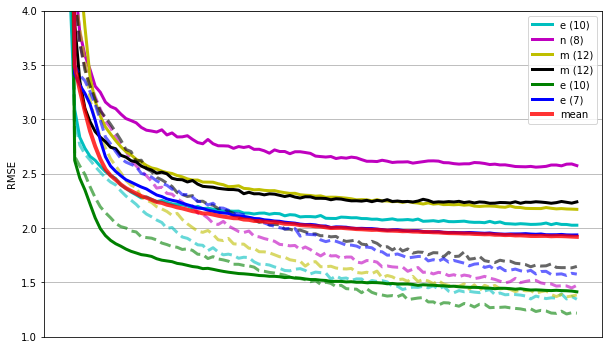

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_color_cycle(['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

valid_losses = []
train_losses = []

for model_number, (cg, model) in enumerate(models.items(), 1):
    valid_loss = np.array([i['valid_loss'] for i in model.train_history_])
    train_loss = np.array([i['train_loss'] for i in model.train_history_])
    valid_loss = np.sqrt(valid_loss) * 48
    train_loss = np.sqrt(train_loss) * 48
    valid_loss = rebin(valid_loss, (100,))
    train_loss = rebin(train_loss, (100,))
    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    ax.plot(valid_loss,label='{} ({})'.format(cg[0], len(cg)), linewidth=3)
    ax.plot(train_loss,linestyle='--', linewidth=3, alpha=0.6)
    ax.set_xticks([])

weights = np.array([m.output_num_units for m in models.values()],dtype=float)
weights /= weights.sum()
mean_valid_loss = (np.vstack(valid_losses) * weights.reshape(-1, 1)).sum(axis=0)
ax.plot(mean_valid_loss, color='r', label='mean', linewidth=4, alpha=0.8)
ax.legend()
ax.set_ylim((1.0, 4.0))
ax.grid()
plt.ylabel("RMSE")
plt.show()

In [40]:
mean_valid_loss[99]

1.9193458468468299